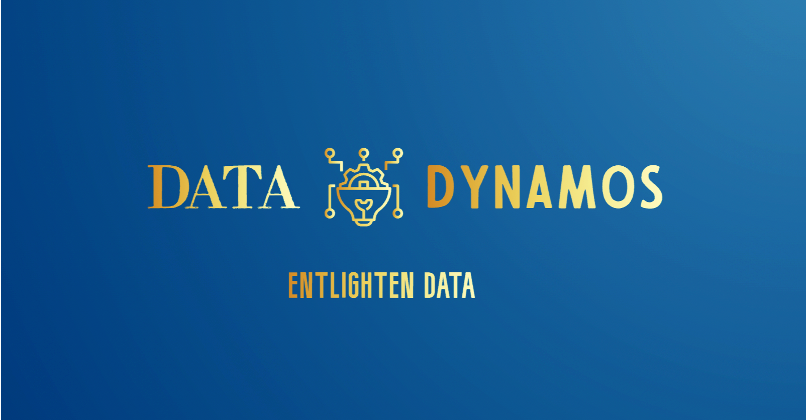

<H1 size =10><center>MBD-PT 2023 Social Network Analysis  </center></H1>
<HR></HR>
<H2 size =7><center> Analysing Drug Interactions and Chemical Compound Similarities for Business Insights -  Graph Metrics </center></H2>

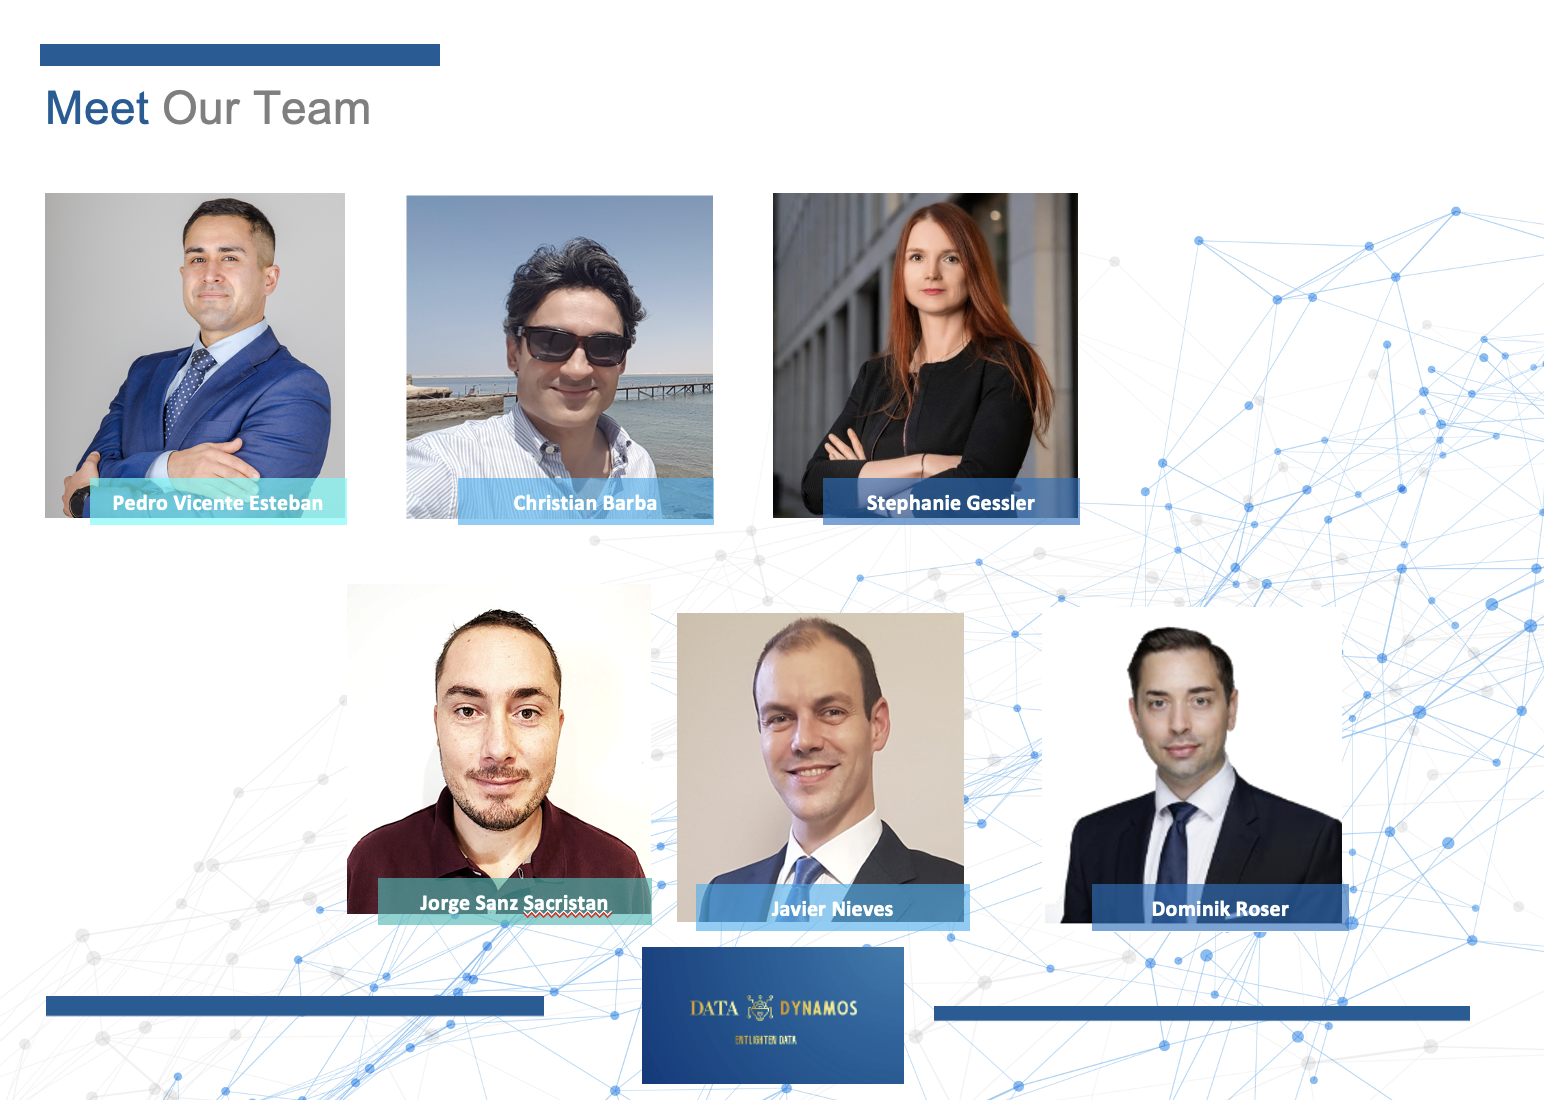

# <font color='#104E8B' size="6"><b>Table of contents</b></font> <br>

* [0. Description & General Objective](#0)
* [1. Import Libraries ](#1)
* [2. Import Datasets](#2)
  * [2.1. DDINTER](#2.1)   
  * [2.2. ATC](#2.2)
  * [2.3. IQVIA](#2.3)
* [3. Create Nodes Dataset](#3)
  * [3.1. Drug Name Replacement](#3.1)   
  * [3.2. Add Molecule Characteristics from CHEMBL](#3.2)
  * [3.3. Add Chembl Database ATC Classifications](#3.3)
    * [3.3.1.  ATC Code Classifications](#3.3.1)
    * [3.3.2. Adding ATC1 code to the table ](#3.3.2)
    * [3.3.3 Adding ATC2 code to the table ](#3.3.3)
* [4. Graph Statistics](#4)
    * [4.1) Graph Summary](#4.1)   
    * [4.2) ATC Plots and Distribution](#4.2) 
* [5. Graph Basic Metrics](#5)
    * [5.1) Closeness centrality](#5.1)
    * [5.2) Betweeness centrality](#5.2)
    * [5.3) Pagerank](#5.3)
    * [5.4) Degree centrality](#5.4)
    * [5.5) Eigenvector centrality](#5.5)
    * [5.6) Cluster Coefficient](#5.6)
* [6.Drug Graph Metrics](#6)
    * [6.1) Transitivity](#6.1)
    * [6.2) K-Core Decomposition](#6.2)
    * [6.3) Dispersion](#6.3)
    * [6.4) Assortativity Coefficient](#6.4)
    * [6.5) Jaccard similarity coefficient](#6.5)
    * [6.6) Link Prediction](#6.6)



<a id='0'></a>
<h1 align="left"><font size="5" color='#104E8B' > <b>  0.Descriptive and General Objective </b><br></font></h1> 

**Goal**: To identify potential drug interactions and similarities based on both social network graphs and chemical structures.

**Objective**: To improve patient safety and optimize drug therapy by providing healthcare professionals with a tool that can quickly and accurately analyze potential drug interactions and similarities.

<a id='1'></a>
<h1 align="left"><font size="5" color='#104E8B' > <b>  1. Import Libraries </b><br></font></h1> 

In [150]:
import os
import pandas as pd

import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

import plotly.graph_objs as go

import re

import operator

import time


from chembl_webresource_client.new_client import new_client

<a id='2'></a>
<h1 align="left"><font size="5" color='#104E8B' > <b>  2. Import Datasets  </b><br></font></h1> 

<a id='2.1'></a>
<h1 align="left"><font size="4" color='#104E8B' > <b>  2.1 DDINTER  </b><br></font></h1> 
Import Ddinter into a Pandas Dataframe 

> Drug-drug interaction (DDI) is broadly described as a change in the effect of one drug due to the presence of another drug. Most interactions can seriously affect efficacy and safety drug profiles and have been a significant cause of adverse drug interactions (ADRs). DDIs can be divided into pharmaceutical, pharmacokinetic (PK) interactions, and pharmacodynamic (PD) interactions. Pharmaceutical interactions occur due to physical or chemical incompatibilities, which are often out of the conventional scope of DDIs. PK interactions could influence the drug disposition process to change the free-drug concentration at the target site, including absorption, distribution, metabolism, and excretion (ADME). While PD interactions usually are synergistic or antagonistic, which can occur by interacting with the same therapeutic targets, involving in different signaling pathways, or causing different pharmacological responses. We mainly focus on the latter two kinds of DDIs in this work and the details of these subclasses are elaborated

Criteria for severity annotation
Categories of severity were accepted as suggested by DRUGDEX and other similar resources:


<font color=red>Major</font>: The interactions are life-threatening and/or require medical treatment or intervention to minimize or prevent severe adverse effects.

<font color=orange>Moderate</font>:The interactions may result in exacerbation of the disease of the patient and/or change in therapy.

<font color=green>Minor</font>: The interactions would limit the clinical effects. The manifestations may include an increase in frequency or severity of adverse effects, but usually they do not require changes in therapy.

<font color=grey>Unknown</font>: The DDIs collected from the article published in Sci Transl Med were lack of mechanism descriptions, and thus the severity classifications of these DDIs were annotated with 'Unknown'.

In [151]:
# directory containing the csv files
directory = '/Users/stephaniegessler/Documents/Social Network Analysis/ddinter'

# list of csv files in the directory
csv_files = [f for f in os.listdir(directory) if f.endswith('.csv')]

# empty list to store dataframes
dfs = []

# loop through csv files and create dataframes
for csv_file in csv_files:
    # read csv file
    df = pd.read_csv(os.path.join(directory, csv_file))
    
    
    # append dataframe to the list
    dfs.append(df)

# concatenate dataframes into one
combined_df = pd.concat(dfs, ignore_index=True)

#remove duplicates of the entire row 
#combined_df.drop_duplicates(subset=None, keep='first', inplace=True)

# save combined dataframe as a csv file
combined_df.to_csv('combined_csv_files.csv', index=False)

# Remove duplicates of the entire row
combined_df.drop_duplicates(subset=None, keep='first', inplace=True)

In [152]:
combined_df.shape

(160235, 5)

In [153]:
# get unique values in the 'Level' column
unique_levels = combined_df['Level'].unique()

# print unique values
print(unique_levels)

['Minor' 'Moderate' 'Major' 'Unknown']


In [154]:
# define a lambda function to map level to weight
map_weight = lambda x: 2 if x == 'Unknown' else 3 if x == 'Minor' else 2 if x == 'Moderate' else 1 if x == 'Major' else 0

# add new column 'Weight' with mapped values
combined_df['Weight'] = combined_df['Level'].apply(map_weight)

# print dataframe with new column
combined_df

DDInterID_A              Drug_A  DDInterID_B                   Drug_B  \
0        DDInter513       Dexamethasone   DDInter582             Dolutegravir   
1        DDInter997           Ivacaftor   DDInter582             Dolutegravir   
2       DDInter1019          Lamivudine  DDInter1123                 Mannitol   
3        DDInter195       Betamethasone  DDInter1961               Zidovudine   
4       DDInter1961          Zidovudine   DDInter246               Budesonide   
...             ...                 ...          ...                      ...   
222341   DDInter856             Heparin   DDInter805  gamma-Aminobutyric acid   
222342  DDInter1683  Sodium bicarbonate   DDInter805  gamma-Aminobutyric acid   
222359   DDInter908            Iloprost    DDInter62              Ambrisentan   
222365  DDInter1951            Warfarin  DDInter1942                Vitamin D   
222368  DDInter1683  Sodium bicarbonate  DDInter1942                Vitamin D   

           Level  Weight  
0          Minor       3  
1          Minor       3  
2       Moderate       2  
3       Moderate       2  
4       Moderate       2  
...          ...     ...  
222341   Unknown       2  
222342   Unknown       2  
222359   Unknown       2  
222365   Unknown       2  
222368   Unknown       2  

[160235 rows x 6 columns]

In [155]:
#Create edges table from combined_df
edges = combined_df

In [156]:
#replace "," with ";" 
edges['Drug_A'] = edges['Drug_A'].str.replace(';', ',')
edges['Drug_B'] = edges['Drug_B'].str.replace(';', ',')

In [157]:
#convert combined_df to csv file with ";" as separator
edges.to_csv('edges.csv', sep=';', index=False)

<a id='2.2'></a>
<h1 align="left"><font size="4" color='#104E8B' > <b>  2.2 Importing ATC Table   </b><br></font></h1> 

The  Anatomical Therapeutic Chemical (ATC) classification will be imported to the dataset. ATC will be explained under the ATC section. 

In [158]:

ATC = pd.read_excel('/Users/stephaniegessler/IE Students/Term 3 - Data Dynamos - General/Social Network Analysis/drugs/swissmedic/ATC Classifications and Names.xlsx')

ATC.head(20)

atc_code                                           atc_name  \
0         A                    ALIMENTARY TRACT AND METABOLISM   
1       A01                        STOMATOLOGICAL PREPARATIONS   
2      A01A                        STOMATOLOGICAL PREPARATIONS   
3     A01AA                         Caries prophylactic agents   
4   A01AA01                                    sodium fluoride   
5   A01AA02                         sodium monofluorophosphate   
6   A01AA03                                            olaflur   
7   A01AA04                                  stannous fluoride   
8   A01AA30                                       combinations   
9   A01AA51                      sodium fluoride, combinations   
10    A01AB  Antiinfectives and antiseptics for local oral ...   
11  A01AB02                                  hydrogen peroxide   
12  A01AB03                                      chlorhexidine   
13  A01AB04                                     amphotericin B   
14  A01AB05                                        polynoxylin   
15  A01AB06                                           domiphen   
16  A01AB07                                       oxyquinoline   
17  A01AB08                                           neomycin   
18  A01AB09                                         miconazole   
19  A01AB10                                          natamycin   

                    ddd  uom adm_r             note Unnamed: 6  
0                   NaN  NaN   NaN              NaN       ATC1  
1                   NaN  NaN   NaN              NaN       ATC2  
2                   NaN  NaN   NaN              NaN       ATC3  
3                   NaN  NaN   NaN              NaN       ATC4  
4   2023-01-01 00:00:00   mg     O  0.5 mg fluoride       ATC5  
5                   NaN  NaN   NaN              NaN        NaN  
6   2023-01-01 00:00:00   mg     O              NaN        NaN  
7                   NaN  NaN   NaN              NaN        NaN  
8                   NaN  NaN   NaN              NaN        NaN  
9                   NaN  NaN   NaN              NaN        NaN  
10                  NaN  NaN   NaN              NaN        NaN  
11                   60   mg     O              NaN        NaN  
12                   30   mg     O              NaN        NaN  
13                   40   mg     O              NaN        NaN  
14                 0.18    g     O              NaN        NaN  
15                    3   mg     O              NaN        NaN  
16                   80   mg     O              NaN        NaN  
17                  NaN  NaN   NaN              NaN        NaN  
18                  0.2    g     O              NaN        NaN  
19                   20   mg     O              NaN        NaN

<a id='2.3'></a>
<h1 align="left"><font size="4" color='#104E8B' > <b>  2.3 Import IQVIA </b><br></font></h1> 

>Import IQVIA into a Pandas Dataframe which provides the units distribution of the market in Switzerland by the different molecule/ drug type. Some drugs are used in singular in a mono therapy, others are put in combination as combi. The ranking describes the distribution of these molecules/Drugs based on 2023 results and usage in the market. Units MAT (Moving Annual Total) provides the market usage and distribution in the market. Our analysis will focus only on the current market 2023.  The Sum inlc Combi provides the distribution of Drugs which are given in Molecule with the molecule mentioned. The Ranking Mono and Ranking Combi provides the information which of these are ranked the highest in terms of distriburion only looking at the Mono Drug or in Combination with others. For similicity, we do not consider packing size and strength of the respective molecule/drug. 

In [159]:
#rettrive from excel the second workbook "Mono"
IQVIA = pd.read_excel('/Users/stephaniegessler/IE Students/Term 3 - Data Dynamos - General/Social Network Analysis/drugs/CH Drug Distribution/IQVIA.xlsx',sheet_name="Mono")

IQVIA.head(20)


Row Labels  Units MAT Feb 2020  Units  MAT Feb 2021  \
0            PARACETAMOL           8709710.0            8605565.0   
1              IBUPROFEN           8022915.0            6257911.0   
2         COLECALCIFEROL           3928582.0            4714102.0   
3             DICLOFENAC           4434500.0            4068832.0   
4           PANTOPRAZOLE           2899125.0            2879570.0   
5      METAMIZOLE SODIUM           2333573.0            2304660.0   
6   ACETYLSALICYLIC ACID           2323379.0            2279675.0   
7              MAGNESIUM           2046801.0            2067960.0   
8         XYLOMETAZOLINE           1904461.0            1376550.0   
9         ACETYLCYSTEINE           1536567.0             900140.0   
10              ZOLPIDEM           1439833.0            1389898.0   
11          DEXPANTHENOL           1461137.0            1412184.0   
12             METFORMIN           1247791.0            1264797.0   
13          ATORVASTATIN           1144657.0            1165781.0   
14  LEVOTHYROXINE SODIUM           1179684.0            1168192.0   
15             LORAZEPAM           1133911.0            1121817.0   
16            MOMETASONE            955500.0             864249.0   
17                  UREA           1068512.0            1061007.0   
18            LOPERAMIDE            992700.0             624831.0   
19            CETIRIZINE            821062.0             975891.0   

    Units MAT Feb 2022  Units MAT Feb 2023   % Growth  Sum incl combi  \
0            9758040.0          11047056.0   0.132098        14291456   
1            7808308.0           9724304.0   0.245379         9850860   
2            4769101.0           4308630.0  -0.096553         5929035   
3            4224026.0           4231062.0   0.001666         5125490   
4            3037873.0           3170851.0   0.043773         3170851   
5            2359320.0           2316965.0  -0.017952         2316965   
6            2277186.0           2274078.0  -0.001365         2812337   
7            2154563.0           2185350.0   0.014289         3240089   
8            1658246.0           1999905.0   0.206036         3937333   
9            1116398.0           1834454.0   0.643190         2500285   
10           1365755.0           1552515.0   0.136745         1552515   
11           1454316.0           1511731.0   0.039479         4260796   
12           1290373.0           1311408.0   0.016301         1826206   
13           1209738.0           1252593.0   0.035425         1497215   
14           1192707.0           1239288.0   0.039055         1252416   
15           1109016.0           1148151.0   0.035288         1148154   
16            921392.0           1088789.0   0.181678         1098495   
17           1049135.0            996507.0  -0.050163         2575140   
18            798828.0            986729.0   0.235221          995494   
19            874538.0            968601.0   0.107557         1284112   

    Ranking Mono   Ranking Combi  
0               1              1  
1               2              2  
2               3              4  
3               4              5  
4               5             11  
5               6             19  
6               7             15  
7               8             10  
8               9              9  
9              10             17  
10             11             30  
11             12              7  
12             13             24  
13             14             34  
14             15             40  
15             16             45  
16             17             52  
17             18             16  
18             19             57  
19             20             39

<a id='3'></a>
<h1 align="left"><font size="5" color='#104E8B' > <b>  3. Create Nodes Dataset </b><br></font></h1> 

We are creating a Nodes Dataset where we add all additional attributs. 

In [160]:
#create a nodes tables
# Creata a new pandas datframe for the nodes characteristics, use DDInterID_A and DDInterID_B and Drug_A and DrugB as label. Make sure they are unique and drop duplicates
nodes = pd.DataFrame(combined_df[['DDInterID_A', 'Drug_A']].drop_duplicates().values, columns=['DDInterID', 'Drug'])
nodes = nodes.append(pd.DataFrame(combined_df[['DDInterID_B', 'Drug_B']].drop_duplicates().values, columns=['DDInterID', 'Drug']), ignore_index=True)
nodes = nodes.drop_duplicates()

/var/folders/ks/5bc1x9p158vgc4774v7r2tq40000gn/T/ipykernel_65890/2044511243.py:4: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [161]:
nodes.head()

DDInterID           Drug
0   DDInter513  Dexamethasone
1   DDInter997      Ivacaftor
2  DDInter1019     Lamivudine
3   DDInter195  Betamethasone
4  DDInter1961     Zidovudine

In [162]:
#count the number of nodes
nodes.shape

(1939, 2)

<a id='3.1'></a>
<a id='3'></a>
<h1 align="left"><font size="4" color='#104E8B' > <b>  3.1. Drug Name Replacement </b><br></font></h1> 

In order to harmonize Chembl, IQVIA and the DDInter Database, we harmonize the database Drug names to retrieve the right information under the name. 

In [163]:
#Dublicate the nodes['Drug'] to a new column Drug_original
nodes['Drug_original'] = nodes['Drug']

In [164]:
# replace Insulin human (isophane) in Drug and Drug_B with INSULIN HUMAN ISOPHANE
nodes['Drug'] = nodes['Drug'].replace('Insulin human (isophane)', 'INSULIN HUMAN ISOPHANE')

# replace Insulin human (regular) in Drug and Drug_B with INSULIN HUMAN BASE
nodes['Drug'] = nodes['Drug'].replace('Insulin human (regular)', 'INSULIN HUMAN BASE')

# replace Insulin human (zinc) in Drug and Drug_B with 	INSULIN HUMAN ZINC
nodes['Drug'] = nodes['Drug'].replace('Insulin human (zinc)', 'INSULIN HUMAN ZINC')

# replace Insulin human (zinc extended) in Drug and Drug_B with INSULIN HUMAN ZINC, EXTENDED
nodes['Drug'] = nodes['Drug'].replace('Insulin human (zinc extended)', 'INSULIN HUMAN ZINC, EXTENDED')

# replace Dextran (-1) in Drug and Drug_B with 	DEXTRAN 1
nodes['Drug'] = nodes['Drug'].replace('Dextran (-1)', 'DEXTRAN 1')

# replace Dextran (high molecular weight) in Drug and Drug_B with 	DEXTRAN, HIGH MOLECULAR WEIGHT
nodes['Drug'] = nodes['Drug'].replace('Dextran (high molecular weight)', 'DEXTRAN, HIGH MOLECULAR WEIGHT')

# replace Amphotericin B (lipid complex) in Drug_A and Drug_B with AMPHOTERICIN B
nodes['Drug'] = nodes['Drug'].replace('Amphotericin B (lipid complex)', 'AMPHOTERICIN B')

# replace Cocaine (nasal) in Drug_A and Drug_B COCAINE HYDROCHLORIDE
#nodes['Drug'] = nodes['Drug'].replace('Cocaine (nasal)', 'COCAINE HYDROCHLORIDE')

# replace Daunorubicin (liposomal) in Drug_A and Drug_B with DAUNORUBICIN CITRATE
nodes['Drug'] = nodes['Drug'].replace('Daunorubicin (liposomal)', 'DAUNORUBICIN CITRATE')

# replace DDoxorubicin (liposomal) in Drug_A and Drug_B with DOXORUBICIN HYDROCHLORIDE
nodes['Drug'] = nodes['Drug'].replace('Doxorubicin (liposomal)', 'DOXORUBICIN HYDROCHLORIDE')

# replace Amphotericin B (liposomal) in Drug_A and Drug_B with AMPHOTERICIN B LIPOSOME
nodes['Drug'] = nodes['Drug'].replace('Amphotericin B (liposomal)', 'AMPHOTERICIN B LIPOSOME')

# replace Benzylpenicillin (sodium) in Drug_A and Drug_B with PENICILLIN G
nodes['Drug'] = nodes['Drug'].replace('Benzylpenicillin (sodium)', 'PENICILLIN G SODIUM')

# replace Heparin (flush) in Drug_A and Drug_B with HEPARIN SODIUM
nodes['Drug'] = nodes['Drug'].replace('Heparin (flush)', 'HEPARIN')

# replace Salicylic acid (sodium) in Drug_A and Drug_B with SODIUM SALICYLATE
nodes['Drug'] = nodes['Drug'].replace('Salicylic acid (sodium)', 'SODIUM SALICYLATE')

# replace Factor IX Complex (Human) in Drug_A and Drug_B with FACTOR IX COMPLEX HUMAN
nodes['Drug'] = nodes['Drug'].replace('Factor IX Complex (Human)', 'FACTOR IX COMPLEX HUMAN')

# replace Polyethylene glycol (3350 with electrolytes) in Drug_A and Drug_B with POLYETHYLENE GLYCOL 3350
nodes['Drug'] = nodes['Drug'].replace('Polyethylene glycol (3350 with electrolytes)', 'POLYETHYLENE GLYCOL 3350')


# replace Polyethylene glycol (3350) in Drug_A and Drug_B with POLYETHYLENE GLYCOL
nodes['Drug'] = nodes['Drug'].replace('Polyethylene glycol (3350)', 'POLYETHYLENE GLYCOL 3350')

# replace Typhoid vaccine (live) in Drug_A and Drug_B with TYPHOID VACCINE
nodes['Drug'] = nodes['Drug'].replace('Typhoid vaccine (live)', 'TYPHOID VACCINE')

# replace Human Rho(D) immune globulin in Drug_A and Drug_B with RHO (D) IMMUNE GLOBULIN
nodes['Drug'] = nodes['Drug'].replace('Human Rho(D) immune globulin', 'RHO (D) IMMUNE GLOBULIN')


# replace Fludeoxyglucose (18F) in Drug_A and Drug_B with FLUDEOXYGLUCOSE F 18
nodes['Drug'] = nodes['Drug'].replace('Fludeoxyglucose (18F)', 'FLUDEOXYGLUCOSE F 18')

# replace Olopatadine (nasal) in Drug_A and Drug_B with OLOPATADINE HYDROCHLORIDE
#nodes['Drug'] = nodes['Drug'].replace('Olopatadine (nasal)', 'OLOPATADINE HYDROCHLORIDE')

# replace Tositumomab (I-131) in Drug_A and Drug_B with TOSITUMOMAB 131I
nodes['Drug'] = nodes['Drug'].replace('Tositumomab (I-131)', 'TOSITUMOMAB 131I')

# replace Human immunoglobulin G (intravenous) in Drug_A and Drug_B with HUMAN IMMUNOGLOBULIN G
nodes['Drug'] = nodes['Drug'].replace('Human immunoglobulin G (intravenous)', 'HUMAN IMMUNOGLOBULIN G')


# replace Antilymphocyte immunoglobulin (horse) in Drug_A and Drug_B with ANTILYMPHOCYTE IMMUNOGLOBULIN (HORSE)
nodes['Drug'] = nodes['Drug'].replace('Antilymphocyte immunoglobulin (horse)', 'ANTILYMPHOCYTE IMMUNOGLOBULIN (HORSE)')

# replace Vincristine (liposome) in Drug_A and Drug_B with VINCRISTINE SULFATE
nodes['Drug'] = nodes['Drug'].replace('Vincristine (liposome)', 'VINCRISTINE')


# replace Insulin aspart (aspart protamine) in Drug_A and Drug_B with INSULIN ASPART PROTAMINE RECOMBINANT
nodes['Drug'] = nodes['Drug'].replace('Insulin aspart (aspart protamine)', 'INSULIN ASPART PROTAMINE RECOMBINANT')

# replace Manganese (sulfate) in Drug_A and Drug_B with MANGANESE SULFATE
nodes['Drug'] = nodes['Drug'].replace('Manganese (sulfate)', 'MANGANESE SULFATE')

# replace Azelastine (nasal) in Drug_A and Drug_B with AZELASTINE
#nodes['Drug'] = nodes['Drug'].replace('Azelastine (nasal)', 'AZELASTINE')

# replace Insulin lispro (protamine) in Drug_A and Drug_B with 	INSULIN LISPRO PROTAMINE RECOMBINANT
nodes['Drug'] = nodes['Drug'].replace('Insulin lispro (protamine)', 'INSULIN LISPRO PROTAMINE RECOMBINANT')

# replace Prilocaine (topiclal) in Drug_A and Drug_B with PRILOCAINE
nodes['Drug'] = nodes['Drug'].replace('Prilocaine (topiclal)', 'Prilocaine (topical)')

# replace Iobenguane (I-131) in Drug_A and Drug_B with 	IOBENGUANE I 131
nodes['Drug'] = nodes['Drug'].replace('Iobenguane (I-131)', 'IOBENGUANE I 131')

# replace Iobenguane (I-123) in Drug_A and Drug_B with IOBENGUANE I 123
nodes['Drug'] = nodes['Drug'].replace('Iobenguane (I-123)', 'IOBENGUANE I 123')

# replace Sodium phosphate, monobasic (p32) in Drug_A and Drug_B SODIUM PHOSPHATE, MONOBASIC
nodes['Drug'] = nodes['Drug'].replace('Sodium phosphate, monobasic (p32)', 'SODIUM PHOSPHATE, MONOBASIC')

# replace Manganese (chloride) in Drug_A and Drug_B with MANGANESE CHLORIDE
nodes['Drug'] = nodes['Drug'].replace('Manganese (chloride)', 'MANGANESE CHLORIDE')

# replace Levomefolic acid (calcium) in Drug_A and Drug_B with LEVOMEFOLIC ACID
nodes['Drug'] = nodes['Drug'].replace('Levomefolic acid (calcium)', 'LEVOMEFOLIC ACID')

# replace Dextran (low molecular weight) in Drug with DEXTRAN
nodes['Drug'] = nodes['Drug'].replace('Dextran (low molecular weight)', 'DEXTRAN')

# replace Prilocaine (topiclal) in Drug with PRILOCAINE
nodes['Drug'] = nodes['Drug'].replace('Prilocaine (topiclal)', 'Prilocaine (topical)')

# replace Ranitidine (bismuth citrate) in Drug with RANITIDINE BISMUTH CITRATE
nodes['Drug'] = nodes['Drug'].replace('Ranitidine (bismuth citrate)', 'RANITIDINE BISMUTH CITRATE')

# replace Samarium (153Sm) lexidronam in Drug with SAMARIUM SM 153 LEXIDRONAM PENTASODIUM
nodes['Drug'] = nodes['Drug'].replace('Samarium (153Sm) lexidronam', 'SAMARIUM SM 153 LEXIDRONAM PENTASODIUM')

# replace Benzylpenicillin (potassium) in Drug with PENICILLIN G POTASSIUM
nodes['Drug'] = nodes['Drug'].replace('Benzylpenicillin (potassium)', 'PENICILLIN G POTASSIUM')

# replace Chorionic Gonadotropin (Human) in Drug with GONADOTROPIN, CHORIONIC
nodes['Drug'] = nodes['Drug'].replace('Chorionic Gonadotropin (Human)', 'GONADOTROPIN, CHORIONIC')

# replace Bupivacaine (liposome) in Drug with BUPIVACAINE
nodes['Drug'] = nodes['Drug'].replace('Bupivacaine (liposome)', 'BUPIVACAINE')

# replace 	Insulin aspart (aspart) in Drug with INSULIN ASPART
nodes['Drug'] = nodes['Drug'].replace('Insulin aspart (aspart)', 'INSULIN ASPART')

# replace Cytarabine (liposomal) in Drug with CYTARABINE
nodes['Drug'] = nodes['Drug'].replace('Cytarabine (liposomal)', 'CYTARABINE')



# remove from Drug_A and Drug_B the only  " (ophthalmic)" from all names of the drug
#nodes['Drug'] = nodes['Drug'].replace('(-ophthalmic)', '')

# remove from Drug_A and Drug_B the only  "(topical)" from all names of the drug
#nodes['Drug'] = nodes['Drug'].replace('(-(topical))', '')

# remove from Drug_A and Drug_B the only  " (ophthalmic)" from all names of the drug

#nodes['Drug'] = nodes['Drug'].apply(lambda x: re.sub(r'\( *ophthalmic *\)', '', x))

# remove from Drug_A and Drug_B the only  "(topical)" from all names of the drug


#nodes['Drug'] = nodes['Drug'].apply(lambda x: re.sub(r'\( *topical *\)', '', x))

#nodes['Drug'] = nodes['Drug'].apply(lambda x: re.sub(r'\( *nasal *\)', '', x))

In [165]:
#show if there are () in the name of the drug
check = nodes[nodes['Drug'].str.contains('\(')]
check

DDInterID                         Drug                Drug_original
9      DDInter427            Cocaine (topical)            Cocaine (topical)
12       DDInter3         Abametapir (topical)         Abametapir (topical)
55    DDInter1333          Olopatadine (nasal)          Olopatadine (nasal)
60     DDInter764    Flurbiprofen (ophthalmic)    Flurbiprofen (ophthalmic)
100    DDInter154           Azelastine (nasal)           Azelastine (nasal)
...           ...                          ...                          ...
3332  DDInter1225        Minocycline (topical)        Minocycline (topical)
3343   DDInter423           Coal tar (topical)           Coal tar (topical)
3344   DDInter861    Hexachlorophene (topical)    Hexachlorophene (topical)
3548   DDInter710          Factor XIII (human)          Factor XIII (human)
3620  DDInter1183  Methyl salicylate (topical)  Methyl salicylate (topical)

[181 rows x 3 columns]

In [166]:
nodes.shape

(1939, 3)

Add the market data to the Nodes Tables and then we drop the columns we do not need. 

In [167]:
# rename Molecule_Kombi column to Drug
IQVIA.rename(columns={'Row Labels': 'Drug'}, inplace=True)

#lowercase all Drug names in IQVIA Table except for the first letter
IQVIA['Drug'] = IQVIA['Drug'].str.title()

# merge the two tables based , left join on nodes table
merged_df = pd.merge(nodes, IQVIA, on='Drug', how='left') 

# print the merged table
merged_df

DDInterID                 Drug        Drug_original  \
0      DDInter513        Dexamethasone        Dexamethasone   
1      DDInter997            Ivacaftor            Ivacaftor   
2     DDInter1019           Lamivudine           Lamivudine   
3      DDInter195        Betamethasone        Betamethasone   
4     DDInter1961           Zidovudine           Zidovudine   
...           ...                  ...                  ...   
1934   DDInter371  Chondroitin sulfate  Chondroitin sulfate   
1935   DDInter446            Cranberry            Cranberry   
1936   DDInter829          Glucosamine          Glucosamine   
1937  DDInter1390               Papaya               Papaya   
1938  DDInter1551  Pyrophosphoric acid  Pyrophosphoric acid   

      Units MAT Feb 2020  Units  MAT Feb 2021  Units MAT Feb 2022  \
0               359431.0             361420.0            380089.0   
1                    NaN                  NaN                 NaN   
2                 8505.0               8570.0              6428.0   
3               293676.0             259908.0            278059.0   
4                  708.0                670.0               459.0   
...                  ...                  ...                 ...   
1934                 NaN                  NaN                 NaN   
1935                 NaN                  NaN                 NaN   
1936                 NaN                  NaN                 NaN   
1937                 NaN                  NaN                 NaN   
1938                 NaN                  NaN                 NaN   

      Units MAT Feb 2023   % Growth  Sum incl combi  Ranking Mono   \
0               401082.0   0.055232       1162374.0           75.0   
1                    NaN        NaN             NaN            NaN   
2                 5231.0  -0.186217         57057.0          811.0   
3               294065.0   0.057563        877133.0          111.0   
4                  413.0  -0.100218          1229.0         1086.0   
...                  ...        ...             ...            ...   
1934                 NaN        NaN             NaN            NaN   
1935                 NaN        NaN             NaN            NaN   
1936                 NaN        NaN             NaN            NaN   
1937                 NaN        NaN             NaN            NaN   
1938                 NaN        NaN             NaN            NaN   

      Ranking Combi  
0              44.0  
1               NaN  
2             463.0  
3              70.0  
4            1044.0  
...             ...  
1934            NaN  
1935            NaN  
1936            NaN  
1937            NaN  
1938            NaN  

[1939 rows x 11 columns]

In [168]:
# enter zero for NaN value
merged_df = merged_df.fillna(0)

In [169]:
merged_df.columns

Index(['DDInterID', 'Drug', 'Drug_original', 'Units MAT Feb 2020',
       'Units  MAT Feb 2021', 'Units MAT Feb 2022', 'Units MAT Feb 2023',
       ' % Growth', 'Sum incl combi', 'Ranking Mono ', 'Ranking Combi'],
      dtype='object')

In [170]:
# drop the columns Units MAT Feb 2020,Units MAT Feb 2021,Units MAT Feb 2022
merged_df = merged_df.drop(['Units MAT Feb 2020','Units  MAT Feb 2021','Units MAT Feb 2022'], axis=1)

In [171]:
merged_df.head()

DDInterID           Drug  Drug_original  Units MAT Feb 2023   % Growth  \
0   DDInter513  Dexamethasone  Dexamethasone            401082.0   0.055232   
1   DDInter997      Ivacaftor      Ivacaftor                 0.0   0.000000   
2  DDInter1019     Lamivudine     Lamivudine              5231.0  -0.186217   
3   DDInter195  Betamethasone  Betamethasone            294065.0   0.057563   
4  DDInter1961     Zidovudine     Zidovudine               413.0  -0.100218   

   Sum incl combi  Ranking Mono   Ranking Combi  
0       1162374.0           75.0           44.0  
1             0.0            0.0            0.0  
2         57057.0          811.0          463.0  
3        877133.0          111.0           70.0  
4          1229.0         1086.0         1044.0

In [172]:
nodes = merged_df

<a id='3.2'></a>
<h1 align="left"><font size="4" color='#104E8B' > <b>  3.2. ADD Molecule Characteristics from CHEMBL   </b><br></font></h1> 

Adding attributes to the nodes table.

The columns describe relevant features of each pipe. The complete list is:


- <font color='#008B8B'>oral</font> -  A binary flag indicating whether the molecule can be administered orally (i.e., by mouth)
- <font color='#008B8B'>ophthalmic</font>  -  A binary flag indicating whether the molecule can be administered ophthalmic( i.e. by eye)
- <font color='#008B8B'>parenteral</font>  - A binary flag indicating whether the molecule can be administered by injection or other non-oral means
- <font color='#008B8B'>topical</font>  - A binary flag indicating whether the molecule can be applied topically, i.e., to the skin
- <font color='#008B8B'>chirality</font>  - A binary flag indicating whether the molecule is chiral, 0.0 Racemic Mixture,  1.0 Single Stereoisomer, 2.0 Archiral Moelcule
- <font color='#008B8B'>black box warning</font>  - A binary flag indicating whether the drug has a black box warning, which is the strongest warning that the US Food and Drug Administration (FDA) can issue about a drug
- <font color='#008B8B'>availability type</font>   - A classification of the type of availability of the drug, such as "1" (available for prescription), "2" (available over the counter), or "3" (withdrawn from market), - "-1" Undefined 
- <font color='#008B8B'>first in class</font>   - A binary flag indicating whether the molecule is the first in its class, i.e., the first drug to target a particular mechanism of action.



In [173]:
# Transform the Drug administrative name to a column 
merged_df['topical'] = merged_df['Drug_original'].apply(lambda x: 'topical' in x)
merged_df['nasal'] = merged_df['Drug_original'].apply(lambda x: 'nasal' in x)
merged_df['ophthalmic'] = merged_df['Drug_original'].apply(lambda x: 'ophthalmic' in x)

merged_df

DDInterID                 Drug        Drug_original  \
0      DDInter513        Dexamethasone        Dexamethasone   
1      DDInter997            Ivacaftor            Ivacaftor   
2     DDInter1019           Lamivudine           Lamivudine   
3      DDInter195        Betamethasone        Betamethasone   
4     DDInter1961           Zidovudine           Zidovudine   
...           ...                  ...                  ...   
1934   DDInter371  Chondroitin sulfate  Chondroitin sulfate   
1935   DDInter446            Cranberry            Cranberry   
1936   DDInter829          Glucosamine          Glucosamine   
1937  DDInter1390               Papaya               Papaya   
1938  DDInter1551  Pyrophosphoric acid  Pyrophosphoric acid   

      Units MAT Feb 2023   % Growth  Sum incl combi  Ranking Mono   \
0               401082.0   0.055232       1162374.0           75.0   
1                    0.0   0.000000             0.0            0.0   
2                 5231.0  -0.186217         57057.0          811.0   
3               294065.0   0.057563        877133.0          111.0   
4                  413.0  -0.100218          1229.0         1086.0   
...                  ...        ...             ...            ...   
1934                 0.0   0.000000             0.0            0.0   
1935                 0.0   0.000000             0.0            0.0   
1936                 0.0   0.000000             0.0            0.0   
1937                 0.0   0.000000             0.0            0.0   
1938                 0.0   0.000000             0.0            0.0   

      Ranking Combi  topical  nasal  ophthalmic  
0              44.0    False  False       False  
1               0.0    False  False       False  
2             463.0    False  False       False  
3              70.0    False  False       False  
4            1044.0    False  False       False  
...             ...      ...    ...         ...  
1934            0.0    False  False       False  
1935            0.0    False  False       False  
1936            0.0    False  False       False  
1937            0.0    False  False       False  
1938            0.0    False  False       False  

[1939 rows x 11 columns]

Add drug attributes to the nodes table 

In [174]:
molecule = new_client.molecule
molecule_types = []

start = time.time()
processed = 0

for drug in nodes['Drug']:
    try:
        # compute duration to execute the loop
        # get current system time
        #print("processing: ", drug)
        #drug_start = time.time()
        
        # Remove content within brackets
        clean_drug = re.sub(r'\s?\(.*?\)', '', drug)
        
        mols = molecule.filter(molecule_synonyms__molecule_synonym__iexact=clean_drug).only(['oral'])
        molecule_types.append(mols[0]['oral'] if mols[0]['oral'] else '')
        #end = time.time()
        # print the time taken to execute the loop
        #processed += 1
        #print(f'Processed {processed} drugs, average processing time {(end - start)/processed}, last processing time {end - drug_start}')
    except:
        molecule_types.append('')

nodes['oral'] = molecule_types

In [175]:
molecule = new_client.molecule
molecule_types = []

start = time.time()
processed = 0

for drug in nodes['Drug']:
    try:
        # compute duration to execute the loop
        # get current system time
        #print("processing: ", drug)
        #drug_start = time.time()
        
        # Remove content within brackets
        clean_drug = re.sub(r'\s?\(.*?\)', '', drug)
        
        mols = molecule.filter(molecule_synonyms__molecule_synonym__iexact=clean_drug).only(['parenteral'])
        molecule_types.append(mols[0]['parenteral'] if mols[0]['parenteral'] else '')
        #end = time.time()
        # print the time taken to execute the loop
        #processed += 1
        #print(f'Processed {processed} drugs, average processing time {(end - start)/processed}, last processing time {end - drug_start}')
    except:
        molecule_types.append('')

nodes['parenteral'] = molecule_types

In [176]:
molecule = new_client.molecule
molecule_types = []

start = time.time()
processed = 0

for drug in nodes['Drug']:
    try:
        #print("processing: ", drug)
        drug_start = time.time()

        mols = molecule.filter(molecule_synonyms__molecule_synonym__iexact=drug).only(['topical'])
        molecule_types.append(mols[0]['topical'] if mols[0]['topical'] else '')
        end = time.time()
        # print the time taken to execute the loop
        #processed += 1
        #print(f'Processed {processed} drugs, average processing time {(end - start)/processed}, last processing time {end - drug_start}')
    except:
        molecule_types.append('')

nodes['topical2'] = molecule_types


In [177]:
#show columns that contains Drug name Dexamethasone
nodes[nodes['Drug'].str.contains('Dexamethasone')] 

DDInterID                        Drug               Drug_original  \
0    DDInter513               Dexamethasone               Dexamethasone   
618  DDInter515  Dexamethasone (ophthalmic)  Dexamethasone (ophthalmic)   
619  DDInter516     Dexamethasone (topical)     Dexamethasone (topical)   
689  DDInter514       Dexamethasone (nasal)       Dexamethasone (nasal)   

     Units MAT Feb 2023   % Growth  Sum incl combi  Ranking Mono   \
0              401082.0   0.055232       1162374.0           75.0   
618                 0.0   0.000000             0.0            0.0   
619                 0.0   0.000000             0.0            0.0   
689                 0.0   0.000000             0.0            0.0   

     Ranking Combi  topical  nasal  ophthalmic  oral parenteral topical2  
0             44.0    False  False       False  True       True     True  
618            0.0    False  False        True  True       True           
619            0.0     True  False       False  True       True           
689            0.0    False   True       False  True       True

In [178]:
# for empty values in oral and parenteral columns, fill with False
nodes['oral'] = nodes['oral'].fillna(False)
nodes['parenteral'] = nodes['parenteral'].fillna(False)


In [179]:
# for topical, nasal and ophthalmic columns equal true fill oral and parenteral with False
nodes.loc[nodes['topical'] == True, 'oral'] = False
nodes.loc[nodes['topical'] == True, 'parenteral'] = False

nodes.loc[nodes['nasal'] == True, 'oral'] = False
nodes.loc[nodes['nasal'] == True, 'parenteral'] = False

nodes.loc[nodes['ophthalmic'] == True, 'oral'] = False
nodes.loc[nodes['ophthalmic'] == True, 'parenteral'] = False

In [180]:
# Replace topical2 ttrue values in topical column, since some data are missing in the drug inter database
import pandas as pd

# Assuming 'nodes' is your DataFrame
def update_topical(row):
    if row['topical2'] is True:
        return True
    else:
        return row['topical']

nodes['topical'] = nodes.apply(update_topical, axis=1)

# Drop the 'topical2' column as it is no longer needed
nodes = nodes.drop(columns=['topical2'])


In [181]:
#show columns that contains Drug name Dexamethasone
nodes[nodes['Drug'].str.contains('Olopatadine')] 

DDInterID                 Drug        Drug_original  \
55    DDInter1333  Olopatadine (nasal)  Olopatadine (nasal)   
1149  DDInter1332          Olopatadine          Olopatadine   

      Units MAT Feb 2023   % Growth  Sum incl combi  Ranking Mono   \
55                   0.0   0.000000             0.0            0.0   
1149             57545.0   0.051665         57545.0          354.0   

      Ranking Combi  topical  nasal  ophthalmic   oral parenteral  
55              0.0    False   True       False  False      False  
1149          458.0     True  False       False

In [182]:
molecule = new_client.molecule
ind_classes = []

start = time.time()
processed = 0

def clean_indications(indications):
    cleaned = set()
    for ind in indications.split(';'):
        ind = ind.strip()
        if ind not in cleaned:
            cleaned.add(ind)
    return '; '.join(cleaned)

for drug in nodes['Drug']:
    try:
        # print("processing: ", drug)
        # drug_start = time.time()
        
        # Remove content within brackets
        clean_drug = re.sub(r'\s?\(.*?\)', '', drug)
        
        mols = molecule.filter(molecule_synonyms__molecule_synonym__iexact=clean_drug).only('indication_class')
        ind_class = [mol['indication_class'] for mol in mols if mol['indication_class']]
        cleaned_ind_class = clean_indications('; '.join(ind_class))
        ind_classes.append(cleaned_ind_class)
        #end = time.time()
        # print the time taken to execute the loop
        #processed += 1
        #print(f'Processed {processed} drugs, average processing time {(end - start)/processed}, last processing time {end - drug_start}')
    except:
        ind_classes.append('')

nodes['indication_class'] = ind_classes


In [183]:
molecule = new_client.molecule
molecule_types = []

start = time.time()
processed = 0

for drug in nodes['Drug']:
    try:
        # compute duration to execute the loop
        # get current system time
        #print("processing: ", drug)
        #drug_start = time.time()
        
        # Remove content within brackets
        clean_drug = re.sub(r'\s?\(.*?\)', '', drug)
        
        mols = molecule.filter(molecule_synonyms__molecule_synonym__iexact=clean_drug).only(['chirality'])
        molecule_types.append(mols[0]['chirality'] if mols[0]['chirality'] else '')
        #end = time.time()
        # print the time taken to execute the loop
        #processed += 1
        #print(f'Processed {processed} drugs, average processing time {(end - start)/processed}, last processing time {end - drug_start}')
    except:
        molecule_types.append('')

nodes['chirality'] = molecule_types


In [184]:
molecule = new_client.molecule
molecule_types = []

start = time.time()
processed = 0

for drug in nodes['Drug']:
    try:
        # compute duration to execute the loop
        # get current system time
        #print("processing: ", drug)
        #drug_start = time.time()
        
        # Remove content within brackets
        clean_drug = re.sub(r'\s?\(.*?\)', '', drug)
        
        mols = molecule.filter(molecule_synonyms__molecule_synonym__iexact=clean_drug).only(['black_box_warning'])
        molecule_types.append(mols[0]['black_box_warning'] if mols[0]['black_box_warning'] else '')
        #end = time.time()
        # print the time taken to execute the loop
        #processed += 1
        #print(f'Processed {processed} drugs, average processing time {(end - start)/processed}, last processing time {end - drug_start}')
    except:
        molecule_types.append('')

nodes['black_box_warning'] = molecule_types

In [185]:
molecule = new_client.molecule
molecule_types = []

start = time.time()
processed = 0

for drug in nodes['Drug']:
    try:
        # compute duration to execute the loop
        # get current system time
        #print("processing: ", drug)
        #drug_start = time.time()
        
        # Remove content within brackets
        clean_drug = re.sub(r'\s?\(.*?\)', '', drug)
        
        mols = molecule.filter(molecule_synonyms__molecule_synonym__iexact=clean_drug).only(['availability_type'])
        molecule_types.append(mols[0]['availability_type'] if mols[0]['availability_type'] else '')
        #end = time.time()
        # print the time taken to execute the loop
        #processed += 1
        #print(f'Processed {processed} drugs, average processing time {(end - start)/processed}, last processing time {end - drug_start}')
    except:
        molecule_types.append('')

nodes['availability_type'] = molecule_types

In [186]:
molecule = new_client.molecule
molecule_types = []

start = time.time()
processed = 0

for drug in nodes['Drug']:
    try:
        # compute duration to execute the loop
        # get current system time
        #print("processing: ", drug)
        #drug_start = time.time()
        
        # Remove content within brackets
        clean_drug = re.sub(r'\s?\(.*?\)', '', drug)
        
        mols = molecule.filter(molecule_synonyms__molecule_synonym__iexact=clean_drug).only(['first_in_class'])
        molecule_types.append(mols[0]['first_in_class'] if mols[0]['first_in_class'] else '')
        #end = time.time()
        # print the time taken to execute the loop
        #processed += 1
        #print(f'Processed {processed} drugs, average processing time {(end - start)/processed}, last processing time {end - drug_start}')
    except:
        molecule_types.append('')

nodes['first_in_class'] = molecule_types

In [38]:
nodes.head()

DDInterID           Drug  Drug_original  Units MAT Feb 2023   % Growth  \
0   DDInter513  Dexamethasone  Dexamethasone            401082.0   0.055232   
1   DDInter997      Ivacaftor      Ivacaftor                 0.0   0.000000   
2  DDInter1019     Lamivudine     Lamivudine              5231.0  -0.186217   
3   DDInter195  Betamethasone  Betamethasone            294065.0   0.057563   
4  DDInter1961     Zidovudine     Zidovudine               413.0  -0.100218   

   Sum incl combi  Ranking Mono   Ranking Combi  topical  nasal  ophthalmic  \
0       1162374.0           75.0           44.0     True  False       False   
1             0.0            0.0            0.0    False  False       False   
2         57057.0          811.0          463.0    False  False       False   
3        877133.0          111.0           70.0     True  False       False   
4          1229.0         1086.0         1044.0    False  False       False   

   oral parenteral indication_class chirality black_box_warning  \
0  True       True   Glucocorticoid         1                     
1  True                                     2                     
2  True                   Antiviral         1                 1   
3  True              Glucocorticoid         1                     
4  True       True        Antiviral         1                 1   

  availability_type first_in_class  
0                 1                 
1                 1              1  
2                 1                 
3                                   
4                 1

<a id='3.3'></a>
<h1 align="left"><font size="4" color='#104E8B' > <b>  3.3. ATC classification   </b><br></font></h1> 

In the Anatomical Therapeutic Chemical (ATC) classification system, the active substances are divided into different groups according to the organ or system on which they act and their therapeutic, pharmacological and chemical properties. Drugs are classified in groups at five different levels.

The 2nd, 3rd and 4th levels are often used to identify pharmacological subgroups when that is considered more appropriate than therapeutic or chemical subgroups.

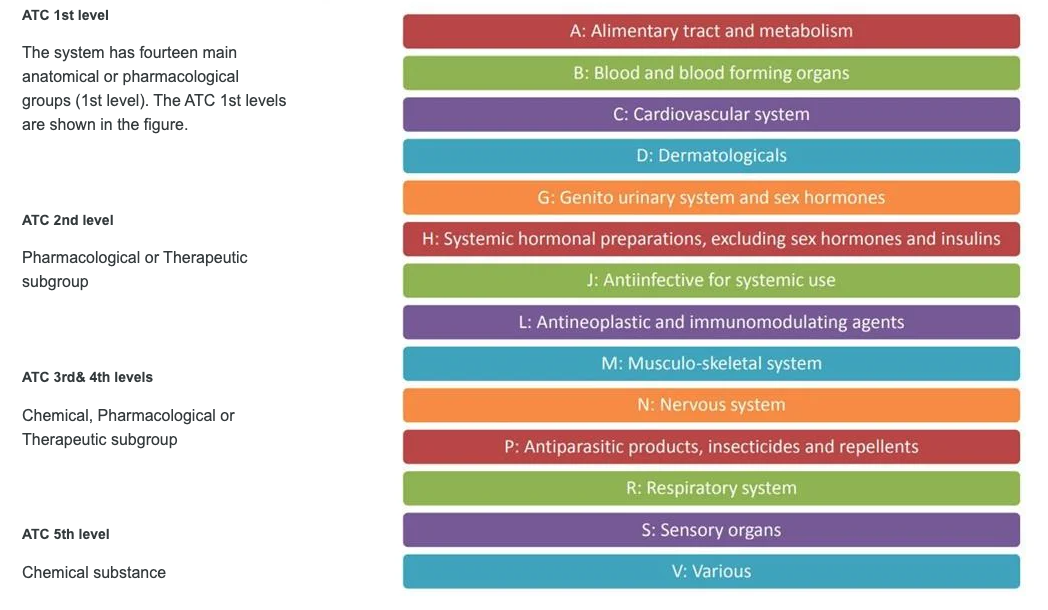

<a id='3.3.1'></a>
<h1 align="left"><font size="4" color='#104E8B' > <b>  3.3.1. ATC code classification   </b><br></font></h1> 
Adding all ATC codes for each drug. 

In [187]:
#Adding ATC classes to the nodes
molecule = new_client.molecule
atc_classes = []

for drug in nodes['Drug']:
    try:
        # compute duration to execute the loop
        # get current system time
        #print("processing: ", drug)
        #drug_start = time.time()

        # Remove content within brackets
        clean_drug = re.sub(r'\s?\(.*?\)', '', drug)

        mols = molecule.filter(molecule_synonyms__molecule_synonym__iexact=clean_drug).only('atc_classifications')
        atc_classes.append('; '.join(mols[0]['atc_classifications']) if mols[0]['atc_classifications'] else '')
        #end = time.time()
        # print the time taken to execute the loop
        #processed += 1
        #print(f'Processed {processed} drugs, average processing time {(end - start)/processed}, last processing time {end - drug_start}')
    except:
        atc_classes.append('')

nodes['ATC_Classifications'] = atc_classes



In [40]:
# assume nodes is a pandas DataFrame containing 'ATC_Classifications' and 'Drug' columns
empty_cols = nodes.isnull().any()

if empty_cols['ATC_Classifications']:
    pd.options.display.max_rows = None
    print(nodes[nodes['ATC_Classifications'].isnull()][['Drug', 'ATC_Classifications']])

In [41]:
#Check for empty rows
empty_rows = nodes[nodes['ATC_Classifications'] == '']
if not empty_rows.empty:
    print(empty_rows[['Drug', 'ATC_Classifications']])

                               Drug ATC_Classifications
9                 Cocaine (topical)                    
41           Botulinum toxin type A                    
68                     Butabarbital                    
69                       Butalbital                    
111   Carbamoylcholine (ophthalmic)                    
...                             ...                 ...
1932    Methyl salicylate (topical)                    
1933           Citrus bioflavonoids                    
1935                      Cranberry                    
1937                         Papaya                    
1938            Pyrophosphoric acid                    

[312 rows x 2 columns]


In [42]:
nodes

DDInterID                 Drug        Drug_original  \
0      DDInter513        Dexamethasone        Dexamethasone   
1      DDInter997            Ivacaftor            Ivacaftor   
2     DDInter1019           Lamivudine           Lamivudine   
3      DDInter195        Betamethasone        Betamethasone   
4     DDInter1961           Zidovudine           Zidovudine   
...           ...                  ...                  ...   
1934   DDInter371  Chondroitin sulfate  Chondroitin sulfate   
1935   DDInter446            Cranberry            Cranberry   
1936   DDInter829          Glucosamine          Glucosamine   
1937  DDInter1390               Papaya               Papaya   
1938  DDInter1551  Pyrophosphoric acid  Pyrophosphoric acid   

      Units MAT Feb 2023   % Growth  Sum incl combi  Ranking Mono   \
0               401082.0   0.055232       1162374.0           75.0   
1                    0.0   0.000000             0.0            0.0   
2                 5231.0  -0.186217         57057.0          811.0   
3               294065.0   0.057563        877133.0          111.0   
4                  413.0  -0.100218          1229.0         1086.0   
...                  ...        ...             ...            ...   
1934                 0.0   0.000000             0.0            0.0   
1935                 0.0   0.000000             0.0            0.0   
1936                 0.0   0.000000             0.0            0.0   
1937                 0.0   0.000000             0.0            0.0   
1938                 0.0   0.000000             0.0            0.0   

      Ranking Combi  topical  nasal  ophthalmic  oral parenteral  \
0              44.0     True  False       False  True       True   
1               0.0    False  False       False  True              
2             463.0    False  False       False  True              
3              70.0     True  False       False  True              
4            1044.0    False  False       False  True       True   
...             ...      ...    ...         ...   ...        ...   
1934            0.0    False  False       False                    
1935            0.0    False  False       False                    
1936            0.0    False  False       False                    
1937            0.0    False  False       False                    
1938            0.0    False  False       False                    

     indication_class chirality black_box_warning availability_type  \
0      Glucocorticoid         1                                   1   
1                             2                                   1   
2           Antiviral         1                 1                 1   
3      Glucocorticoid         1                                       
4           Antiviral         1                 1                 1   
...               ...       ...               ...               ...   
1934                          1                                  -1   
1935                                                                  
1936                          1                                  -1   
1937                                                                  
1938                                                                  

     first_in_class                                ATC_Classifications  
0                    R01AD53; A01AC02; R01AD03; S02BA06; S03BA01; D...  
1                 1                                            R07AX02  
2                                                              J05AF05  
3                    D07AC01; D07XC01; H02AB01; S02BA07; S01CB04; S...  
4                                                              J05AF01  
...             ...                                                ...  
1934                                                           M01AX25  
1935                                                                    
1936                                                           M01AX05  
1937      

<a id='3.3.2'></a>
<h1 align="left"><font size="4" color='#104E8B' > <b>  3.3.2 Adding ATC1 code to the table  </b><br></font></h1> 

In [43]:
# Create a dictionary from the matching table
atc_dict = dict(zip(ATC['atc_code'], ATC['atc_name']))

# Define a function to lookup the ATC names
def lookup_names(atc_codes):
    atc_codes = atc_codes.split('; ')
    atc_codes = [code[:1] for code in atc_codes]
    atc_count = {}
    for code in atc_codes:
        if code in atc_dict:
            atc_name = atc_dict[code]
            if atc_name in atc_count:
                atc_count[atc_name] += 1
            else:
                atc_count[atc_name] = 1
    return atc_count

# Apply the function to create the new column
nodes['ATC1_names'] = nodes['ATC_Classifications'].apply(lookup_names)

In [44]:
nodes.head(2)

DDInterID           Drug  Drug_original  Units MAT Feb 2023   % Growth  \
0  DDInter513  Dexamethasone  Dexamethasone            401082.0   0.055232   
1  DDInter997      Ivacaftor      Ivacaftor                 0.0   0.000000   

   Sum incl combi  Ranking Mono   Ranking Combi  topical  nasal  ophthalmic  \
0       1162374.0           75.0           44.0     True  False       False   
1             0.0            0.0            0.0    False  False       False   

   oral parenteral indication_class chirality black_box_warning  \
0  True       True   Glucocorticoid         1                     
1  True                                     2                     

  availability_type first_in_class  \
0                 1                  
1                 1              1   

                                 ATC_Classifications  \
0  R01AD53; A01AC02; R01AD03; S02BA06; S03BA01; D...   
1                                            R07AX02   

                                          ATC1_names  
0  {'RESPIRATORY SYSTEM': 2, 'ALIMENTARY TRACT AN...  
1                          {'RESPIRATORY SYSTEM': 1}

In [45]:
#Without the warning
# Step 1: Create a set of all unique ATC1 names
unique_atc_names = set()
for row in nodes.itertuples():
    unique_atc_names.update(row.ATC1_names.keys())

# Step 2: Create a new DataFrame with all the new columns
new_cols = {}
for atc_name in unique_atc_names:
    col_name = atc_name.replace(' ', '_')
    new_cols[col_name] = nodes.apply(lambda row: row.ATC1_names.get(atc_name, 0), axis=1)

# Combine the new columns with the original DataFrame
nodes = pd.concat([nodes, pd.DataFrame(new_cols)], axis=1)

# Drop the original ATC1_names column
#nodes = nodes.drop(columns=['ATC1_names'])



In [46]:
nodes.columns

Index(['DDInterID', 'Drug', 'Drug_original', 'Units MAT Feb 2023', ' % Growth',
       'Sum incl combi', 'Ranking Mono ', 'Ranking Combi', 'topical', 'nasal',
       'ophthalmic', 'oral', 'parenteral', 'indication_class', 'chirality',
       'black_box_warning', 'availability_type', 'first_in_class',
       'ATC_Classifications', 'ATC1_names', 'SENSORY_ORGANS',
       'DERMATOLOGICALS',
       'SYSTEMIC_HORMONAL_PREPARATIONS,_EXCL._SEX_HORMONES_AND_INSULINS',
       'ANTIPARASITIC_PRODUCTS,_INSECTICIDES_AND_REPELLENTS',
       'CARDIOVASCULAR_SYSTEM', 'ANTINEOPLASTIC_AND_IMMUNOMODULATING_AGENTS',
       'GENITO_URINARY_SYSTEM_AND_SEX_HORMONES', 'MUSCULO-SKELETAL_SYSTEM',
       'RESPIRATORY_SYSTEM', 'NERVOUS_SYSTEM',
       'ALIMENTARY_TRACT_AND_METABOLISM', 'ANTIINFECTIVES_FOR_SYSTEMIC_USE',
       'BLOOD_AND_BLOOD_FORMING_ORGANS', 'VARIOUS'],
      dtype='object')

<a id='3.3.3'></a>
<h1 align="left"><font size="4" color='#104E8B' > <b>  3.3.3 Adding ATC2 code to the table  </b><br></font></h1>
Since we add 88 more columns with ATC2 code, we will work with the ATC1 and ATC2 for the moment  

In [47]:
def lookup_atc2(atc_codes):
    atc_codes = atc_codes.split('; ')
    atc2_codes = []
    for code in atc_codes:
        if code[:3] in atc_dict:
            atc_name = atc_dict[code[:3]]
            if atc_name.startswith('V') or atc_name.startswith('M'):
                continue
            atc2_codes.append(f'{code[:3]} - {atc_name}')
    return '; '.join(atc2_codes)

# Add the new ATC2 column
nodes['ATC2_names'] = nodes['ATC_Classifications'].apply(lookup_atc2)


In [48]:
def lookup_names_with_prefix(atc_codes):
    atc_codes = atc_codes.split('; ')
    atc_dict_with_prefix = {}
    for code in atc_codes:
        if code[:3] in atc_dict:
            atc_dict_with_prefix[code[:3] + ' - ' + atc_dict[code[:3]]] = 1
    return atc_dict_with_prefix

# Add the new ATC2 column
nodes['ATC2_names'] = nodes['ATC_Classifications'].apply(lookup_names_with_prefix)


In [49]:
pd.set_option('display.max_columns', None)
nodes.head(3)

DDInterID           Drug  Drug_original  Units MAT Feb 2023   % Growth  \
0   DDInter513  Dexamethasone  Dexamethasone            401082.0   0.055232   
1   DDInter997      Ivacaftor      Ivacaftor                 0.0   0.000000   
2  DDInter1019     Lamivudine     Lamivudine              5231.0  -0.186217   

   Sum incl combi  Ranking Mono   Ranking Combi  topical  nasal  ophthalmic  \
0       1162374.0           75.0           44.0     True  False       False   
1             0.0            0.0            0.0    False  False       False   
2         57057.0          811.0          463.0    False  False       False   

   oral parenteral indication_class chirality black_box_warning  \
0  True       True   Glucocorticoid         1                     
1  True                                     2                     
2  True                   Antiviral         1                 1   

  availability_type first_in_class  \
0                 1                  
1                 1              1   
2                 1                  

                                 ATC_Classifications  \
0  R01AD53; A01AC02; R01AD03; S02BA06; S03BA01; D...   
1                                            R07AX02   
2                                            J05AF05   

                                          ATC1_names  SENSORY_ORGANS  \
0  {'RESPIRATORY SYSTEM': 2, 'ALIMENTARY TRACT AN...               4   
1                          {'RESPIRATORY SYSTEM': 1}               0   
2             {'ANTIINFECTIVES FOR SYSTEMIC USE': 1}               0   

   DERMATOLOGICALS  \
0                3   
1                0   
2                0   

   SYSTEMIC_HORMONAL_PREPARATIONS,_EXCL._SEX_HORMONES_AND_INSULINS  \
0                                                  1                 
1                                                  0                 
2                                                  0                 

   ANTIPARASITIC_PRODUCTS,_INSECTICIDES_AND_REPELLENTS  CARDIOVASCULAR_SYSTEM  \
0                                                  0                        1   
1                                                  0                        0   
2                                                  0                        0   

   ANTINEOPLASTIC_AND_IMMUNOMODULATING_AGENTS  \
0                                           0   
1                                           0   
2                                           0   

   GENITO_URINARY_SYSTEM_AND_SEX_HORMONES  MUSCULO-SKELETAL_SYSTEM  \
0                                       0                        0   
1                                       0                        0   
2                                       0                        0   

   RESPIRATORY_SYSTEM  NERVOUS_SYSTEM  ALIMENTARY_TRACT_AND_METABOLISM  \
0                   2               0                                1   
1                   1               0                                0   
2                   0               0                                0   

   ANTIINFECTIVES_FOR_SYSTEMIC_USE  BLOOD_AND_BLOOD_FORMING_ORGANS  VARIOUS  \
0                                0                               0        0   
1                                0                               0        0   
2                                1                               0        0   

                                          ATC2_names  
0  {'R01 - NASAL PREPARATIONS': 1, 'A01 - STOMATO...  
1     {'R07 - OTHER RESPIRATORY SYSTEM PRODUCTS': 1}  
2           {'J05 - ANTIVIRALS FOR SYSTEMIC USE': 1}

In [50]:
# Step 1: Create a dictionary of all unique ATC2 names with prefixes
unique_atc_names_with_prefix = {}
for row in nodes.itertuples():
    unique_atc_names_with_prefix.update(row.ATC2_names)

# Step 2: Create new columns for each unique ATC2 name with prefix
for atc_name in unique_atc_names_with_prefix:
    nodes[atc_name.replace(' ', '_')] = 0

# Step 3: Fill the new columns with the corresponding values from the ATC_Classifications column
for row in nodes.itertuples():
    for atc_name in row.ATC2_names:
        nodes.at[row.Index, atc_name.replace(' ', '_')] = 1

# Drop the original ATC_Classifications column
#nodes_test = nodes.drop(columns=['ATC2_names'])


In [51]:
nodes.columns

Index(['DDInterID', 'Drug', 'Drug_original', 'Units MAT Feb 2023', ' % Growth',
       'Sum incl combi', 'Ranking Mono ', 'Ranking Combi', 'topical', 'nasal',
       ...
       'V09_-_DIAGNOSTIC_RADIOPHARMACEUTICALS', 'H03_-_THYROID_THERAPY',
       'B03_-_ANTIANEMIC_PREPARATIONS', 'D09_-_MEDICATED_DRESSINGS',
       'D03_-_PREPARATIONS_FOR_TREATMENT_OF_WOUNDS_AND_ULCERS',
       'D02_-_EMOLLIENTS_AND_PROTECTIVES', 'J07_-_VACCINES',
       'A09_-_DIGESTIVES,_INCL._ENZYMES', 'V06_-_GENERAL_NUTRIENTS',
       'H04_-_PANCREATIC_HORMONES'],
      dtype='object', length=123)

In [52]:
# Replace commas and semicolons with pipes
nodes = nodes.replace([';'], ',', regex=True)

In [53]:
#export to csv with '|' as delimiter
nodes.to_csv('/Users/stephaniegessler/IE Students/Term 3 - Data Dynamos - General/Social Network Analysis/drugs/nodes.csv', index=False, sep=';')

<a id='4'></a>
<h1 align="left"><font size="5" color='#104E8B' > <b>  4. Graph Statistics </b><br></font></h1> 

<a id='4.1'></a>
<h1 align="left"><font size="4" color='#104E8B' > <b>  4.1 Graph Summary </b><br></font></h1> 

In [93]:
import pandas as pd
# import data from csv nodes file
nodes = pd.read_csv('/Users/stephaniegessler/IE Students/Term 3 - Data Dynamos - General/Social Network Analysis/drugs/nodes.csv', sep=';')
edges = pd.read_csv('/Users/stephaniegessler/IE Students/Term 3 - Data Dynamos - General/Social Network Analysis/drugs/edges.csv', sep=';')

In [94]:
# Replace all NANs with zero in table nodes 
nodes = nodes.fillna(0)

In [95]:
edges

DDInterID_A              Drug_A  DDInterID_B                   Drug_B  \
0        DDInter513       Dexamethasone   DDInter582             Dolutegravir   
1        DDInter997           Ivacaftor   DDInter582             Dolutegravir   
2       DDInter1019          Lamivudine  DDInter1123                 Mannitol   
3        DDInter195       Betamethasone  DDInter1961               Zidovudine   
4       DDInter1961          Zidovudine   DDInter246               Budesonide   
...             ...                 ...          ...                      ...   
160230   DDInter856             Heparin   DDInter805  gamma-Aminobutyric acid   
160231  DDInter1683  Sodium bicarbonate   DDInter805  gamma-Aminobutyric acid   
160232   DDInter908            Iloprost    DDInter62              Ambrisentan   
160233  DDInter1951            Warfarin  DDInter1942                Vitamin D   
160234  DDInter1683  Sodium bicarbonate  DDInter1942                Vitamin D   

           Level  Weight  
0          Minor       3  
1          Minor       3  
2       Moderate       2  
3       Moderate       2  
4       Moderate       2  
...          ...     ...  
160230   Unknown       2  
160231   Unknown       2  
160232   Unknown       2  
160233   Unknown       2  
160234   Unknown       2  

[160235 rows x 6 columns]

Checking the distribution of the Weights, where you can observe that moderate has the highest interaction weights. 

<AxesSubplot: xlabel='Level', ylabel='count'>

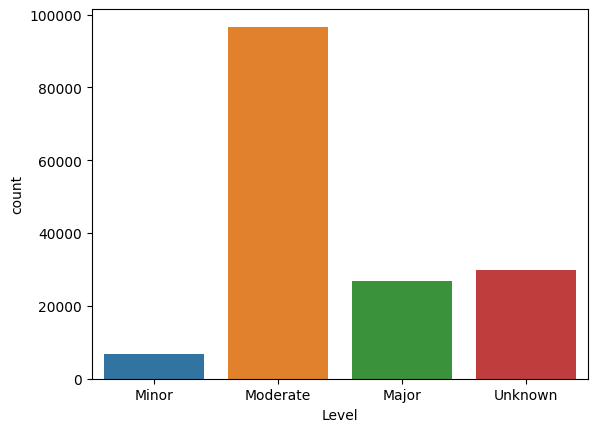

In [91]:
import seaborn as sns
# Create a countplot of the Level column
sns.countplot(x='Level', data=edges)

In [71]:
#create graph with networkx weighted 
G = nx.from_pandas_edgelist(edges, 'DDInterID_A', 'DDInterID_B', 'Weight', create_using=nx.Graph())

#add all attributes from nodes to graph
#nx.set_node_attributes(G, nodes.set_index('Drug_original').to_dict('index'))
node_dict = {d.pop('Drug_original'): d for d in nodes.to_dict('records')}
nx.set_node_attributes(G, node_dict)

Checking the Graph summary, we have 1939 nodes and 160235 Edges, 

In [149]:
print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())

Number of nodes: 1939
Number of edges: 160235


We have 3 Subgraphs.

In [79]:
# get all the subgraphs
subgraphs = nx.connected_components(G)

# get the count of subgraphs
subgraph_count = len(list(subgraphs))

print("Subgraph count:", subgraph_count)


Subgraph count: 3


<a id='4.2'></a>
<h1 align="left"><font size="4" color='#104E8B' > <b>  4.2 ATC Graphics and Distribution </b><br></font></h1> 
<h1 align="left"><font size="3" color='#008B8B' > <b>  ATC1 Distribution </b><br></font></h1> 

Checking the distribution of the drugs, where nervous system has the highest distribution with 319 drug, then Antineoplastic second 298 drugs and third Alimentary Tract and Metabalism with 273 drugs. 

In [59]:
import plotly.graph_objs as go

# Define the mapping between column names and labels
col_to_label = {'RESPIRATORY_SYSTEM': 'R',
                'CARDIOVASCULAR_SYSTEM': 'C',
                'ANTIPARASITIC_PRODUCTS,_INSECTICIDES_AND_REPELLENTS': 'P',
                'BLOOD_AND_BLOOD_FORMING_ORGANS': 'B',
                'MUSCULO-SKELETAL_SYSTEM': 'M',
                'ANTINEOPLASTIC_AND_IMMUNOMODULATING_AGENTS': 'L',
                'DERMATOLOGICALS': 'D',
                'GENITO_URINARY_SYSTEM_AND_SEX_HORMONES': 'G',
                'SYSTEMIC_HORMONAL_PREPARATIONS,_EXCL._SEX_HORMONES_AND_INSULINS': 'H',
                'SENSORY_ORGANS': 'S',
                'VARIOUS': 'V',
                'ALIMENTARY_TRACT_AND_METABOLISM': 'A',
                'ANTIINFECTIVES_FOR_SYSTEMIC_USE': 'J',
                'NERVOUS_SYSTEM': 'N'}

# Define the colors for each column
colors = ['blue', 'red', 'green', 'purple', 'orange', 'gray', 'pink', 'brown', 'teal', 'olive', 'navy', 'maroon', 'cyan', 'magenta']

# Sort the columns by their sum in descending order
nodes2 = nodes.iloc[:, 20:-89].assign(total=nodes.iloc[:, 20:-89].sum(axis=1)).sort_values('total', ascending=False).drop('total', axis=1)

# Create the bar chart
fig = go.Figure()
for i, col in enumerate(nodes2.columns):
    fig.add_trace(go.Bar(x=[nodes2[col].sum()], y=[col_to_label[col]], name=col, orientation='h', marker_color=colors[i], text=[nodes2[col].sum()], textposition='outside'))

# Set the title and axis labels
fig.update_layout(title='Sum of values for each system', xaxis_title='Sum', yaxis_title='System', yaxis_categoryorder='total ascending')

# Update the legend
#fig.update_layout(legend=dict(title='ATC Classifications', orientation='h', yanchor='top', y=1.05, xanchor='left', x=0.1))

# Set the title and axis labels
fig.update_layout(title='Sum of each Drug per ATC1', xaxis_title='Sum', yaxis_title='System',
                  legend=dict(yanchor="top", y=0.99, xanchor="right", x=1.8))

# Show the plot
fig.show()



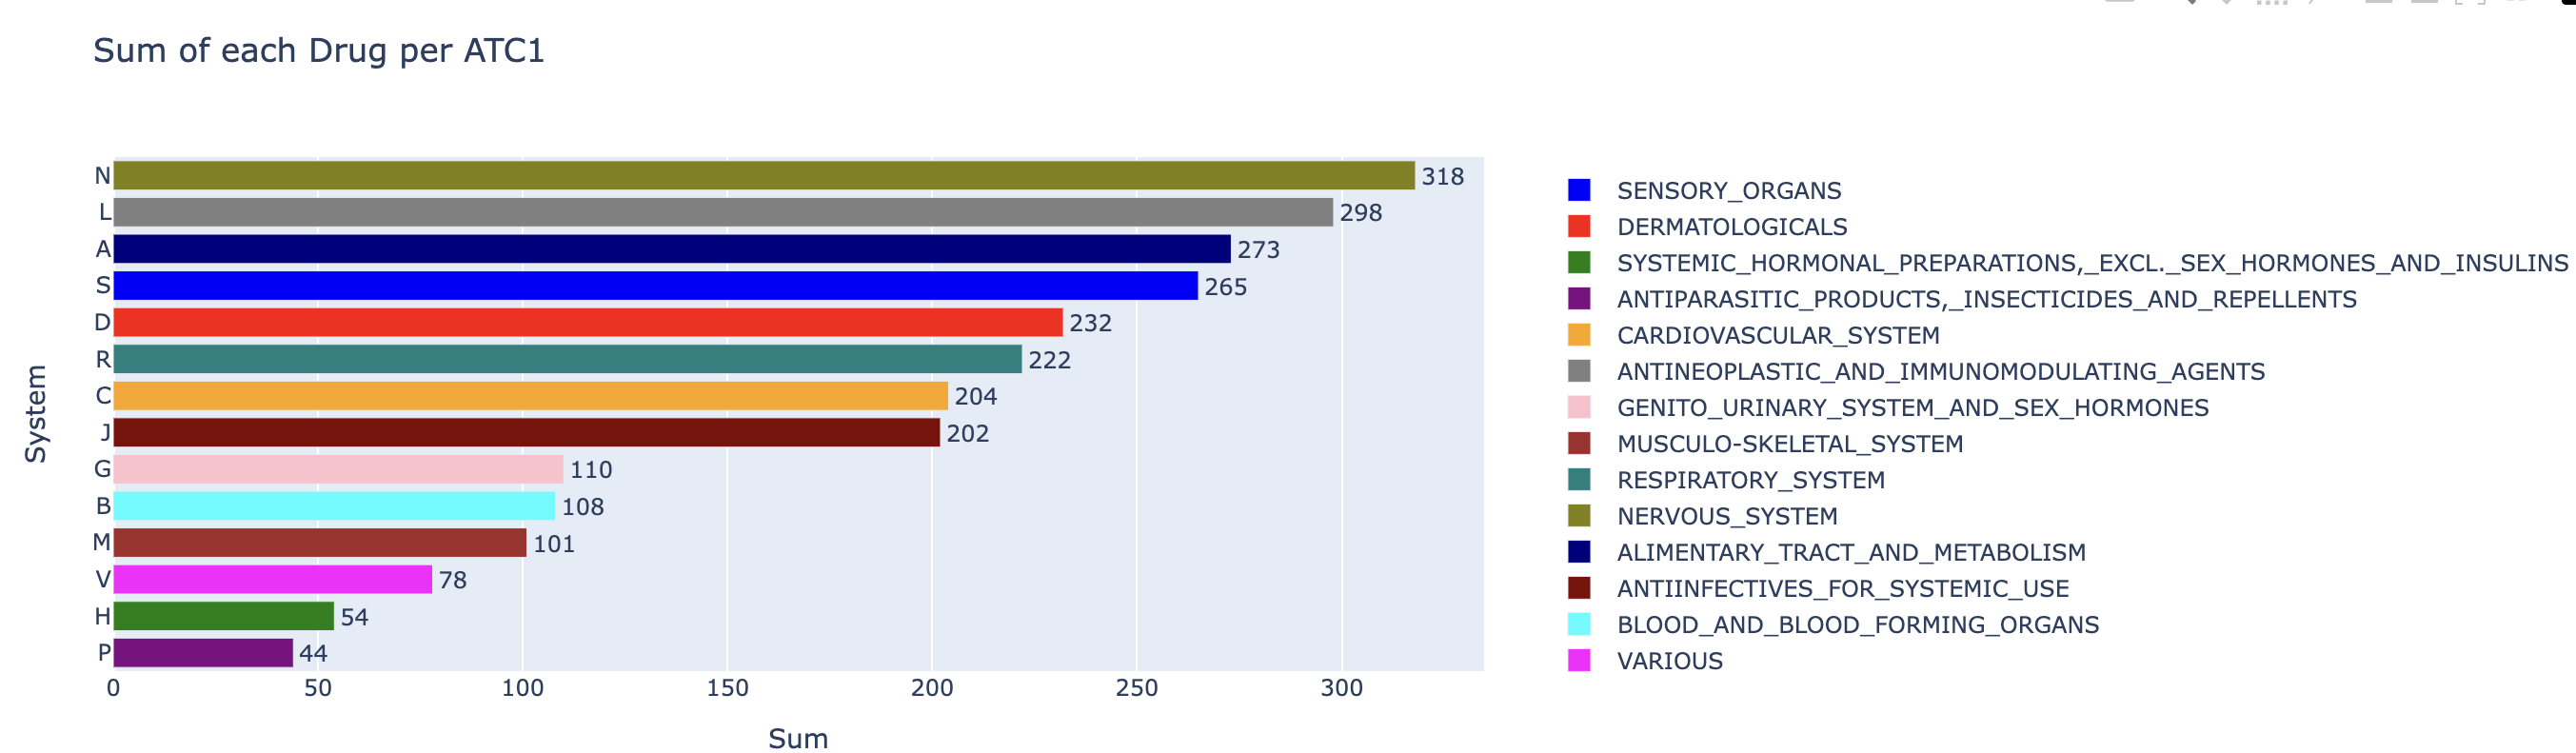

<h1 align="left"><font size="3" color='#008B8B' > <b>  Top 10 ATC2 Distribution </b><br></font></h1> 

The highest Drug Distribution is under the Therapeutic area: Antineoplastic Agents, then Ophtalmologicals and then Antibacterials for Systemic use. 

In [60]:
import plotly.graph_objs as go

# Define the colors for each column
colors = ['blue', 'red', 'green', 'purple', 'orange', 'gray', 'pink', 'brown', 'teal', 'olive', 'navy', 'maroon', 'cyan', 'magenta']

# Get the top 20 columns
top_columns = nodes.iloc[:, 35:].sum(axis=0).sort_values(ascending=False).head(10)

# Create the bar chart
fig = go.Figure()
for i, col in enumerate(top_columns.index):
    fig.add_trace(go.Bar(x=[top_columns[col]], y=[col], name=col, orientation='h', marker_color=colors[i%len(colors)], text=[top_columns[col]], textposition='outside'))

# Set the title and axis labels
fig.update_layout(title='Top 10 ATC2 Classifications', xaxis_title='Total Number of Molecules', yaxis_title='ATC2 Classidication')

# Show the plot
fig.show()



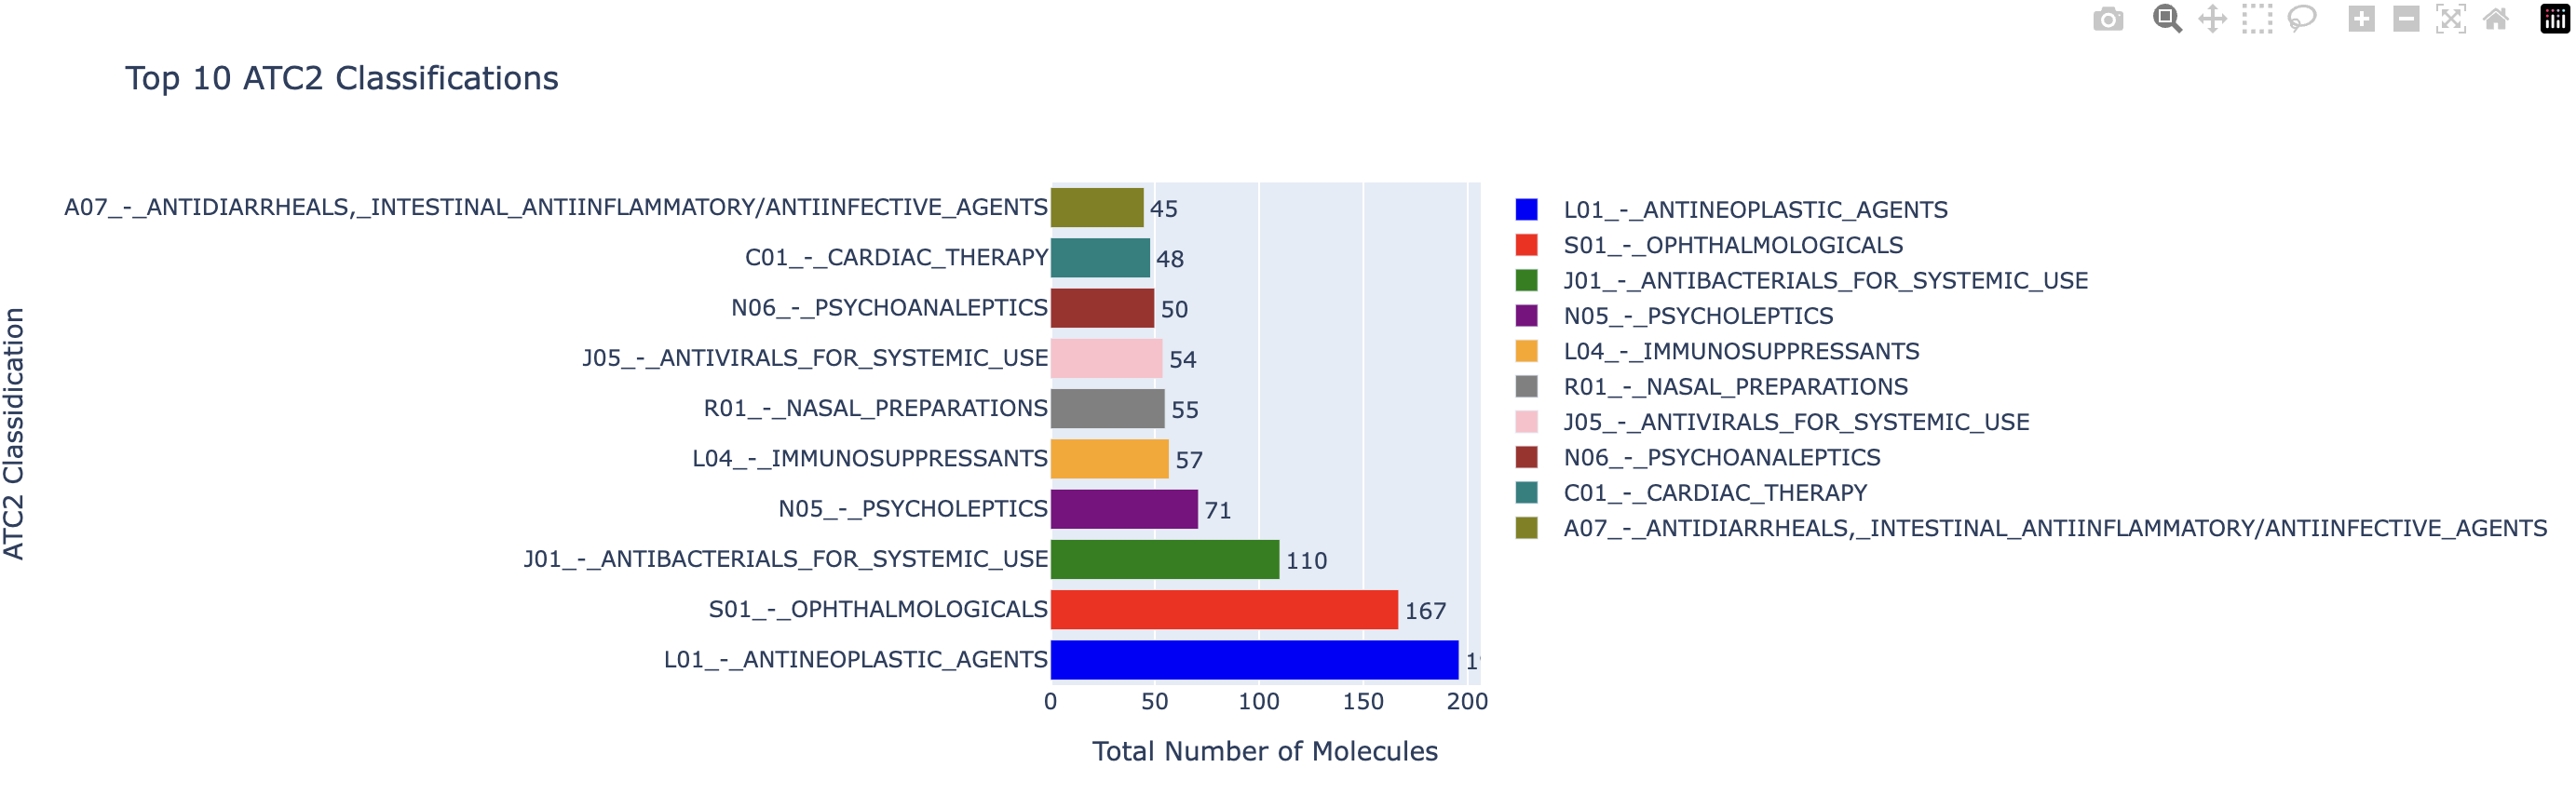

In [75]:
# Get the subgraphs
subgraphs = nx.connected_components(G)

<font color='#008B8B'>__Diameter__</font>

In [84]:
# Check if the graph is connected
if not nx.is_connected(G):
    # If not, get the connected components and calculate the diameter of each component
    subgraphs = list(nx.connected_components(G))
    for i, sg in enumerate(subgraphs):
        try:
            diameter = nx.algorithms.distance_measures.diameter(G.subgraph(sg))
            print(f"Diameter of subgraph {i+1}: {diameter}")
        except nx.exception.NetworkXError as e:
            print(f"Subgraph {i+1} is not connected, so it does not have a diameter")
else:
    # If connected, calculate the diameter of the entire graph
    try:
        diameter = nx.algorithms.distance_measures.diameter(G)
        print(f"The diameter of the graph is {diameter}")
    except nx.exception.NetworkXError as e:
        print("The graph is not connected, so it does not have a diameter")


Diameter of subgraph 1: 7
Diameter of subgraph 2: 2
Diameter of subgraph 3: 1


<a id='5.3'></a>
<h1 align="left"><font size="5" color='#104E8B' > <b>  5.3 Pagerank  </b><br></font></h1> 

The diameter of a graph is the maximum distance between any two pairs of nodes in the graph. In this case, a diameter of 7 means that the longest shortest path between any two nodes in your graph is 7. The other are very short and not densely connected graph with a diameter of 2 and 1 respectivley. 

This information can be useful for understanding the overall structure and connectedness of your graph. A small diameter (shortest path between any two nodes) indicates that the graph is well connected, whereas a large diameter may indicate that there are some isolated nodes or subgraphs within the graph.

In [85]:
# Check if the graph is connected
if not nx.is_connected(G):
    # If not, get the connected components and calculate the average shortest path, max and min degree of each component
    subgraphs = list(nx.connected_components(G))
    for i, sg in enumerate(subgraphs):
        # Calculate average shortest path length
        shortest_path_avg = nx.average_shortest_path_length(G.subgraph(sg))
        print(f"Shortest average path length of subgraph {i+1}: {shortest_path_avg}")
        
        # Calculate max and min degree
        max_degree = max(dict(G.subgraph(sg).degree()).values())
        min_degree = min(dict(G.subgraph(sg).degree()).values())
        print(f"Maximum degree of subgraph {i+1}: {max_degree}")
        print(f"Minimum degree of subgraph {i+1}: {min_degree}")
else:
    # If connected, calculate the shortest average path, max and min degree of the entire graph
    shortest_path_avg = nx.average_shortest_path_length(G)
    print(f"The shortest average path length is {shortest_path_avg}")
    
    max_degree = max(dict(G.degree()).values())
    min_degree = min(dict(G.degree()).values())
    print(f"Maximum degree of the graph: {max_degree}")
    print(f"Minimum degree of the graph: {min_degree}")


Shortest average path length of subgraph 1: 2.180150876492809
Maximum degree of subgraph 1: 910
Minimum degree of subgraph 1: 1
Shortest average path length of subgraph 2: 1.3333333333333333
Maximum degree of subgraph 2: 2
Minimum degree of subgraph 2: 1
Shortest average path length of subgraph 3: 1.0
Maximum degree of subgraph 3: 1
Minimum degree of subgraph 3: 1


The first set of results pertains to subgraph 1, which has an average shortest path length of 2.18. This suggests that, on average, it takes 2.18 steps to get from one node in subgraph 1 to another node in the same subgraph. The maximum degree of subgraph 1 is 910, which means that at least one node in subgraph 1 has 910 connections. The minimum degree of subgraph 1 is 1, indicating that there is at least one node in subgraph 1 with only one connection.

The second set of results relates to subgraph 2, which has an average shortest path length of 1.33. This indicates that it takes only 1.33 steps on average to get from one node to another node in subgraph 2. The maximum degree of subgraph 2 is 2, meaning that no node in subgraph 2 has more than two connections. The minimum degree of subgraph 2 is also 1, suggesting that there is at least one node in subgraph 2 with only one connection.

Finally, the third set of results pertains to subgraph 3, which has an average shortest path length of 1.0. This means that it takes only one step to get from any node in subgraph 3 to any other node in the same subgraph. The maximum degree of subgraph 3 is 1, indicating that every node in subgraph 3 has only one connection. The minimum degree of subgraph 3 is also 1, implying that every node in subgraph 3 has at least one connection.

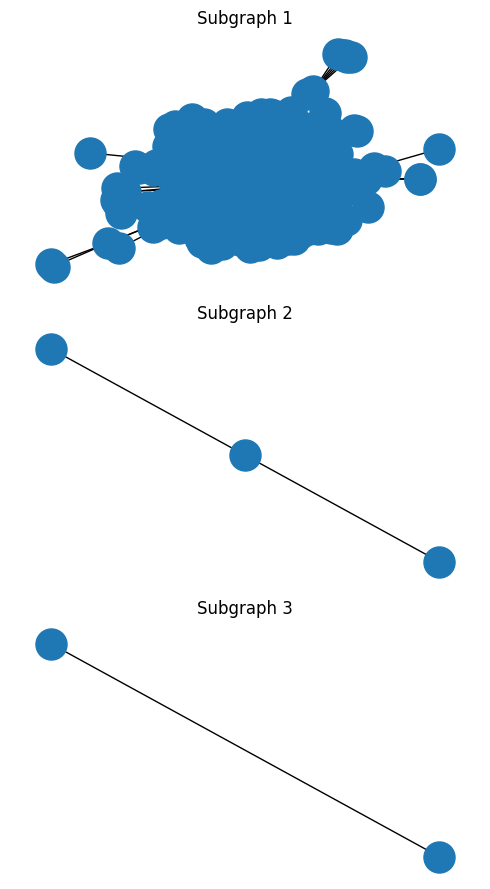

In [87]:
# get the connected components
subgraphs = list(nx.connected_components(G))

# plot each subgraph vertically
fig, axs = plt.subplots(len(subgraphs), 1, figsize=(5, 3*len(subgraphs)))
for i, sg in enumerate(subgraphs):
    axs[i].set_title(f"Subgraph {i+1}")
    sg = G.subgraph(sg)
    pos = nx.spring_layout(sg)
    nx.draw(sg, pos, ax=axs[i], node_size=500)

plt.tight_layout()
plt.show()

In [102]:
# Map the subgraphs in the nodes DataFrame
subgraph_dict = {}
for i, subgraph in enumerate(nx.connected_components(G)):
    for node in subgraph:
        subgraph_dict[node] = i+1

nodes['subgraph'] = nodes['DDInterID'].map(subgraph_dict)


In [103]:
# show all columns
pd.set_option('display.max_columns', None)
nodes.head(2)

DDInterID           Drug  Drug_original  Units MAT Feb 2023   % Growth  \
0  DDInter513  Dexamethasone  Dexamethasone            401082.0   0.055232   
1  DDInter997      Ivacaftor      Ivacaftor                 0.0   0.000000   

   Sum incl combi  Ranking Mono   Ranking Combi  topical  nasal  ophthalmic  \
0       1162374.0           75.0           44.0     True  False       False   
1             0.0            0.0            0.0    False  False       False   

   oral parenteral indication_class  chirality  black_box_warning  \
0  True       True   Glucocorticoid        1.0                0.0   
1  True          0                0        2.0                0.0   

   availability_type  first_in_class  \
0                1.0             0.0   
1                1.0             1.0   

                                 ATC_Classifications  \
0  R01AD53, A01AC02, R01AD03, S02BA06, S03BA01, D...   
1                                            R07AX02   

                                          ATC1_names  SENSORY_ORGANS  \
0  {'RESPIRATORY SYSTEM': 2, 'ALIMENTARY TRACT AN...               4   
1                          {'RESPIRATORY SYSTEM': 1}               0   

   DERMATOLOGICALS  \
0                3   
1                0   

   SYSTEMIC_HORMONAL_PREPARATIONS,_EXCL._SEX_HORMONES_AND_INSULINS  \
0                                                  1                 
1                                                  0                 

   ANTIPARASITIC_PRODUCTS,_INSECTICIDES_AND_REPELLENTS  CARDIOVASCULAR_SYSTEM  \
0                                                  0                        1   
1                                                  0                        0   

   ANTINEOPLASTIC_AND_IMMUNOMODULATING_AGENTS  \
0                                           0   
1                                           0   

   GENITO_URINARY_SYSTEM_AND_SEX_HORMONES  MUSCULO-SKELETAL_SYSTEM  \
0                                       0                        0   
1                                       0                        0   

   RESPIRATORY_SYSTEM  NERVOUS_SYSTEM  ALIMENTARY_TRACT_AND_METABOLISM  \
0                   2               0                                1   
1                   1               0                                0   

   ANTIINFECTIVES_FOR_SYSTEMIC_USE  BLOOD_AND_BLOOD_FORMING_ORGANS  VARIOUS  \
0                                0                               0        0   
1                                0                               0        0   

                                          ATC2_names  \
0  {'R01 - NASAL PREPARATIONS': 1, 'A01 - STOMATO...   
1     {'R07 - OTHER RESPIRATORY SYSTEM PRODUCTS': 1}   

   R01_-_NASAL_PREPARATIONS  A01_-_STOMATOLOGICAL_PREPARATIONS  \
0                         1                                  1   
1                         0                                  0   

   S02_-_OTOLOGICALS  S03_-_OPHTHALMOLOGICAL_AND_OTOLOGICAL_PREPARATIONS  \
0                  1                                                  1    
1                  0                                                  0    

   D07_-_CORTICOSTEROIDS,_DERMATOLOGICAL_PREPARATIONS  \
0                                                  1    
1                                                  0    

   D10_-_ANTI-ACNE_PREPARATIONS  S01_-_OPHTHALMOLOGICALS  \
0                             1                        1   
1                             0                        0   

   C05_-_VASOPROTECTIVES  H02_-_CORTICOSTEROIDS_FOR_SYSTEMIC_USE  \
0                      1                                       1   
1                      0                                       0   

   R07_-_OTHER_RESPIRATORY_SYSTEM_PRODUCTS  J05_-_ANTIVIRALS_FOR_SYSTEMIC_USE  \
0                                        0                                  0   
1                                        1                                  0   

   R03_-_DRUGS_FOR_OBSTRUCTIVE_AIRWAY_DISEASES  \
0                        

In [104]:
#Replace 0 with false for oral and parenteral,topical
nodes['oral'] = nodes['oral'].replace(0, False)
nodes['parenteral'] = nodes['parenteral'].replace(0, False)
nodes['topical'] = nodes['topical'].replace(0, False)


In [105]:
#show value count for oral, parenteral and topical
print(nodes['oral'].value_counts())
print(nodes['parenteral'].value_counts())
print(nodes['topical'].value_counts())


True     981
False    958
Name: oral, dtype: int64
False    1274
True      665
Name: parenteral, dtype: int64
False    1657
True      282
Name: topical, dtype: int64


<a id='5'></a>
<h1 align="left"><font size="5" color='#104E8B' > <b>  5.  Basic Graph Metrics </b><br></font></h1> 

Using the weights  __(minor interaction = 3, major = 1, unknown = 2, medium = 2)__ for centrality measures in a social network analysis of drug interactions can make sense if you want to focus on the severe drugs and avoid these. All further analysis focus only on subgraph 1. 

>Emphasizing major interactions: Assigning a lower weight (1) to major interactions means that major interactions will have a stronger influence on the centrality measures. This is because, in many centrality calculations, lower weights are interpreted as stronger connections. By prioritizing major interactions in this way, the analysis can focus on understanding and addressing the __most severe drug interactions__.

> Treating unknown and medium interactions similarly: Assigning the same weight (2) to both unknown and medium interactions indicates that the analysis considers them to have similar importance. This is a conservative approach that assumes that the severity of an unknown interaction could be similar to that of a medium interaction. By using this weighting, the analysis can avoid underestimating the potential risks of unknown interactions.

> Penalizing minor interactions: Assigning a higher weight (3) to minor interactions implies that these interactions will have a weaker influence on the centrality measures. In many contexts, minor interactions may not be as concerning as major or medium interactions. By giving them a higher weight, the analysis can focus more on the more severe interactions that may pose a greater risk to patients.

Use cases where this weighting scheme might be beneficial include:

- Identifying drugs with high potential for severe interactions: Healthcare providers and researchers can use these centrality measures to identify drugs that are more likely to have major interactions with other drugs. This information can guide decision-making in prescribing medications and help prevent adverse drug events.

- Drug development and clinical trial design: Pharmaceutical companies can use these weights to understand potential drug interactions and identify areas for improvement during drug development. This knowledge can also help in designing clinical trials, as researchers can be more cautious when combining drugs with high potential for major interactions.

- Pharmacovigilance and drug safety monitoring: Regulatory agencies can use these centrality measures to monitor drug safety, prioritize drugs for further investigation, and develop strategies for managing potential drug interactions.

In summary, using the specified weights for centrality measures can help prioritize major drug interactions and handle unknown interactions conservatively, making it useful in various healthcare and pharmaceutical contexts. However, it is essential to consider the specific research question and context when choosing weights, as other weighting schemes might be more appropriate depending on the goals of the analysis.

In [106]:
# calculate and add closeness centrality to nodes dataframe
closeness_centrality = nx.closeness_centrality(G)
nodes['closeness_centrality'] = nodes['DDInterID'].apply(lambda x: closeness_centrality[x])

# calculate and add weighted closeness centrality to nodes dataframe
weighted_closeness_centrality = nx.closeness_centrality(G, distance='Weight')
nodes['weighted_closeness_centrality'] = nodes['DDInterID'].apply(lambda x: weighted_closeness_centrality[x])


# calculate and add betweenness centrality to nodes dataframe
betweenness_centrality = nx.betweenness_centrality(G)
nodes['betweenness_centrality'] = nodes['DDInterID'].apply(lambda x: betweenness_centrality[x])

# calculate and add weighted betweenness centrality to nodes dataframe
weighted_betweenness_centrality = nx.betweenness_centrality(G, weight='Weight')
nodes['weighted_betweenness_centrality'] = nodes['DDInterID'].apply(lambda x: weighted_betweenness_centrality[x])

# calculate and add PageRank to nodes dataframe
pagerank = nx.pagerank(G)
nodes['pagerank'] = nodes['DDInterID'].apply(lambda x: pagerank[x])

# calculate and add weighted PageRank to nodes dataframe
weighted_pagerank = nx.pagerank(G, weight='Weight')
nodes['weighted_pagerank'] = nodes['DDInterID'].apply(lambda x: weighted_pagerank[x])

# calculate and add degree centrality to nodes dataframe
degree_centrality = nx.degree_centrality(G)
nodes['degree_centrality'] = nodes['DDInterID'].apply(lambda x: betweenness_centrality[x])

# calculate and add degree to nodes dataframe
degree = nx.degree(G)
nodes['degree'] = nodes['DDInterID'].apply(lambda x: degree[x])


#calculate and add eigenvector centrality to nodes dataframe
eigenvector_centrality = nx.eigenvector_centrality(G)
nodes['eigenvector_centrality'] = nodes['DDInterID'].apply(lambda x: eigenvector_centrality[x])

#calculate and add weighted eigenvector centrality to nodes dataframe
weighted_eigenvector_centrality = nx.eigenvector_centrality(G, weight='Weight')
nodes['weighted_eigenvector_centrality'] = nodes['DDInterID'].apply(lambda x: weighted_eigenvector_centrality[x])


#calculate and add clustering coefficient to nodes dataframe
clustering_coefficient = nx.clustering(G)
nodes['clustering_coefficient'] = nodes['DDInterID'].apply(lambda x: clustering_coefficient[x])

#calculate and add weighted clustering coefficient to nodes dataframe
weighted_clustering_coefficient = nx.clustering(G, weight='Weight')
nodes['weighted_clustering_coefficient'] = nodes['DDInterID'].apply(lambda x: weighted_clustering_coefficient[x])


In [ ]:
nodes.head(2)

DDInterID           Drug  Drug_original  Units MAT Feb 2023   % Growth  \
0  DDInter513  Dexamethasone  Dexamethasone            401082.0   0.055232   
1  DDInter997      Ivacaftor      Ivacaftor                 0.0   0.000000   

   Sum incl combi  Ranking Mono   Ranking Combi  topical  nasal  ophthalmic  \
0       1162374.0           75.0           44.0     True  False       False   
1             0.0            0.0            0.0    False  False       False   

   oral parenteral indication_class  chirality  black_box_warning  \
0  True       True   Glucocorticoid        1.0                0.0   
1  True          0                0        2.0                0.0   

   availability_type  first_in_class  \
0                1.0             0.0   
1                1.0             1.0   

                                 ATC_Classifications  \
0  R01AD53, A01AC02, R01AD03, S02BA06, S03BA01, D...   
1                                            R07AX02   

                                          ATC1_names  \
0  {'RESPIRATORY SYSTEM': 2, 'ALIMENTARY TRACT AN...   
1                          {'RESPIRATORY SYSTEM': 1}   

   ANTIINFECTIVES_FOR_SYSTEMIC_USE  RESPIRATORY_SYSTEM  \
0                                0                   2   
1                                0                   1   

   ANTIPARASITIC_PRODUCTS,_INSECTICIDES_AND_REPELLENTS  \
0                                                  0     
1                                                  0     

   ANTINEOPLASTIC_AND_IMMUNOMODULATING_AGENTS  MUSCULO-SKELETAL_SYSTEM  \
0                                           0                        0   
1                                           0                        0   

   ALIMENTARY_TRACT_AND_METABOLISM  BLOOD_AND_BLOOD_FORMING_ORGANS  \
0                                1                               0   
1                                0                               0   

   SENSORY_ORGANS  \
0               4   
1               0   

   SYSTEMIC_HORMONAL_PREPARATIONS,_EXCL._SEX_HORMONES_AND_INSULINS  \
0                                                  1                 
1                                                  0                 

   NERVOUS_SYSTEM  GENITO_URINARY_SYSTEM_AND_SEX_HORMONES  DERMATOLOGICALS  \
0               0                                       0                3   
1               0                                       0                0   

   VARIOUS  CARDIOVASCULAR_SYSTEM  \
0        0                      1   
1        0                      0   

                                          ATC2_names  \
0  {'R01 - NASAL PREPARATIONS': 1, 'A01 - STOMATO...   
1     {'R07 - OTHER RESPIRATORY SYSTEM PRODUCTS': 1}   

   R01_-_NASAL_PREPARATIONS  A01_-_STOMATOLOGICAL_PREPARATIONS  \
0                         1                                  1   
1                         0                                  0   

   S02_-_OTOLOGICALS  S03_-_OPHTHALMOLOGICAL_AND_OTOLOGICAL_PREPARATIONS  \
0                  1                                                  1    
1                  0                                                  0    

   D07_-_CORTICOSTEROIDS,_DERMATOLOGICAL_PREPARATIONS  \
0                                                  1    
1                                                  0    

   D10_-_ANTI-ACNE_PREPARATIONS  S01_-_OPHTHALMOLOGICALS  \
0                             1                        1   
1                             0                        0   

   C05_-_VASOPROTECTIVES  H02_-_CORTICOSTEROIDS_FOR_SYSTEMIC_USE  \
0                      1                                       1   
1                      0                                       0   

   R07_-_OTHER_RESPIRATORY_SYSTEM_PRODUCTS  J05_-_ANTIVIRALS_FOR_SYSTEMIC_USE  \
0                                        0                                  0   
1                                        1                                  0   

   R03_-_DRUGS_FOR_OBSTRUCTIVE_AIRWAY_DISEASES  \
0        

<a id='5.1'></a>
<h1 align="left"><font size="4" color='#104E8B' > <b>  5.1 Closeness centrality  </b><br></font></h1> 

> Interpretation: A drug with high closeness centrality can quickly influence or be influenced by other drugs in the network due to its short average distance to all other drugs.
HCP Action: HCPs should be aware that a drug with high closeness centrality may have a more significant overall impact on the patient's medication regimen. They should evaluate the entire drug profile of the patient to identify and manage potential interactions.

In [109]:
# Calculate the closeness centrality for each node
cc = nx.closeness_centrality(G)

# Create a histogram of the closeness centrality values
fig = go.Figure(data=[go.Histogram(x=list(cc.values()))])

# Add labels and title to the plot
fig.update_layout(
    title="Closeness Centrality Distribution",
    xaxis_title="Closeness Centrality",
    yaxis_title="Count"
)

# Show the plot
fig.show()

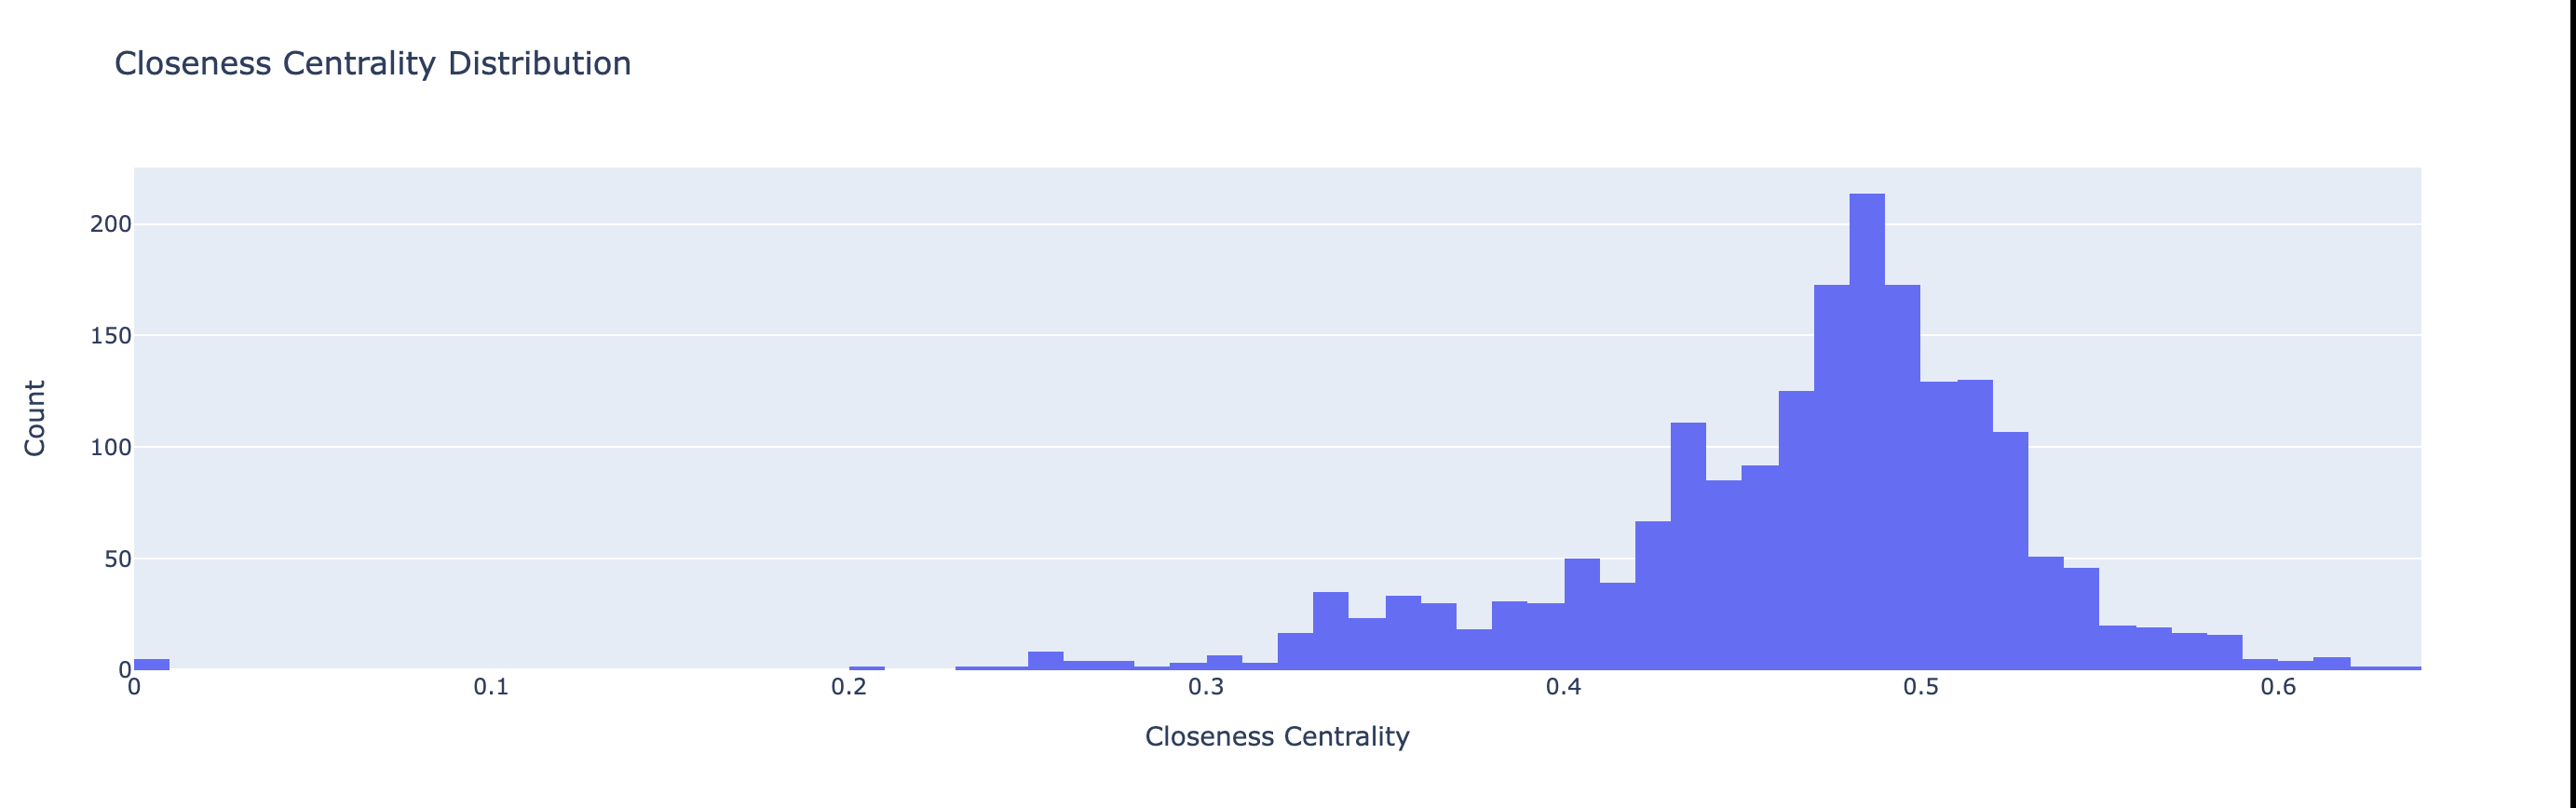

In [114]:
# Filter by subgraph 1 and sort by Top 20 closeness centrality, show columns closeness_centrality, Drug_original, Ranking Mono,Ranking Mono,oral,parenteral,indication_class,topical,chirality,availability_type,black_box_warning,first_in_class	ATC_Classification
nodes[nodes['subgraph'] == 1].sort_values('closeness_centrality', ascending=False)[['closeness_centrality', 'Drug_original', 'oral','Ranking Mono ','Ranking Combi', 'parenteral', 'indication_class', 'topical', 'chirality', 'availability_type', 'black_box_warning', 'first_in_class','ATC1_names']].head(10)

closeness_centrality   Drug_original   oral  Ranking Mono   \
0                0.635260   Dexamethasone   True           75.0   
417              0.626385      Tacrolimus   True          159.0   
580              0.624761        Warfarin   True            0.0   
37               0.618151    Promethazine   True            0.0   
409              0.613626      Prednisone   True           85.0   
698              0.613431  Clarithromycin   True          214.0   
484              0.613041    Cyclosporine   True            0.0   
239              0.611679     Thalidomide   True            0.0   
529              0.610710    Methotrexate  False           31.0   
74               0.607439     Fluconazole   True          107.0   

     Ranking Combi  parenteral             indication_class  topical  \
0             44.0        True               Glucocorticoid     True   
417          248.0        True            Immunosuppressant     True   
580            0.0        True                Anticoagulant    False   
37             0.0        True  Anti-Emetic, Antihistaminic     True   
409          157.0       False               Glucocorticoid    False   
698          307.0       False                Antibacterial    False   
484            0.0        True            Immunosuppressant     True   
239            0.0       False            Sedative-Hypnotic    False   
529           80.0       False               Antineoplastic    False   
74           188.0        True                   Antifungal    False   

     chirality  availability_type  black_box_warning  first_in_class  \
0          1.0                1.0                0.0             0.0   
417        1.0                1.0                1.0             0.0   
580        0.0                1.0                1.0             0.0   
37         0.0                1.0                1.0             0.0   
409        1.0                1.0                0.0             0.0   
698        1.0                1.0                0.0             0.0   
484        1.0                1.0                1.0             0.0   
239        0.0                1.0                1.0             0.0   
529       -1.0               -1.0                0.0            -1.0   
74         2.0                1.0                0.0             0.0   

                                            ATC1_names  
0    {'RESPIRATORY SYSTEM': 2, 'ALIMENTARY TRACT AN...  
417                                                 {}  
580              {'BLOOD AND BLOOD FORMING ORGANS': 1}  
37     {'RESPIRATORY SYSTEM': 2, 'DERMATOLOGICALS': 1}  
409  {'ALIMENTARY TRACT AND METABOLISM': 1, 'SYSTEM...  
698             {'ANTIINFECTIVES FOR SYSTEMIC USE': 1}  
484  {'SENSORY ORGANS': 1, 'ANTINEOPLASTIC AND IMMU...  
239  {'ANTINEOPLASTIC AND IMMUNOMODULATING AGENTS': 1}  
529                                                 {}  
74   {'ANTIINFECTIVES FOR SYSTEMIC USE': 1, 'DERMAT...

> The closeness centrality and weighted closeness centrality of various drugs in a network built based on drug interactions. Closeness centrality is a measure of how central a node (drug) is within the network, indicating how easily it can be reached from other nodes (drugs) in the network. The higher the closeness centrality, the more central the drug is in the network. Weighted closeness centrality takes into account the weights (interaction strength) between nodes, with lower weights indicating worse interactions.

Unweighted: 
- <font color='#008B8B'>Dexamethasone</font>  a glucocorticoid, has the highest closeness centrality (0.635260), indicating that it is the most central drug in both unweighted  networks. It is commonly used to treat a variety of inflammatory and autoimmune conditions and is also used in respiratory and alimentary tract-related treatments.

- <font color='#008B8B'>Tacrolimus</font> an immunosuppressant, has the second-highest closeness centrality (0.626385). It is mainly used to prevent organ transplant rejection and is available in both oral and parenteral forms.

- <font color='#008B8B'>Warfarin</font> an anticoagulant, has the third-highest closeness centrality (0.624761) and the fourth-highest weighted closeness centrality (0.297809). It is used to prevent blood clots and is available in oral and parenteral forms.

- <font color='#008B8B'>Promethazine</font>  an antihistaminic and anti-emetic, ranks fourth in closeness centrality (0.618151) and second in weighted closeness centrality (0.300407). It is used for treating allergic reactions, nausea, and vomiting.

Weighted:

- <font color='#008B8B'>Ozanimod</font> has the highest weighted closeness centrality score, which means it is the most central drug in the network when considering the interaction severity (weights). This implies that Ozanimod may have more connections to other drugs, especially those with more severe interactions, making it an important drug to consider when studying drug interactions.

- <font color='#008B8B'>Siponimod</font>  is a selective sphingosine-1-phosphate (S1P) receptor modulator, primarily used for the treatment of relapsing multiple sclerosis. Its high weighted closeness centrality indicates that it has many connections to other drugs, particularly those with more severe interactions. This suggests that Siponimod may be an important drug to consider when examining drug interactions in patients with multiple sclerosis, as it might require careful monitoring and management to avoid adverse effects.

- <font color='#008B8B'>Leflunomide </font> is a disease-modifying antirheumatic drug (DMARD) used to treat rheumatoid arthritis and psoriatic arthritis. The high weighted closeness centrality score suggests that Leflunomide has numerous connections with other drugs, especially those with more severe interactions. This indicates that Leflunomide could play a crucial role in drug interactions for patients with arthritis and might require special attention to prevent adverse effects when used in combination with other medications.

- <font color='#008B8B'>Teriflunomide </font> Teriflunomide is an immunomodulatory drug used to treat relapsing forms of multiple sclerosis. Its high weighted closeness centrality implies that it has many connections to other drugs, particularly those with more severe interactions. This suggests that Teriflunomide is an important drug to consider in the context of drug interactions in multiple sclerosis treatment. Careful management and monitoring may be needed when Teriflunomide is used with other medications to minimize the risk of adverse effects.

__General Insights__ 
> Glucocorticoids (Dexamethasone, Prednisone, Prednisolone, and Hydrocortisone) are well-represented in the top ranking molecules by closeness centrality, indicating their importance and widespread use due to the top ranking in "Mono and Ranking in Combi" in treating various conditions.

> Immunosuppressants (Tacrolimus and Cyclosporine) and antibiotics (Clarithromycin) are not widley used as top molecules, but with the interaction highlighting their significance in treating infections and managing immune responses.

> The data also includes drugs for specific conditions, such as Warfarin for blood clotting,Promethazine as Anti-Emetic, Antihistaminic, and Tacrolimus for Immunosuppressant are drugs where the FDA's already put the most stringent warning for the drug. These drugs have a relatively high centrality in the network, suggesting that they have interactions with multiple other drugs, which gives health care providers warning of serious side effects of injury or death. 

In [112]:
# Filter by subgraph 1 and sort by Top 20 closeness centrality, show columns closeness_centrality, Drug_original, Ranking Mono,Ranking Mono,oral,parenteral,indication_class,topical,chirality,availability_type,black_box_warning,first_in_class	ATC_Classification
nodes[nodes['subgraph'] == 1].sort_values('weighted_closeness_centrality', ascending=False)[['weighted_closeness_centrality', 'Drug_original', 'Ranking Mono ','Ranking Combi', 'oral','parenteral', 'indication_class', 'topical', 'chirality', 'availability_type', 'black_box_warning', 'first_in_class', 'ATC1_names']].head(10)


weighted_closeness_centrality  Drug_original  Ranking Mono   \
1508                       0.462353       Ozanimod          831.0   
1510                       0.459707      Siponimod          930.0   
756                        0.457852    Leflunomide          480.0   
1088                       0.451314  Teriflunomide          824.0   
1022                       0.444345     Fingolimod          646.0   
697                        0.436795      Ceritinib         1177.0   
914                        0.432193   Panobinostat         1220.0   
123                        0.431226      Clozapine          178.0   
417                        0.430072     Tacrolimus          159.0   
713                        0.426646     Ribociclib          785.0   

      Ranking Combi  oral  parenteral   indication_class  topical  chirality  \
1508          895.0  True       False                  0    False        1.0   
1510          981.0  True       False                  0    False        2.0   
756           583.0  True       False                  0    False        2.0   
1088          886.0  True       False                  0    False        2.0   
1022          728.0  True       False                  0    False        2.0   
697          1206.0  True       False                  0    False        2.0   
914          1240.0  True       False                  0    False        2.0   
123           267.0  True       False      Antipsychotic    False        2.0   
417           248.0  True        True  Immunosuppressant     True        1.0   
713           853.0  True       False                  0    False        2.0   

      availability_type  black_box_warning  first_in_class  \
1508                1.0                0.0             0.0   
1510                1.0                0.0             0.0   
756                 1.0                1.0             0.0   
1088                1.0                1.0             1.0   
1022                1.0                0.0             1.0   
697                 1.0                0.0             0.0   
914                 1.0                1.0             0.0   
123                 1.0                1.0             0.0   
417                 1.0                1.0             0.0   
713                 1.0                0.0             1.0   

                                             ATC1_names  
1508  {'ANTINEOPLASTIC AND IMMUNOMODULATING AGENTS': 1}  
1510  {'ANTINEOPLASTIC AND IMMUNOMODULATING AGENTS': 1}  
756   {'ANTINEOPLASTIC AND IMMUNOMODULATING AGENTS': 1}  
1088  {'ANTINEOPLASTIC AND IMMUNOMODULATING AGENTS': 1}  
1022  {'ANTINEOPLASTIC AND IMMUNOMODULATING AGENTS': 1}  
697   {'ANTINEOPLASTIC AND IMMUNOMODULATING AGENTS': 1}  
914   {'ANTINEOPLASTIC AND IMMUNOMODULATING AGENTS': 1}  
123                               {'NERVOUS SYSTEM': 1}  
417                                                  {}  
713                                                  {}

<a id='5.2'></a>
<h1 align="left"><font size="4" color='#104E8B' > <b>  5.2 Betweeness Centrality  </b><br></font></h1> 

> Interpretation: A drug with high betweenness centrality often lies on the shortest path between other drug pairs, acting as a bridge or mediator in the network.
HCP Action: HCPs should recognize that a drug with high betweenness centrality may play a crucial role in connecting different drug communities. Prescribing or removing such a drug may have a significant impact on the patient's overall medication profile, and HCPs should closely monitor for changes in drug interactions.

In [117]:
# Calculate the closeness centrality for each node
bb = nx.betweenness_centrality(G)

# Create a histogram of the closeness centrality values
fig = go.Figure(data=[go.Histogram(x=list(bb.values()))])

# Add labels and title to the plot
fig.update_layout(
    title="Betweeness Centrality Distribution",
    xaxis_title="BetweenessCentrality",
    yaxis_title="Count"
)

# Show the plot
fig.show()

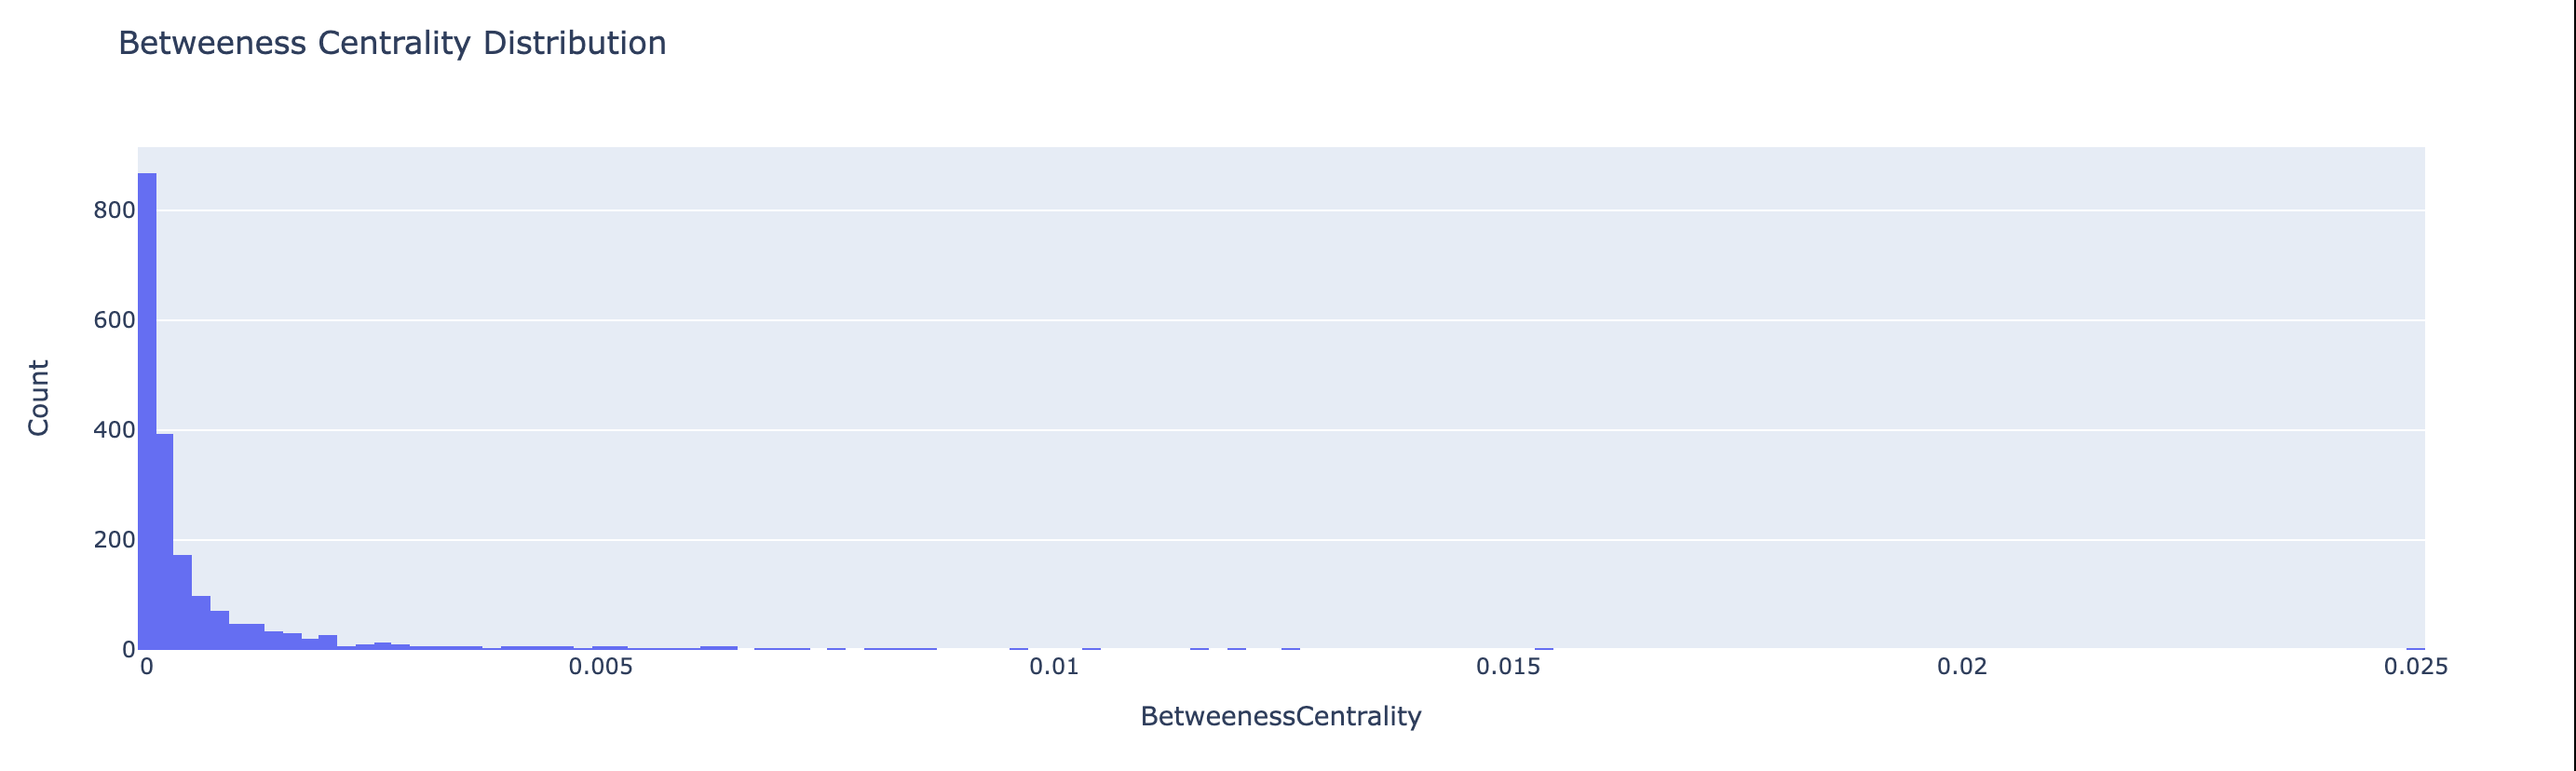

Betweenness Centrality:

-  <font color='#008B8B'>Warfarin (Anticoagulant)</font>  has the highest betweenness centrality value (0.025057) among the listed drugs. This suggests that Warfarin is critical in connecting different drugs in the network, possibly indicating that it has multiple interactions with other drugs, and thus may require close monitoring for potential drug-drug interactions.

-  <font color='#008B8B'>Ozanimod, Idelalisib, and Thalidomide</font> also have relatively high betweenness centrality values. These drugs are classified under 'ANTINEOPLASTIC AND IMMUNOMODULATING AGENTS', suggesting that they might play significant roles in connecting drugs within this therapeutic category.

- <font color='#008B8B'>Methotrexate</font> , which is an Antineoplastic drug, has a relatively high betweenness centrality value (0.012522), implying that it might have many connections with other drugs within the network.

- <font color='#008B8B'>Cyclosporine (Immunosuppressant) and Dexamethasone (Glucocorticoid)</font> also have relatively high betweenness centrality values, suggesting that they are crucial in connecting different drugs in the network, possibly due to their multiple therapeutic uses and drug interactions.

Some drugs with relatively lower betweenness centrality values, such as Picosulfuric acid and Carfilzomib, might have fewer connections with other drugs in the network, indicating that they may have fewer drug interactions.

> In conclusion, betweenness centrality can provide insights into the importance of different drugs in the network, potentially highlighting drugs with multiple interactions that may require close monitoring for potential drug-drug interactions. However, it is essential to note that the provided data is based on unweighted betweenness centrality, which may not fully account for the severity of the interactions. Incorporating weights based on interaction severity could provide a more accurate representation of the drug interaction network.

In [120]:
# Filter by subgraph 1 and sort by Top 15 closeness centrality, show columns closeness_centrality, Drug_original, Ranking Mono,Ranking Mono,oral,parenteral,indication_class,topical,chirality,availability_type,black_box_warning,first_in_class	ATC_Classification
nodes[nodes['subgraph'] == 1].sort_values('betweenness_centrality', ascending=False)[['betweenness_centrality', 'Drug_original', 'Ranking Mono ','Ranking Combi', 'oral','parenteral', 'indication_class', 'topical', 'chirality', 'availability_type', 'black_box_warning', 'first_in_class', 'ATC1_names','ATC_Classifications']].head(10)

betweenness_centrality      Drug_original  Ranking Mono   Ranking Combi  \
580                 0.025057           Warfarin            0.0            0.0   
1508                0.015335           Ozanimod          831.0          895.0   
705                 0.012598         Idelalisib         1158.0         1187.0   
239                 0.012547        Thalidomide            0.0            0.0   
529                 0.012522       Methotrexate           31.0           80.0   
484                 0.011952       Cyclosporine            0.0            0.0   
0                   0.011539      Dexamethasone           75.0           44.0   
1280                0.010379  Picosulfuric acid            0.0            0.0   
657                 0.009685    Chloramphenicol            0.0            0.0   
37                  0.009564       Promethazine            0.0            0.0   

       oral  parenteral                indication_class  topical  chirality  \
580    True        True                   Anticoagulant    False        0.0   
1508   True       False                               0    False        1.0   
705    True       False                               0    False        1.0   
239    True       False               Sedative-Hypnotic    False        0.0   
529   False       False                  Antineoplastic    False       -1.0   
484    True        True               Immunosuppressant     True        1.0   
0      True        True                  Glucocorticoid     True        1.0   
1280  False       False                               0    False        0.0   
657    True        True  Antibacterial, Antirickettsial     True        1.0   
37     True        True     Anti-Emetic, Antihistaminic     True        0.0   

      availability_type  black_box_warning  first_in_class  \
580                 1.0                1.0             0.0   
1508                1.0                0.0             0.0   
705                 1.0                1.0             1.0   
239                 1.0                1.0             0.0   
529                -1.0                0.0            -1.0   
484                 1.0                1.0             0.0   
0                   1.0                0.0             0.0   
1280                0.0                0.0             0.0   
657                -1.0                0.0             0.0   
37                  1.0                1.0             0.0   

                                             ATC1_names  \
580               {'BLOOD AND BLOOD FORMING ORGANS': 1}   
1508  {'ANTINEOPLASTIC AND IMMUNOMODULATING AGENTS': 1}   
705   {'ANTINEOPLASTIC AND IMMUNOMODULATING AGENTS': 1}   
239   {'ANTINEOPLASTIC AND IMMUNOMODULATING AGENTS': 1}   
529                                                  {}   
484   {'SENSORY ORGANS': 1, 'ANTINEOPLASTIC AND IMMU...   
0     {'RESPIRATORY SYSTEM': 2, 'ALIMENTARY TRACT AN...   
1280                                                 {}   
657   {'SENSORY ORGANS': 3, 'DERMATOLOGICALS': 2, 'G...   
37      {'RESPIRATORY SYSTEM': 2, 'DERMATOLOGICALS': 1}   

                                    ATC_Classifications  
580                                             B01AA03  
1508                                            L04AA38  
705                                             L01EM01  
239                                             L04AX02  
529                                                   0  
484                                    S01XA18, L04AD01  
0     R01AD53, A01AC02, R01AD03, S02BA06, S03BA01, D...  
1280                                                  0  
657   S01AA01, S03AA08, D06AX02, G01AA05, S02AA01, D...  
37                            R06AD52, D04AA10, R06AD02

Considering the weighted betweenness centrality along with the unweighted betweenness centrality and other drug characteristics, here are some conclusions about the drug interactions:


<font color='#008B8B'>Ozanimod</font> see previous section

<font color='#008B8B'>Siponimod</font> is an immunomodulating agent used for the treatment of multiple sclerosis. Its high unweighted betweenness centrality indicates that it has numerous connections with other drugs. This suggests that Siponimod may be an important drug to consider in the context of drug interactions for multiple sclerosis treatment, and careful monitoring and management may be needed when it is used with other medications.


<font color='#008B8B'>Leflunomide</font>  is a disease-modifying antirheumatic drug (DMARD) used to treat rheumatoid arthritis and psoriatic arthritis. Its high unweighted betweenness centrality suggests that it has many connections with other drugs. This indicates that Leflunomide could play a crucial role in drug interactions for patients with arthritis and might require special attention to prevent adverse effects when used in combination with other medications.


Conclusion:
Drugs with high betweenness centrality scores, such as Warfarin, Ozanimod, Idelalisib, Siponimod, and Leflunomide, are likely to have numerous connections with other drugs and play a central role in drug interactions. These drugs are used in the treatment of various conditions, including anticoagulation, autoimmune disorders, and cancer. Healthcare providers should carefully monitor and manage these medications when used with other drugs to minimize the risk of adverse effects and ensure the safety and effectiveness of treatment.

In [121]:
# Filter by subgraph 1 and sort by Top 15 weighted betweeness, show columns closeness_centrality, Drug_original, Ranking Mono,Ranking Mono,oral,parenteral,indication_class,topical,chirality,availability_type,black_box_warning,first_in_class	ATC_Classification
nodes[nodes['subgraph'] == 1].sort_values('weighted_betweenness_centrality', ascending=False)[['weighted_betweenness_centrality', 'Drug_original', 'Ranking Mono ','Ranking Combi', 'oral','parenteral', 'indication_class', 'topical', 'chirality', 'availability_type', 'black_box_warning', 'first_in_class', 'ATC1_names','ATC_Classifications']].head(10)

weighted_betweenness_centrality  Drug_original  Ranking Mono   \
1508                         0.052146       Ozanimod          831.0   
1510                         0.048535      Siponimod          930.0   
756                          0.047223    Leflunomide          480.0   
1088                         0.045521  Teriflunomide          824.0   
13                           0.021420    Hydrocodone         1337.0   
697                          0.021399      Ceritinib         1177.0   
239                          0.020314    Thalidomide            0.0   
580                          0.019791       Warfarin            0.0   
529                          0.018436   Methotrexate           31.0   
1397                         0.018347      Iopamidol          663.0   

      Ranking Combi   oral  parenteral                    indication_class  \
1508          895.0   True       False                                   0   
1510          981.0   True       False                                   0   
756           583.0   True       False                                   0   
1088          886.0   True       False                                   0   
13           1328.0  False       False                         Antitussive   
697          1206.0   True       False                                   0   
239             0.0   True       False                   Sedative-Hypnotic   
580             0.0   True        True                       Anticoagulant   
529            80.0  False       False                      Antineoplastic   
1397          742.0  False        True  Diagnostic Aid (radiopaque medium)   

      topical  chirality  availability_type  black_box_warning  \
1508    False        1.0                1.0                0.0   
1510    False        2.0                1.0                0.0   
756     False        2.0                1.0                1.0   
1088    False        2.0                1.0                1.0   
13      False        1.0               -1.0                0.0   
697     False        2.0                1.0                0.0   
239     False        0.0                1.0                1.0   
580     False        0.0                1.0                1.0   
529     False       -1.0               -1.0                0.0   
1397    False        1.0                1.0                0.0   

      first_in_class                                         ATC1_names  \
1508             0.0  {'ANTINEOPLASTIC AND IMMUNOMODULATING AGENTS': 1}   
1510             0.0  {'ANTINEOPLASTIC AND IMMUNOMODULATING AGENTS': 1}   
756              0.0  {'ANTINEOPLASTIC AND IMMUNOMODULATING AGENTS': 1}   
1088             1.0  {'ANTINEOPLASTIC AND IMMUNOMODULATING AGENTS': 1}   
13               0.0                          {'RESPIRATORY SYSTEM': 1}   
697              0.0  {'ANTINEOPLASTIC AND IMMUNOMODULATING AGENTS': 1}   
239              0.0  {'ANTINEOPLASTIC AND IMMUNOMODULATING AGENTS': 1}   
580              0.0              {'BLOOD AND BLOOD FORMING ORGANS': 1}   
529             -1.0                                                 {}   
1397             0.0                                     {'VARIOUS': 1}   

     ATC_Classifications  
1508             L04AA38  
1510             L04AA42  
756              L04AA13  
1088             L04AA31  
13               R05DA03  
697              L01ED02  
239              L04AX02  
580              B01AA03  
529                    0  
1397             V08AB04

<a id='5.3'></a>
<h1 align="left"><font size="4" color='#104E8B' > <b>  5.3 Pagerank  </b><br></font></h1> 

> Interpretation: A drug with a high PageRank score is considered important if it is connected to other important drugs in the network.
HCP Action: HCPs should consider the influence a high PageRank drug may have on other significant drugs in the network. They should evaluate the patient's entire medication regimen and may need to adjust dosages or select alternative treatments to minimize the risk of adverse drug interactions.

Pagerank Top 3:

- __Warfarin__ - Anticoagulant, both oral and parenteral, with a black box warning and first in class.
- __Dexamethasone__ - Glucocorticoid, both oral and parenteral, with no black box warning and not first in class.
- __Cyclosporine__ - Immunosuppressant, both oral and parenteral, with a black box warning and first in class.

In [122]:
# Filter by subgraph 1 and sort by Top 15 closeness centrality, show columns closeness_centrality, Drug_original, Ranking Mono,Ranking Mono,oral,parenteral,indication_class,topical,chirality,availability_type,black_box_warning,first_in_class	ATC_Classification
nodes[nodes['subgraph'] == 1].sort_values('pagerank', ascending=False)[['pagerank', 'Drug_original', 'Ranking Mono ','Ranking Combi', 'oral','parenteral', 'indication_class', 'topical', 'chirality', 'availability_type', 'black_box_warning', 'first_in_class', 'ATC1_names']].head(10)

pagerank   Drug_original  Ranking Mono   Ranking Combi   oral  \
580  0.002886        Warfarin            0.0            0.0   True   
0    0.002508   Dexamethasone           75.0           44.0   True   
484  0.002397    Cyclosporine            0.0            0.0   True   
417  0.002313      Tacrolimus          159.0          248.0   True   
37   0.002269    Promethazine            0.0            0.0   True   
529  0.002246    Methotrexate           31.0           80.0  False   
698  0.002221  Clarithromycin          214.0          307.0   True   
409  0.002221      Prednisone           85.0          157.0   True   
239  0.002171     Thalidomide            0.0            0.0   True   
705  0.002153      Idelalisib         1158.0         1187.0   True   

     parenteral             indication_class  topical  chirality  \
580        True                Anticoagulant    False        0.0   
0          True               Glucocorticoid     True        1.0   
484        True            Immunosuppressant     True        1.0   
417        True            Immunosuppressant     True        1.0   
37         True  Anti-Emetic, Antihistaminic     True        0.0   
529       False               Antineoplastic    False       -1.0   
698       False                Antibacterial    False        1.0   
409       False               Glucocorticoid    False        1.0   
239       False            Sedative-Hypnotic    False        0.0   
705       False                            0    False        1.0   

     availability_type  black_box_warning  first_in_class  \
580                1.0                1.0             0.0   
0                  1.0                0.0             0.0   
484                1.0                1.0             0.0   
417                1.0                1.0             0.0   
37                 1.0                1.0             0.0   
529               -1.0                0.0            -1.0   
698                1.0                0.0             0.0   
409                1.0                0.0             0.0   
239                1.0                1.0             0.0   
705                1.0                1.0             1.0   

                                            ATC1_names  
580              {'BLOOD AND BLOOD FORMING ORGANS': 1}  
0    {'RESPIRATORY SYSTEM': 2, 'ALIMENTARY TRACT AN...  
484  {'SENSORY ORGANS': 1, 'ANTINEOPLASTIC AND IMMU...  
417                                                 {}  
37     {'RESPIRATORY SYSTEM': 2, 'DERMATOLOGICALS': 1}  
529                                                 {}  
698             {'ANTIINFECTIVES FOR SYSTEMIC USE': 1}  
409  {'ALIMENTARY TRACT AND METABOLISM': 1, 'SYSTEM...  
239  {'ANTINEOPLASTIC AND IMMUNOMODULATING AGENTS': 1}  
705  {'ANTINEOPLASTIC AND IMMUNOMODULATING AGENTS': 1}

Weighted Pagerank Top 3:

- __Warfarin__ - Anticoagulant, both oral and parenteral, with a black box warning and first in class.
- __Dexamethasone__ - Glucocorticoid, both oral and parenteral, with no black box warning and not first in class.
- __Ozanimod__ - Part of the 'Antineoplastic and Immunomodulating Agents' category, oral only, with a black box warning and not first in class.

In [123]:
# Filter by subgraph 1 and sort by Top 15 weighted_pagerank, show columns closeness_centrality, Drug_original, Ranking Mono,Ranking Mono,oral,parenteral,indication_class,topical,chirality,availability_type,black_box_warning,first_in_class	ATC_Classification
nodes[nodes['subgraph'] == 1].sort_values('weighted_pagerank', ascending=False)[['weighted_pagerank', 'Drug_original', 'Ranking Mono ','Ranking Combi', 'oral','parenteral', 'indication_class', 'topical', 'chirality', 'availability_type', 'black_box_warning', 'first_in_class', 'ATC1_names']].head(10)

weighted_pagerank   Drug_original  Ranking Mono   Ranking Combi   oral  \
580           0.002933        Warfarin            0.0            0.0   True   
0             0.002574   Dexamethasone           75.0           44.0   True   
484           0.002420    Cyclosporine            0.0            0.0   True   
409           0.002327      Prednisone           85.0          157.0   True   
37            0.002323    Promethazine            0.0            0.0   True   
529           0.002241    Methotrexate           31.0           80.0  False   
28            0.002190      Salbutamol           32.0           72.0   True   
417           0.002183      Tacrolimus          159.0          248.0   True   
20            0.002171    Prednisolone           53.0           58.0   True   
698           0.002157  Clarithromycin          214.0          307.0   True   

     parenteral             indication_class  topical  chirality  \
580        True                Anticoagulant    False        0.0   
0          True               Glucocorticoid     True        1.0   
484        True            Immunosuppressant     True        1.0   
409       False               Glucocorticoid    False        1.0   
37         True  Anti-Emetic, Antihistaminic     True        0.0   
529       False               Antineoplastic    False       -1.0   
28        False               Bronchodilator     True        0.0   
417        True            Immunosuppressant     True        1.0   
20        False               Glucocorticoid     True        1.0   
698       False                Antibacterial    False        1.0   

     availability_type  black_box_warning  first_in_class  \
580                1.0                1.0             0.0   
0                  1.0                0.0             0.0   
484                1.0                1.0             0.0   
409                1.0                0.0             0.0   
37                 1.0                1.0             0.0   
529               -1.0                0.0            -1.0   
28                 1.0                1.0             0.0   
417                1.0                1.0             0.0   
20                 1.0                0.0             0.0   
698                1.0                0.0             0.0   

                                            ATC1_names  
580              {'BLOOD AND BLOOD FORMING ORGANS': 1}  
0    {'RESPIRATORY SYSTEM': 2, 'ALIMENTARY TRACT AN...  
484  {'SENSORY ORGANS': 1, 'ANTINEOPLASTIC AND IMMU...  
409  {'ALIMENTARY TRACT AND METABOLISM': 1, 'SYSTEM...  
37     {'RESPIRATORY SYSTEM': 2, 'DERMATOLOGICALS': 1}  
529                                                 {}  
28                           {'RESPIRATORY SYSTEM': 2}  
417                                                 {}  
20   {'SENSORY ORGANS': 4, 'DERMATOLOGICALS': 2, 'R...  
698             {'ANTIINFECTIVES FOR SYSTEMIC USE': 1}

From the analysis, Warfarin consistently ranks highest in all three measures. It is an anticoagulant that is available both orally and parenterally, with a black box warning and is first in class. Dexamethasone ranks high in pagerank and weighted pagerank, and it is a glucocorticoid available both orally and parenterally with no black box warning and not first in class. Ozanimod appears in the top 3 of betweenness centrality and weighted pagerank and belongs to the 'Antineoplastic and Immunomodulating Agents' category, being orally available, with a black box warning, and not first in class.

It's important to consider both mono and combi rankings while analyzing these drugs. For instance, Methotrexate has a relatively high mono ranking (31) and combi ranking (71), while Warfarin seems not be used in both mono and combi. This suggests that although Warfarin ranks high in network-based metrics, it  seems not be widely used compared to Methotrexate.

<a id='5.4'></a>
<h1 align="left"><font size="4" color='#104E8B' > <b>  5.4. Degree and degree Centrality </b><br></font></h1> 

>In this analysis, we focus on the differences in degree centrality and degree for the given data. Degree centrality is a measure of the importance of a node (drug) in a network, and the degree of a node is the number of connections it has to other nodes.

Key Points:

- __Warfarin__ has the highest degree centrality (0.025057) among the drugs, followed by Ozanimod (0.015335) and Idelalisib (0.012598). This suggests that these drugs have a greater influence or importance in the network compared to others.

- __Dexamethasone__ has the highest degree (910), indicating that it has the most connections with other drugs. Other drugs with high degrees include Tacrolimus (866), Warfarin (864), Promethazine (832), and Clarithromycin (822).

> Interestingly, Warfarin has both high degree centrality and degree, suggesting that it has many connections and is a crucial drug in the network.

Some drugs have a significant difference in their ranking for mono and combi therapy, such as Tacrolimus (159 for mono and 243 for combi) and Ozanimod (831 for mono and 1123 for combi). This could indicate that these drugs have different levels of effectiveness when used alone or in combination with other drugs.

A majority of the drugs in the dataset are orally administered, with some also available for parenteral use, like Dexamethasone, Warfarin, and Cyclosporine. This suggests that these drugs might have more versatile applications or better bioavailability.

Various indication classes are represented in the dataset, including Glucocorticoid, Immunosuppressant, Anticoagulant, Antihistaminic, Anti-Emetic, Antidepressant, and more. This highlights the diversity of the drugs' applications in treating different medical conditions.

Most of the drugs have chiral structures (chirality = 1), which could impact their pharmacological properties and the way they interact with the biological targets.

Most drugs have no black box warning (black_box_warning = 0), suggesting they have relatively lower risks of severe side effects or complications. However, a few drugs, like Warfarin and Thalidomide, have black box warnings, indicating a higher risk associated with their use.

Overall, the dataset provides insights into the various properties of the drugs, their effectiveness as mono or combination therapies, and their importance within the network. Warfarin stands out as a highly connected and influential drug, while other drugs like Dexamethasone and Tacrolimus also have numerous connections with other drugs. This information can be useful for understanding drug interactions, developing better treatment strategies, and identifying potential new drug combinations.

In [90]:
# Get the subgraphs
subgraphs = nx.connected_components(G)

# Create a figure for the plot
fig = go.Figure()

# Iterate over each subgraph
for i, nodes in enumerate(subgraphs):

    # Convert the set of nodes to a subgraph
    subgraph = G.subgraph(nodes)

    # Get the degree distribution
    degree_dist = nx.degree_histogram(subgraph)

    # Convert the degree distribution to a list of tuples
    degree_dist = [(deg, count) for deg, count in enumerate(degree_dist)]

    # Add a trace for the degree distribution of the current subgraph
    fig.add_trace(go.Scatter(x=[x[0] for x in degree_dist], y=[x[1] for x in degree_dist], mode='lines', name=f'Subgraph {i+1}'))

# Update the layout 
fig.update_layout(xaxis_title='Degree', yaxis_title='Count', title='Degree distribution per subgraph')

# Show the plot
fig.show()



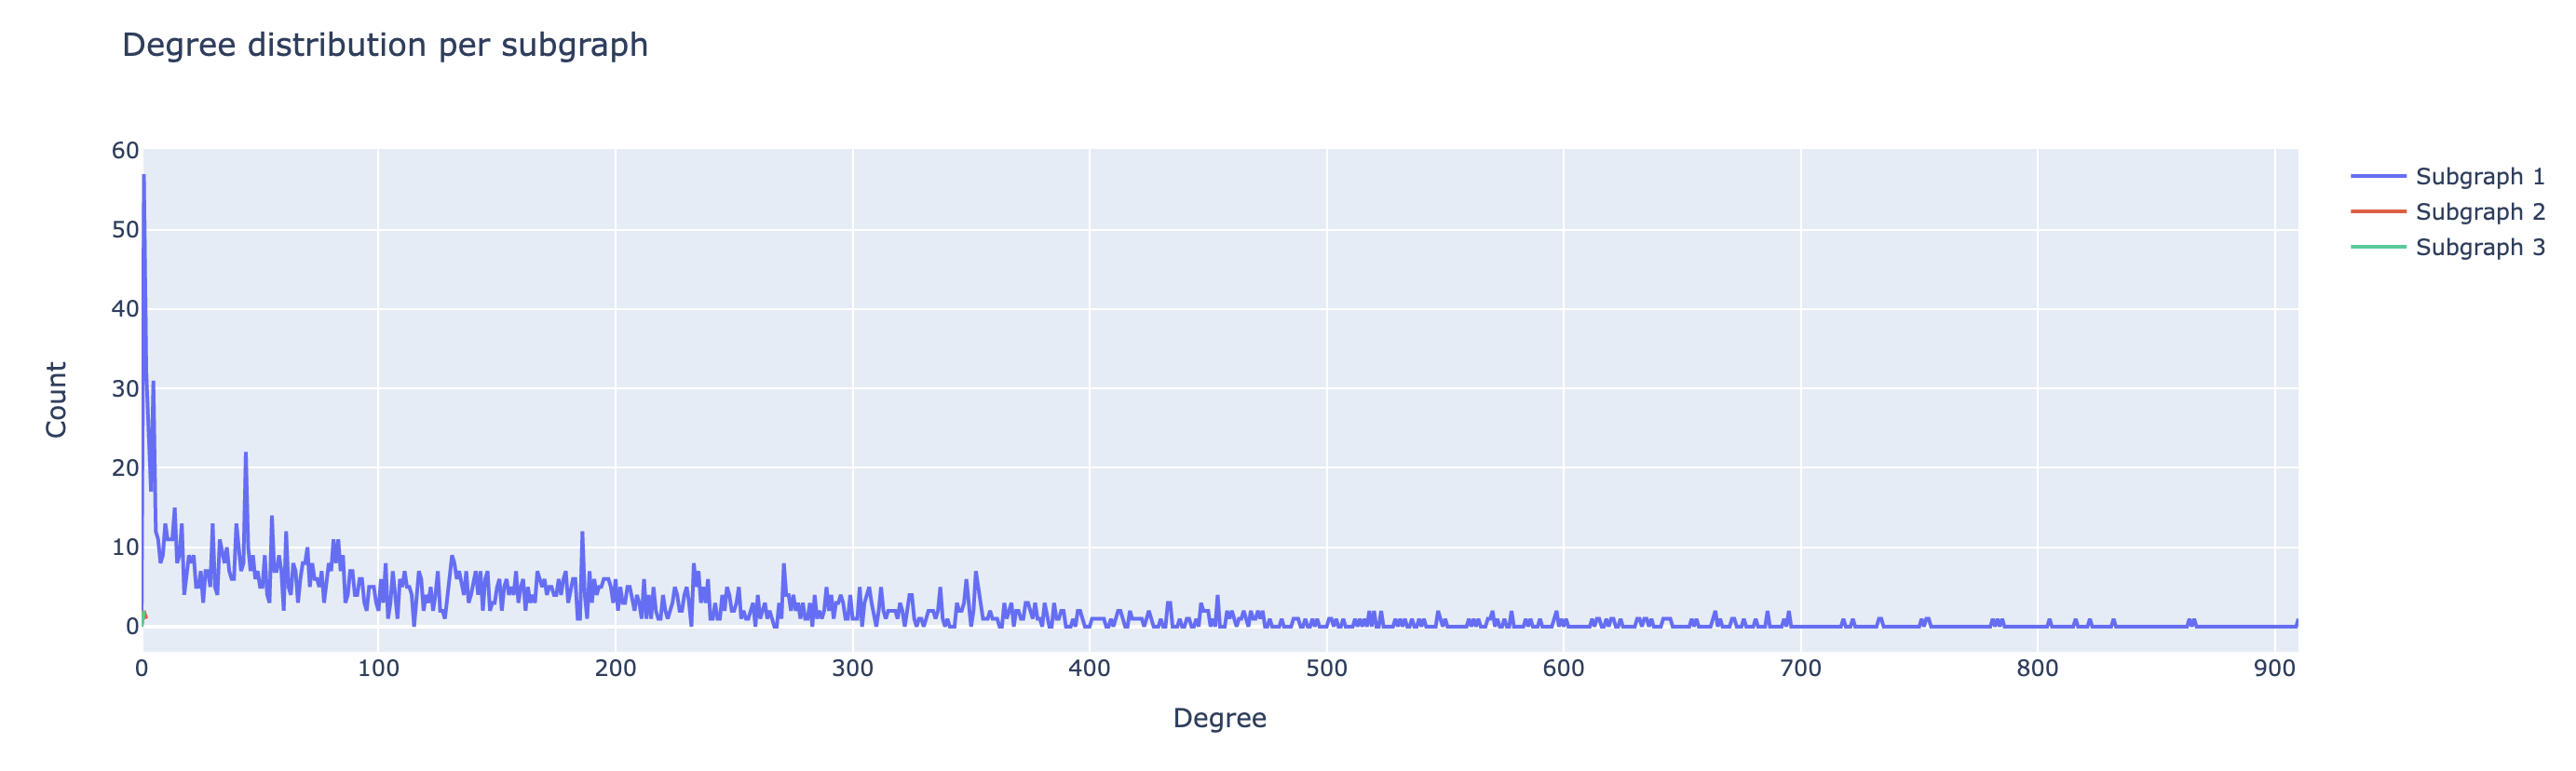

In [128]:
# extentd the dataframe with the degree and betweeness 
# filter by subgraph 1 and sort by degree, show columns degree, Drug_original, Ranking Mono,Ranking Mono,oral,parenteral,indication_class,topical,chirality,availability_type,black_box_warning,first_in_class	ATC_Classification
nodes[nodes['subgraph'] == 1].sort_values('degree', ascending=False)[['degree', 'Drug_original', 'Ranking Mono ','Ranking Combi', 'oral','parenteral', 'indication_class', 'topical', 'chirality', 'availability_type', 'black_box_warning', 'first_in_class', 'ATC1_names','ATC_Classifications']].head(15)


degree   Drug_original  Ranking Mono   Ranking Combi   oral  parenteral  \
0        910   Dexamethasone           75.0           44.0   True        True   
417      866      Tacrolimus          159.0          248.0   True        True   
580      864        Warfarin            0.0            0.0   True        True   
37       832    Promethazine            0.0            0.0   True        True   
698      822  Clarithromycin          214.0          307.0   True       False   
484      816    Cyclosporine            0.0            0.0   True        True   
409      805      Prednisone           85.0          157.0   True       False   
239      785     Thalidomide            0.0            0.0   True       False   
74       783     Fluconazole          107.0          188.0   True        True   
529      781    Methotrexate           31.0           80.0  False       False   
365      754    Erythromycin          340.0          440.0   True       False   
28       753      Salbutamol           32.0           72.0   True       False   
20       751    Prednisolone           53.0           58.0   True       False   
318      734         Doxepin         1271.0         1354.0   True       False   
1508     733        Ozanimod          831.0          895.0   True       False   

                 indication_class  topical  chirality  availability_type  \
0                  Glucocorticoid     True        1.0                1.0   
417             Immunosuppressant     True        1.0                1.0   
580                 Anticoagulant    False        0.0                1.0   
37    Anti-Emetic, Antihistaminic     True        0.0                1.0   
698                 Antibacterial    False        1.0                1.0   
484             Immunosuppressant     True        1.0                1.0   
409                Glucocorticoid    False        1.0                1.0   
239             Sedative-Hypnotic    False        0.0                1.0   
74                     Antifungal    False        2.0                1.0   
529                Antineoplastic    False       -1.0               -1.0   
365                 Antibacterial     True        1.0                1.0   
28                 Bronchodilator     True        0.0                1.0   
20                 Glucocorticoid     True        1.0                1.0   
318                Antidepressant     True        2.0                1.0   
1508                            0    False        1.0                1.0   

      black_box_warning  first_in_class  \
0                   0.0             0.0   
417                 1.0             0.0   
580                 1.0             0.0   
37                  1.0             0.0   
698                 0.0             0.0   
484                 1.0             0.0   
409                 0.0             0.0   
239                 1.0             0.0   
74                  0.0             0.0   
529                 0.0            -1.0   
365                 0.0             0.0   
28                  1.0             0.0   
20                  0.0             0.0   
318                 1.0             0.0   
1508                0.0             0.0   

                                             ATC1_names  \
0     {'RESPIRATORY SYSTEM': 2, 'ALIMENTARY TRACT AN...   
417                                                  {}   
580               {'BLOOD AND BLOOD FORMING ORGANS': 1}   
37      {'RESPIRATORY SYSTEM': 2, 'DERMATOLOGICALS': 1}   
698              {'ANTIINFECTIVES FOR SYSTEMIC USE': 1}   
484   {'SENSORY ORGANS': 1, 'ANTINEOPLASTIC AND IMMU...   
409   {'ALIMENTARY TRACT AND METABOLISM': 1, 'SYSTEM...   
239   {'ANTINEOPLASTIC AND IMMUNOMODULATING AGENTS': 1}   
74    {'ANTIINFECTIVES FOR SYSTEMIC USE': 1, 'DERMAT...   
529                                                  {}   
365   {'SENSORY ORGANS': 1, 'ANTIINFECTIVES FOR SYST...   
28                            {'RESPIRATORY SYSTEM': 2}   
20    {'SENSORY ORGANS': 4, 'DERMATO

In [129]:
# Filter by subgraph 1 and sort by Top 20 closeness centrality, show columns closeness_centrality, Drug_original, Ranking Mono,Ranking Mono,oral,parenteral,indication_class,topical,chirality,availability_type,black_box_warning,first_in_class	ATC_Classification
nodes[nodes['subgraph'] == 1].sort_values('degree_centrality', ascending=False)[['degree_centrality' ,'Drug_original', 'Ranking Mono ','Ranking Combi', 'oral','parenteral', 'indication_class', 'topical', 'chirality', 'availability_type', 'black_box_warning', 'first_in_class', 'ATC1_names']].head(15)

degree_centrality      Drug_original  Ranking Mono   Ranking Combi  \
580            0.025057           Warfarin            0.0            0.0   
1508           0.015335           Ozanimod          831.0          895.0   
705            0.012598         Idelalisib         1158.0         1187.0   
239            0.012547        Thalidomide            0.0            0.0   
529            0.012522       Methotrexate           31.0           80.0   
484            0.011952       Cyclosporine            0.0            0.0   
0              0.011539      Dexamethasone           75.0           44.0   
1280           0.010379  Picosulfuric acid            0.0            0.0   
657            0.009685    Chloramphenicol            0.0            0.0   
37             0.009564       Promethazine            0.0            0.0   
318            0.008577            Doxepin         1271.0         1354.0   
1346           0.008372        Carfilzomib          664.0          743.0   
195            0.008225           Morphine           79.0          150.0   
417            0.008064         Tacrolimus          159.0          248.0   
28             0.007588         Salbutamol           32.0           72.0   

       oral  parenteral                indication_class  topical  chirality  \
580    True        True                   Anticoagulant    False        0.0   
1508   True       False                               0    False        1.0   
705    True       False                               0    False        1.0   
239    True       False               Sedative-Hypnotic    False        0.0   
529   False       False                  Antineoplastic    False       -1.0   
484    True        True               Immunosuppressant     True        1.0   
0      True        True                  Glucocorticoid     True        1.0   
1280  False       False                               0    False        0.0   
657    True        True  Antibacterial, Antirickettsial     True        1.0   
37     True        True     Anti-Emetic, Antihistaminic     True        0.0   
318    True       False                  Antidepressant     True        2.0   
1346  False        True                               0    False        1.0   
195    True        True            Analgesic (narcotic)    False        1.0   
417    True        True               Immunosuppressant     True        1.0   
28     True       False                  Bronchodilator     True        0.0   

      availability_type  black_box_warning  first_in_class  \
580                 1.0                1.0             0.0   
1508                1.0                0.0             0.0   
705                 1.0                1.0             1.0   
239                 1.0                1.0             0.0   
529                -1.0                0.0            -1.0   
484                 1.0                1.0             0.0   
0                   1.0                0.0             0.0   
1280                0.0                0.0             0.0   
657                -1.0                0.0             0.0   
37                  1.0                1.0             0.0   
318                 1.0                1.0             0.0   
1346                1.0                0.0             0.0   
195                 1.0                1.0             0.0   
417                 1.0                1.0             0.0   
28                  1.0                1.0             0.0   

                                             ATC1_names  
580               {'BLOOD AND BLOOD FORMING ORGANS': 1}  
1508  {'ANTINEOPLASTIC AND IMMUNOMODULATING AGENTS': 1}  
705   {'ANTINEOPLASTIC AND IMMUNOMODULATING AGENTS': 1}  
239   {'ANTINEOPLASTIC AND IMMUNOMODULATING AGENTS': 1}  
529                                                  {}  
484   {'SENSORY ORGANS': 1, 'ANTINEOPLASTIC AND IMMU...  
0     {'RESPIRATORY SYSTEM': 2, 'ALIMENTARY TRACT AN...  
1280                                                 {}  
657   {'S

<a id='5.5'></a>
<h1 align="left"><font size="4" color='#104E8B' > <b>  5.5. Eigenvector centrality</b><br></font></h1> 

In [135]:
# Calculate the closeness centrality for each node
bb = nx.eigenvector_centrality(G)

# Create a histogram of the closeness centrality values
fig = go.Figure(data=[go.Histogram(x=list(bb.values()))])

# Add labels and title to the plot
fig.update_layout(
    title="Eigenvector Centrality Distribution",
    xaxis_title="Eigenvector Centrality",
    yaxis_title="Count"
)

# Show the plot
fig.show()

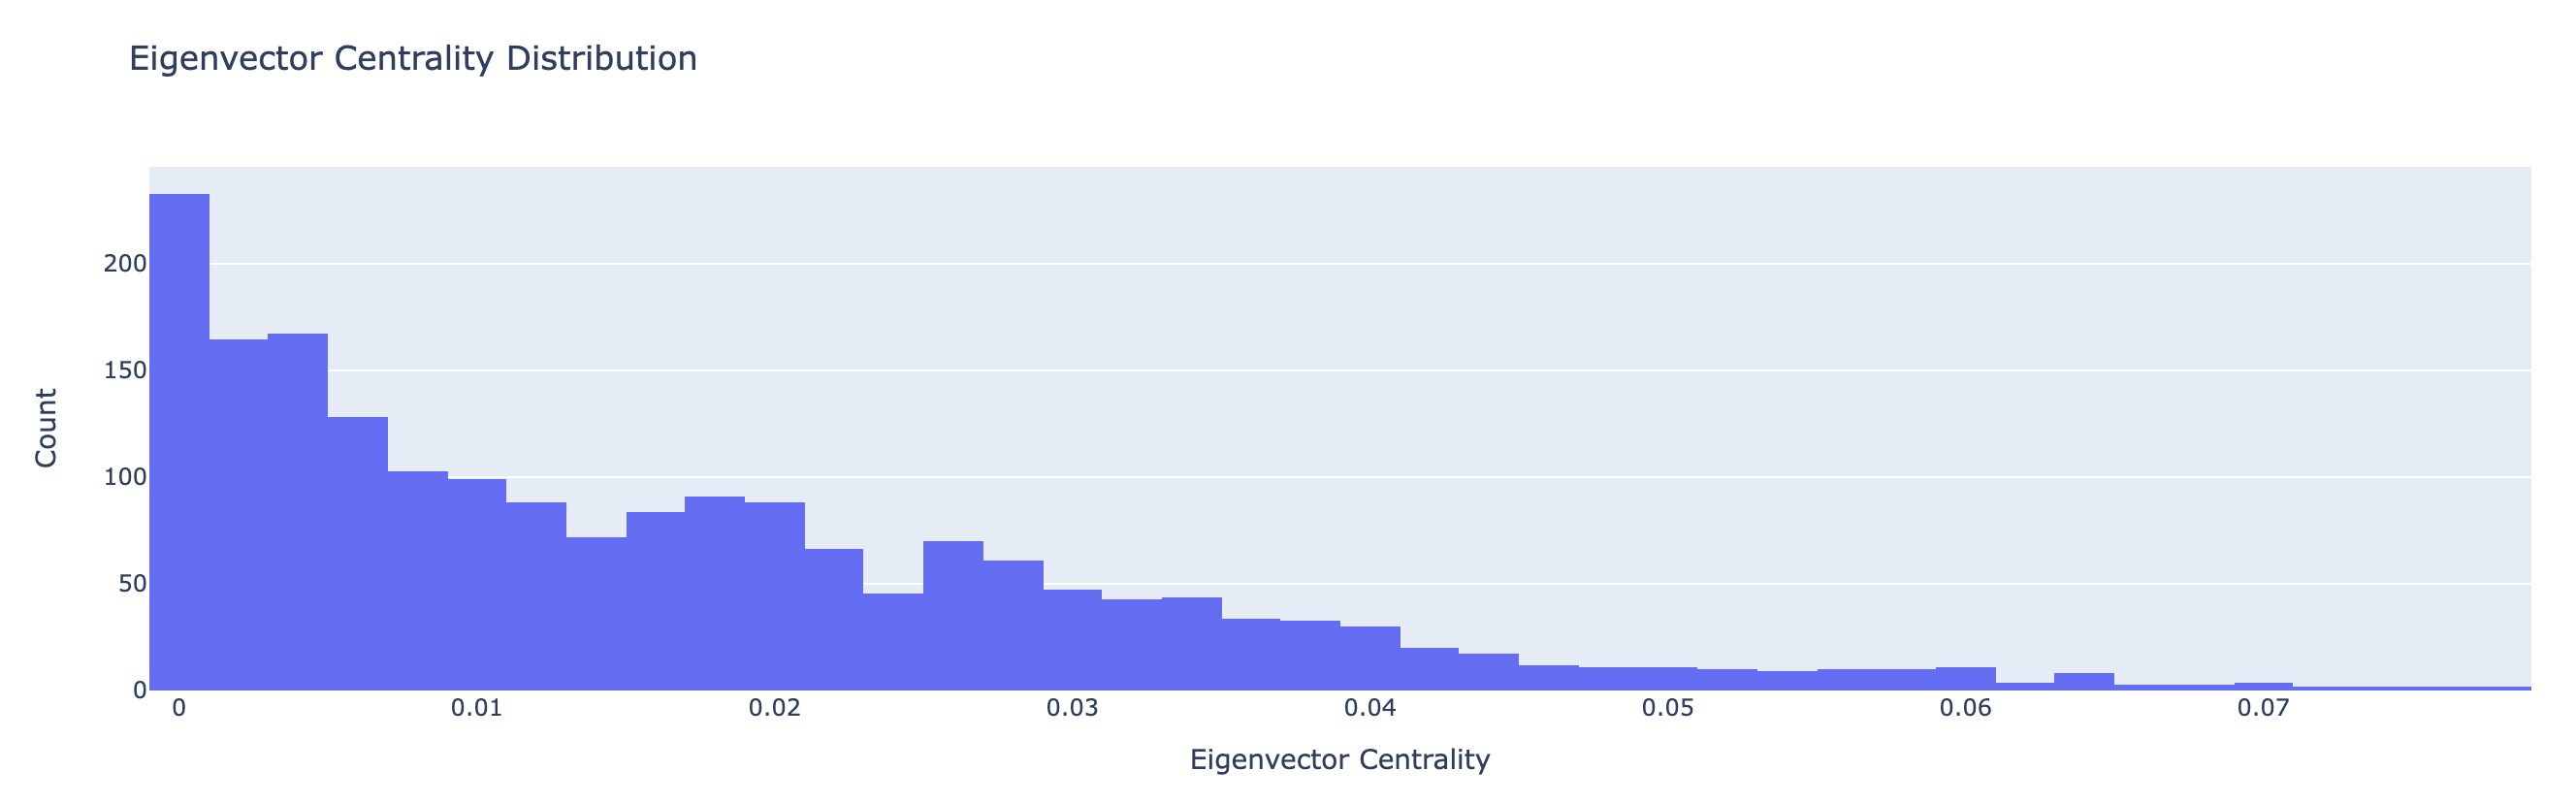

This dataset shows the eigenvector centrality scores for various drugs, both unweighted and weighted. Eigenvector centrality is a measure of the influence of a node in a network. In this context, it measures the importance of a drug based on its connections to other drugs in the network.

Unweighted eigenvector centrality does not take into account the weights of the connections (edges) between the nodes (drugs). The top 3 drugs based on unweighted eigenvector centrality are Tacrolimus, Dexamethasone, and Clarithromycin. Tacrolimus is an immunosuppressant, Dexamethasone is a glucocorticoid, and Clarithromycin is an antibacterial.

Weighted eigenvector centrality, on the other hand, does take into account the weights of the connections between the nodes. This means that the importance of a drug in the network is affected not only by the number of connections but also by the strength of these connections. The top 3 drugs based on weighted eigenvector centrality are Metronidazole, Dexamethasone, and Prednisone. 

Comparing unweighted and weighted eigenvector centrality scores can provide insights into the relative importance of drugs in a network based on different aspects of their connections. In this case, the rankings of the drugs change slightly when the weights of the connections are taken into account.

- __Dexamethasone's__ widespread use in a variety of conditions and its glucocorticoid properties may contribute to its high eigenvector centrality.

- __Metronidazole__ is an antibacterial and antiprotozoal drug used to treat infections caused by anaerobic bacteria and protozoa.  Its high weighted eigenvector centrality indicates that it has strong connections with other drugs that also have high centrality scores. The broad spectrum of activity and use of Metronidazole in various infections could be a factor contributing to its high eigenvector centrality, making it a crucial drug to monitor for potential interactions.

- __Prednisone__ is a glucocorticoid drug used to treat various conditions, including allergies, autoimmune diseases, and inflammatory disorders. Its high weighted eigenvector centrality suggests that it has strong connections with other drugs with high centrality scores. This could be attributed to its widespread use and glucocorticoid properties. Similar to Dexamethasone, Prednisone's role in managing a wide range of conditions makes it a key drug in the context of drug interactions.

Conclusion:
Drugs with high weighted eigenvector centrality scores, such as Dexamethasone, Metronidazole, and Prednisone, are not only connected to many other drugs but also to other drugs with high centrality scores. This highlights their importance in drug interactions. These drugs are used to treat various conditions, including allergies, infections, autoimmune diseases, and inflammatory disorders. Healthcare providers should be cautious when prescribing these medications in combination with other drugs to minimize the risk of adverse effects and ensure the safety and effectiveness of treatment.

In [126]:
# Filter by subgraph 1 and sort by Top 20 closeness centrality, show columns closeness_centrality, Drug_original, Ranking Mono,Ranking Mono,oral,parenteral,indication_class,topical,chirality,availability_type,black_box_warning,first_in_class	ATC_Classification
nodes[nodes['subgraph'] == 1].sort_values('eigenvector_centrality', ascending=False)[['eigenvector_centrality', 'Drug_original', 'Ranking Mono ','Ranking Combi', 'oral','parenteral', 'indication_class', 'topical', 'chirality', 'availability_type', 'black_box_warning', 'first_in_class', 'ATC1_names']].head(10)

eigenvector_centrality   Drug_original  Ranking Mono   Ranking Combi  \
417                0.078592      Tacrolimus          159.0          248.0   
0                  0.077820   Dexamethasone           75.0           44.0   
698                0.076040  Clarithromycin          214.0          307.0   
74                 0.074010     Fluconazole          107.0          188.0   
37                 0.072799    Promethazine            0.0            0.0   
365                0.071019    Erythromycin          340.0          440.0   
484                0.070463    Cyclosporine            0.0            0.0   
409                0.070026      Prednisone           85.0          157.0   
28                 0.069195      Salbutamol           32.0           72.0   
239                0.069081     Thalidomide            0.0            0.0   

     oral  parenteral             indication_class  topical  chirality  \
417  True        True            Immunosuppressant     True        1.0   
0    True        True               Glucocorticoid     True        1.0   
698  True       False                Antibacterial    False        1.0   
74   True        True                   Antifungal    False        2.0   
37   True        True  Anti-Emetic, Antihistaminic     True        0.0   
365  True       False                Antibacterial     True        1.0   
484  True        True            Immunosuppressant     True        1.0   
409  True       False               Glucocorticoid    False        1.0   
28   True       False               Bronchodilator     True        0.0   
239  True       False            Sedative-Hypnotic    False        0.0   

     availability_type  black_box_warning  first_in_class  \
417                1.0                1.0             0.0   
0                  1.0                0.0             0.0   
698                1.0                0.0             0.0   
74                 1.0                0.0             0.0   
37                 1.0                1.0             0.0   
365                1.0                0.0             0.0   
484                1.0                1.0             0.0   
409                1.0                0.0             0.0   
28                 1.0                1.0             0.0   
239                1.0                1.0             0.0   

                                            ATC1_names  
417                                                 {}  
0    {'RESPIRATORY SYSTEM': 2, 'ALIMENTARY TRACT AN...  
698             {'ANTIINFECTIVES FOR SYSTEMIC USE': 1}  
74   {'ANTIINFECTIVES FOR SYSTEMIC USE': 1, 'DERMAT...  
37     {'RESPIRATORY SYSTEM': 2, 'DERMATOLOGICALS': 1}  
365  {'SENSORY ORGANS': 1, 'ANTIINFECTIVES FOR SYST...  
484  {'SENSORY ORGANS': 1, 'ANTINEOPLASTIC AND IMMU...  
409  {'ALIMENTARY TRACT AND METABOLISM': 1, 'SYSTEM...  
28                           {'RESPIRATORY SYSTEM': 2}  
239  {'ANTINEOPLASTIC AND IMMUNOMODULATING AGENTS': 1}

In [ ]:
# add neighbors in the nodes dataframe
nodes['neighbors'] = nodes['DDInterID'].apply(lambda x: list(G.neighbors(x)))


In [127]:
# Filter by subgraph 1 and sort by Top 20 closeness centrality, show columns closeness_centrality, Drug_original, Ranking Mono,Ranking Mono,oral,parenteral,indication_class,topical,chirality,availability_type,black_box_warning,first_in_class	ATC_Classification
nodes[nodes['subgraph'] == 1].sort_values('weighted_eigenvector_centrality', ascending=False)[['weighted_eigenvector_centrality', 'Drug_original', 'Ranking Mono ','Ranking Combi', 'oral','parenteral', 'indication_class', 'topical', 'chirality', 'availability_type', 'black_box_warning', 'first_in_class', 'ATC1_names']].head(10)

weighted_eigenvector_centrality   Drug_original  Ranking Mono   \
0                           0.081356   Dexamethasone           75.0   
626                         0.076586   Metronidazole          152.0   
409                         0.076049      Prednisone           85.0   
37                          0.075555    Promethazine            0.0   
28                          0.075117      Salbutamol           32.0   
417                         0.073848      Tacrolimus          159.0   
74                          0.073254     Fluconazole          107.0   
698                         0.072693  Clarithromycin          214.0   
20                          0.072523    Prednisolone           53.0   
580                         0.071685        Warfarin            0.0   

     Ranking Combi  oral  parenteral  \
0             44.0  True        True   
626          234.0  True        True   
409          157.0  True       False   
37             0.0  True        True   
28            72.0  True       False   
417          248.0  True        True   
74           188.0  True        True   
698          307.0  True       False   
20            58.0  True       False   
580            0.0  True        True   

                              indication_class  topical  chirality  \
0                               Glucocorticoid     True        1.0   
626  Antibacterial,Antiprotozoal (trichomonas)     True        2.0   
409                             Glucocorticoid    False        1.0   
37                 Anti-Emetic, Antihistaminic     True        0.0   
28                              Bronchodilator     True        0.0   
417                          Immunosuppressant     True        1.0   
74                                  Antifungal    False        2.0   
698                              Antibacterial    False        1.0   
20                              Glucocorticoid     True        1.0   
580                              Anticoagulant    False        0.0   

     availability_type  black_box_warning  first_in_class  \
0                  1.0                0.0             0.0   
626                1.0                1.0             0.0   
409                1.0                0.0             0.0   
37                 1.0                1.0             0.0   
28                 1.0                1.0             0.0   
417                1.0                1.0             0.0   
74                 1.0                0.0             0.0   
698                1.0                0.0             0.0   
20                 1.0                0.0             0.0   
580                1.0                1.0             0.0   

                                            ATC1_names  
0    {'RESPIRATORY SYSTEM': 2, 'ALIMENTARY TRACT AN...  
626  {'DERMATOLOGICALS': 1, 'ANTIPARASITIC PRODUCTS...  
409  {'ALIMENTARY TRACT AND METABOLISM': 1, 'SYSTEM...  
37     {'RESPIRATORY SYSTEM': 2, 'DERMATOLOGICALS': 1}  
28                           {'RESPIRATORY SYSTEM': 2}  
417                                                 {}  
74   {'ANTIINFECTIVES FOR SYSTEMIC USE': 1, 'DERMAT...  
698             {'ANTIINFECTIVES FOR SYSTEMIC USE': 1}  
20   {'SENSORY ORGANS': 4, 'DERMATOLOGICALS': 2, 'R...  
580              {'BLOOD AND BLOOD FORMING ORGANS': 1}

<a id='5.6'></a>
<h1 align="left"><font size="4" color='#104E8B' > <b>  5.6.Clustering Coefficient<br></font></h1> 

In [137]:
# Calculate the closeness centrality for each node
cc = nx.clustering(G)

# Create a histogram of the closeness centrality values
fig = go.Figure(data=[go.Histogram(x=list(cc.values()))])

# Add labels and title to the plot
fig.update_layout(
    title="Clustering Coefficient Distribution",
    xaxis_title="Clustering Coefficient",
    yaxis_title="Count"
)

# Show the plot
fig.show()

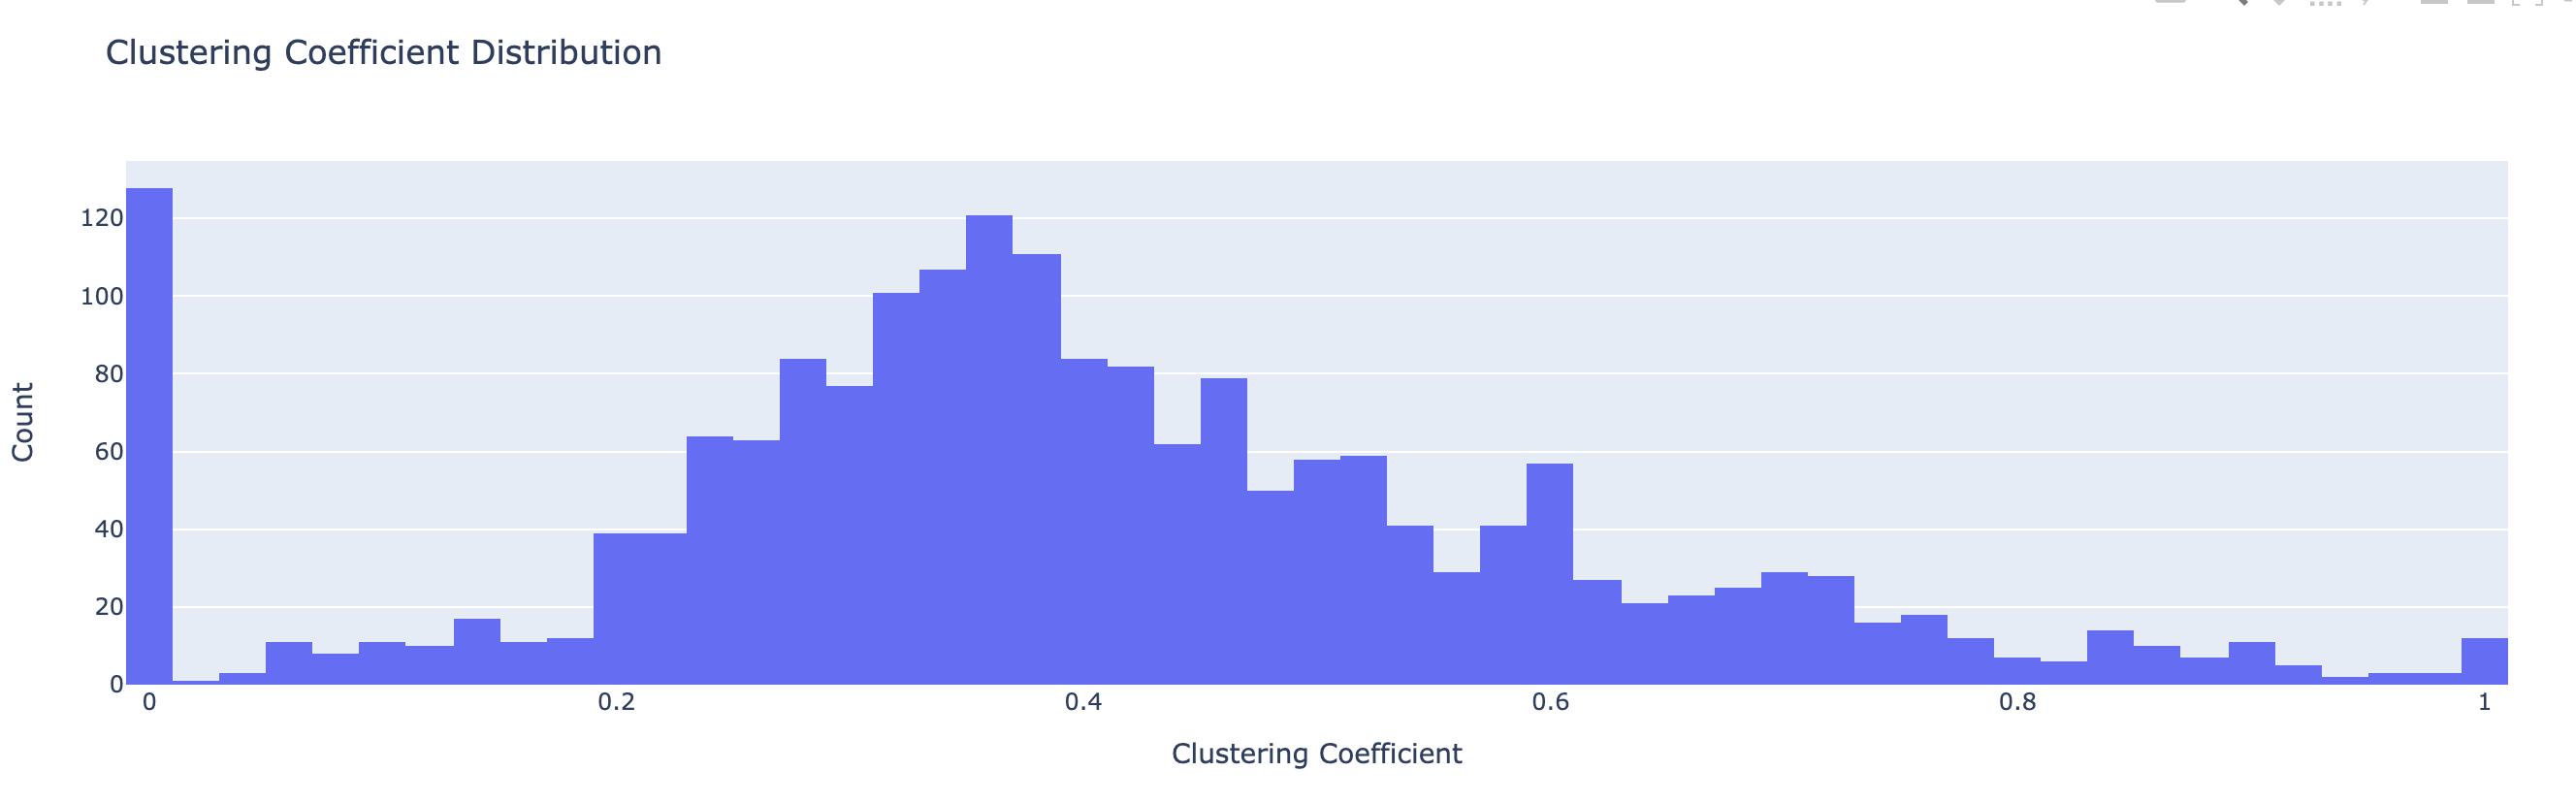

Drugs with a clustering coefficient of 1.000000 seem to have __no significant interactions or low severity__ interactions with other drugs, which might indicate that these drugs are safe to use with other medications. Among these drugs, Tropicamide is an anticholinergic used in sensory organs, Azelaic acid is an anti-acne medication, Inulin is a diagnostic aid for renal function determination, Acetohydroxamic acid is an enzyme inhibitor, and Pegademase is an antineoplastic and immunomodulating agent.

Simethicone is taken off from the market and you can see that most of these Drugs are not represented in the market with the ranking mono or combi as zero. 

The clustering coefficient can give us an idea of how "connected" a drug is within the network of drug interactions. A higher clustering coefficient indicates that the drug is more likely to interact with other drugs. In the case of weighted clustering coefficient, a higher value suggests that the drug has more diverse interactions of varying severity levels. It is important to consider these coefficients when prescribing medications to ensure patient safety and minimize adverse drug interactions.

In [130]:
# Filter by subgraph 1 and sort by Top 2x0 closeness centrality, show columns closeness_centrality, Drug_original, Ranking Mono,Ranking Mono,oral,parenteral,indication_class,topical,chirality,availability_type,black_box_warning,first_in_class	ATC_Classification
nodes[nodes['subgraph'] == 1].sort_values('clustering_coefficient', ascending=False)[['clustering_coefficient', 'Drug_original', 'Ranking Mono ','Ranking Combi', 'oral','parenteral', 'indication_class', 'topical', 'chirality', 'availability_type', 'black_box_warning', 'first_in_class', 'ATC1_names']].head(10)

clustering_coefficient            Drug_original  Ranking Mono   \
1155                1.000000              Tropicamide          431.0   
1169                1.000000             Azelaic acid            0.0   
1464                1.000000                   Inulin            0.0   
1674                1.000000     Acetohydroxamic acid            0.0   
1656                1.000000               Pegademase            0.0   
1927                1.000000              Simethicone            0.0   
1477                1.000000           Secretin human            0.0   
1681                1.000000                 Creatine            0.0   
1196                0.996377              Levobunolol         1032.0   
1840                0.995402  gamma-Aminobutyric acid            0.0   

      Ranking Combi   oral  parenteral  \
1155          518.0  False       False   
1169            0.0  False       False   
1464            0.0  False        True   
1674            0.0   True       False   
1656            0.0  False       False   
1927            0.0   True       False   
1477            0.0  False        True   
1681            0.0  False       False   
1196         1077.0  False       False   
1840            0.0  False       False   

                                   indication_class  topical  chirality  \
1155                                Anticholinergic     True        0.0   
1169                                      Anti-Acne     True        2.0   
1464  Diagnostic Aid (renal function determination)    False        1.0   
1674                      Enzyme Inhibitor (urease)    False        2.0   
1656                                              0    False        1.0   
1927                                              0    False        2.0   
1477                                              0    False        1.0   
1681                                              0    False        2.0   
1196                Anti-Adrenergic (beta-receptor)     True        1.0   
1840                                              0    False        2.0   

      availability_type  black_box_warning  first_in_class  \
1155                1.0                0.0             0.0   
1169                1.0                0.0             0.0   
1464                0.0                0.0             0.0   
1674                1.0                0.0             0.0   
1656               -1.0                0.0             0.0   
1927                2.0                0.0             0.0   
1477                1.0                0.0             0.0   
1681               -1.0                0.0             0.0   
1196                1.0                0.0             0.0   
1840               -1.0                0.0             0.0   

                                             ATC1_names  
1155                              {'SENSORY ORGANS': 2}  
1169                             {'DERMATOLOGICALS': 1}  
1464                                                 {}  
1674      {'GENITO URINARY SYSTEM AND SEX HORMONES': 1}  
1656  {'ANTINEOPLASTIC AND IMMUNOMODULATING AGENTS': 1}  
1927                                                 {}  
1477                                                 {}  
1681                                                 {}  
1196                              {'SENSORY ORGANS': 1}  
1840                              {'NERVOUS SYSTEM': 1}

Focus on the market which has been used only. Filter by Ranking combi/mono >0 

- __Tropicamide__: An anticholinergic drug with a high clustering coefficient of 1.000000, indicating low or no significant interactions with other drugs. It is primarily used in the treatment of eye disorders and is classified under 'SENSORY ORGANS'. Tropicamide is a topical medication, and its chirality is 0.0 (racemic mixture).

- __Levobunolol__: This drug is an anti-adrenergic (beta-receptor) medication, also used in sensory organs, with a clustering coefficient of 0.996377. It is a topical medication with a chirality of 1.0 (single stereoisomer).

- __Travoprost__: A medication used for sensory organs with a clustering coefficient of 0.992347. It is a topical medication with a chirality of 1.0 (single stereoisomer).

- __Brinzolamide__: An antiglaucoma agent used in sensory organs with a clustering coefficient of 0.992063. It is a topical medication with a chirality of 1.0 (single stereoisomer).

- __Nitrazepam__: A sedative-hypnotic and anticonvulsant drug with a clustering coefficient of 0.959596. It belongs to the 'NERVOUS SYSTEM' category and is an oral medication with a chirality of 2.0 (archiral molecule).

The interpretations for these drugs are as follows:

>Most of these drugs are used for sensory organs or the nervous system, and they have high clustering coefficients, suggesting low or no significant interactions with other drugs.
The majority of these drugs are either topical or oral medications.
Chirality varies across these drugs, with some being racemic mixtures, single stereoisomers, or archiral molecules. Chirality may influence the drug's pharmacokinetics, efficacy, and safety profile.
In conclusion, these drugs are generally safe to use with other medications due to their high clustering coefficients. However, it is always essential to consider the individual patient's medical history, potential drug interactions, and the drug's chirality when prescribing medications.

In [131]:
# Filter by subgraph 1  and ranking mono > 0 and sort by Top 20 closeness centrality, show columns closeness_centrality, Drug_original, Ranking Mono,Ranking Mono,oral,parenteral,indication_class,topical,chirality,availability_type,black_box_warning,first_in_class	ATC_Classification
nodes[(nodes['subgraph'] == 1) & (nodes['Ranking Mono '] > 0)].sort_values('clustering_coefficient', ascending=False)[['clustering_coefficient', 'Drug_original', 'Ranking Mono ','Ranking Combi', 'oral','parenteral', 'indication_class', 'topical', 'chirality', 'availability_type', 'black_box_warning', 'first_in_class', 'ATC1_names']].head(10)

clustering_coefficient Drug_original  Ranking Mono   Ranking Combi  \
1155                1.000000   Tropicamide          431.0          518.0   
1196                0.996377   Levobunolol         1032.0         1077.0   
1123                0.992347    Travoprost          474.0          427.0   
1201                0.992063  Brinzolamide          330.0          319.0   
1209                0.959596    Nitrazepam          714.0          536.0   
1160                0.928365   Bimatoprost          380.0          354.0   
1178                0.923810   Acamprosate          836.0          900.0   
1124                0.920378     Etomidate          996.0         1047.0   
1121                0.913753   Oseltamivir          735.0          809.0   
1669                0.908135    Isatuximab          981.0         1029.0   

       oral  parenteral                   indication_class  topical  \
1155  False       False                    Anticholinergic     True   
1196  False       False    Anti-Adrenergic (beta-receptor)     True   
1123  False       False                                  0     True   
1201  False       False                 Antiglaucoma Agent     True   
1209  False       False  Sedative-Hypnotic, Anticonvulsant    False   
1160  False       False                                  0     True   
1178   True       False                                  0    False   
1124  False        True                  Sedative-Hypnotic    False   
1121  False       False                                  0    False   
1669  False        True                                  0    False   

      chirality  availability_type  black_box_warning  first_in_class  \
1155        0.0                1.0                0.0             0.0   
1196        1.0                1.0                0.0             0.0   
1123        1.0                1.0                0.0             0.0   
1201        1.0                1.0                0.0             0.0   
1209        2.0               -1.0                0.0             0.0   
1160        1.0                1.0                0.0             0.0   
1178        2.0                1.0                0.0             0.0   
1124        1.0                1.0                0.0             0.0   
1121        1.0               -1.0                0.0             0.0   
1669        1.0                1.0                0.0             0.0   

                                             ATC1_names  
1155                              {'SENSORY ORGANS': 2}  
1196                              {'SENSORY ORGANS': 1}  
1123                              {'SENSORY ORGANS': 1}  
1201                              {'SENSORY ORGANS': 2}  
1209                              {'NERVOUS SYSTEM': 1}  
1160                              {'SENSORY ORGANS': 1}  
1178                              {'NERVOUS SYSTEM': 1}  
1124                              {'NERVOUS SYSTEM': 1}  
1121                                                 {}  
1669  {'ANTINEOPLASTIC AND IMMUNOMODULATING AGENTS': 1}

<a id='6'></a>
<h1 align="left"><font size="5" color='#104E8B' > <b>  6. Drug Graph Metrics  </b><br></font></h1> 
<a id='6.1'></a>
<h1 align="left"><font size="4" color='#104E8B' > <b>  6.1.Transitivity <br></font></h1> 

This algorithm calculates the proportion of all possible triangles in the graph that are closed. It can help identify the prevalence of clustering or how connected the nodes are within the network.

The value 0.3258070626776695 is the transitivity or global clustering coefficient of the graph G.

Transitivity measures the fraction of "triangles" or three-node subgraphs that are completed in a network. In other words, it measures how likely two nodes that are connected to a common neighbor are also connected to each other. The higher the transitivity value, the more likely it is for two nodes to be connected if they share a neighbor.

In the case of your graph G, the transitivity value of 0.3258 indicates that there is some clustering or grouping of nodes, but the graph is __not highly clustered__. This means that while there are some connections between nodes that form triangles, there are also many nodes that do not form triangles, and the graph has a relatively low level of overall clustering.

In [ ]:
triadic_closure = nx.transitivity(G)
triadic_closure

0.3258070626776695

<a id='6.2'></a>
<h1 align="left"><font size="4" color='#104E8B' > <b>  6.2. K-Core decomposition <br></font></h1> 

K-core decomposition is a network analysis technique used to identify densely connected subgraphs in a graph. It is different from other centrality measures like degree and closeness centrality in that it identifies groups of nodes that are highly connected to each other, rather than focusing on individual nodes' connectivity. K-core decomposition can reveal the structure of a network and help identify highly connected communities or clusters within the network.

Drugs with higher core numbers (e.g., Dexamethasone, Ivacaftor, Mannitol, Betamethasone, and Budesonide) are likely to be more central to the structure of the network and have more connections to other drugs. This could mean that these drugs are involved in more drug interactions or have more significant effects on the network as a whole.
These drugs have many connections, indicating that they may interact with a wide range of other drugs or have multiple therapeutic applications. This information could be useful in drug repositioning efforts or understanding potential drug-drug interactions.

On the other hand, drugs with lower core numbers (e.g., Manganese (sulfate) and Urofollitropin) may be less important or less central to the network.The nodes with the lowest core numbers have a core number of 1, indicating that these drugs are only connected to one other drug in the network. These drugs may have more specific therapeutic applications or fewer known interactions with other drugs

In [132]:
G = nx.from_pandas_edgelist(edges, source='Drug_A', target='Drug_B', edge_attr='Weight', create_using=nx.Graph())
k_cores = nx.core_number(G)

# Sort the dictionary by values in descending order
sorted_k_cores = sorted(k_cores.items(), key=operator.itemgetter(1), reverse=True)

# Get the top 10 nodes with the highest core numbers
top_10_highest = sorted_k_cores[:10]
print("Nodes with the highest core numbers:")
for node, core_num in top_10_highest:
    print(f"{node}: {core_num}")

# Get the top 10 nodes with the lowest core numbers
top_10_lowest = sorted_k_cores[-10:]
print("Nodes with the lowest core numbers:")
for node, core_num in top_10_lowest:
    print(f"{node}: {core_num}")

Nodes with the highest core numbers:
Dexamethasone: 150
Ivacaftor: 150
Mannitol: 150
Betamethasone: 150
Budesonide: 150
Flurbiprofen: 150
Hydrocortisone: 150
Ibuprofen: 150
Mercaptopurine: 150
Prednisolone: 150
Nodes with the lowest core numbers:
Manganese (sulfate): 1
Manganese (chloride): 1
Triheptanoin: 1
Chorionic Gonadotropin (Human): 1
Menotropins: 1
Follitropin: 1
Urofollitropin: 1
Sodium glycerophosphate: 1
Citrus bioflavonoids: 1
Pyrophosphoric acid: 1


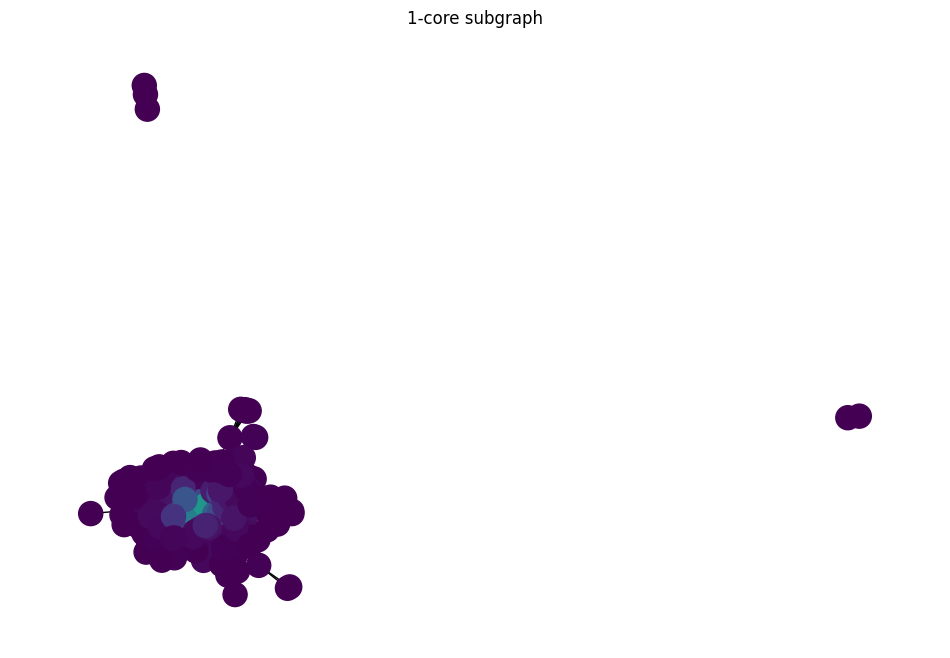

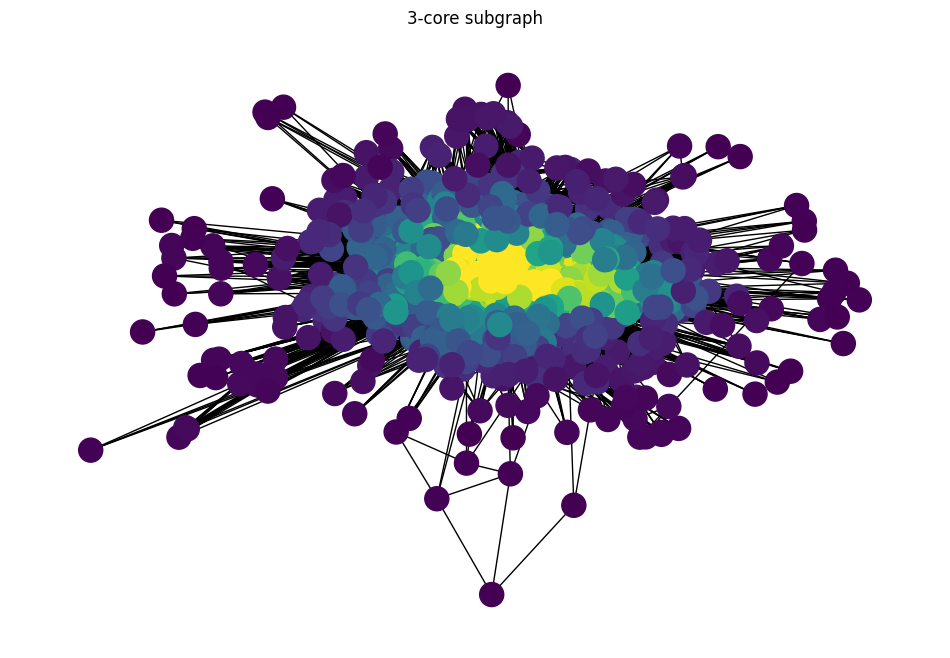

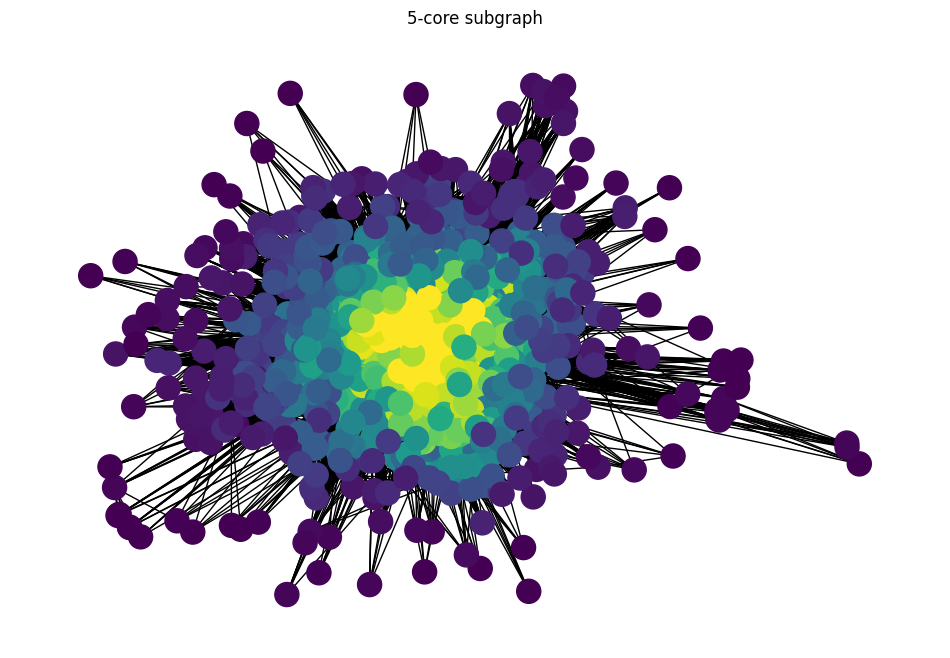

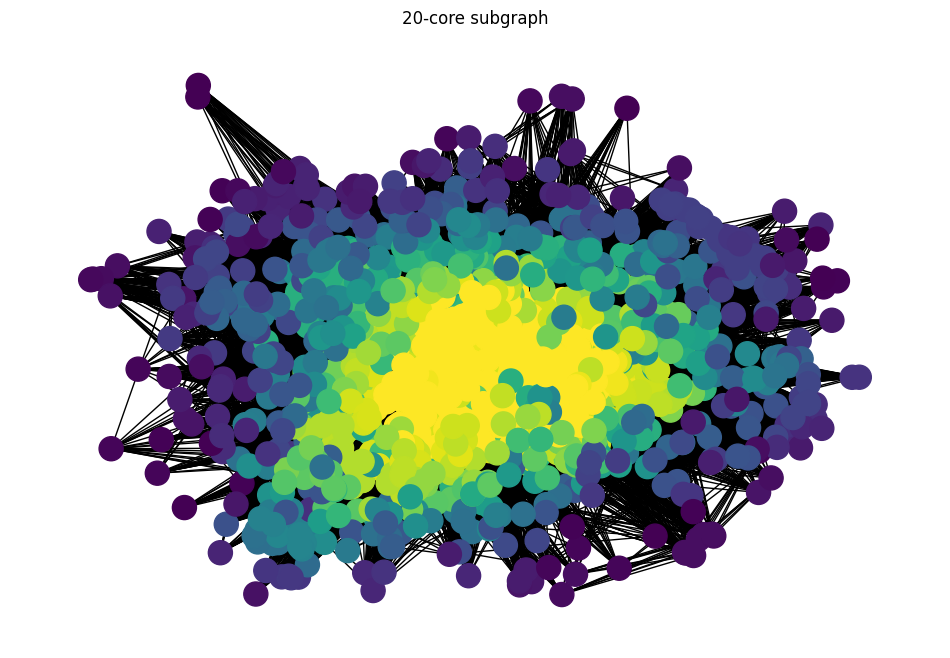

In [143]:
import networkx as nx
import matplotlib.pyplot as plt

def draw_k_cores(G, k_cores, k):
    k_core_subgraph = nx.k_core(G, k=k)
    node_colors = [k_cores[node] for node in k_core_subgraph.nodes]

    plt.figure(figsize=(12, 8))
    plt.title(f"{k}-core subgraph")
    pos = nx.spring_layout(k_core_subgraph)
    nx.draw(k_core_subgraph, pos, node_size=300, node_color=node_colors, cmap=plt.cm.viridis, font_size=4, font_weight='bold')
    plt.show()

G = nx.from_pandas_edgelist(edges, source='Drug_A', target='Drug_B', edge_attr='Weight', create_using=nx.Graph())
k_cores = nx.core_number(G)

# Visualize k-core decomposition for specific k values
k_values = [1, 3, 5,20]
for k in k_values:
    draw_k_cores(G, k_cores, k)


>Drugs with high core numbers and high edge weights, such as __Dexamethasone, Ivacaftor, Mannitol, Betamethasone, Budesonide, Flurbiprofen, Hydrocortisone, Ibuprofen, Mercaptopurine, and Prednisolone__, are likely to be the most influential and potentially the most harmful drugs in the network. They have a large number of connections to other drugs, and their interactions are likely to be severe.
Drugs with low core numbers and high edge weights, such as Manganese (sulfate), Manganese (chloride), Triheptanoin, Chorionic Gonadotropin (Human), Menotropins, Follitropin, Urofollitropin, Sodium glycerophosphate, Citrus bioflavonoids, and Pyrophosphoric acid, may not be as central in the network, but their interactions with other drugs could alsp be likely to be severe or not known.
Drugs with high core numbers and low edge weights, if any, may have a large number of connections to other drugs, but their effects on the network may not be as significant. It's possible that some drugs in the network may fall into this category.
Drugs with low core numbers and low edge weights, such as other drugs in the network that are not mentioned in the top or bottom 10, are likely to be less important and less harmful in the network. They have fewer connections to other drugs, and their interactions may not be particularly severe

<a id='6.3'></a>
<h1 align="left"><font size="4" color='#104E8B' > <b>  6.3.Dispersion <br></font></h1> 

This algorithm computes the dispersion between two nodes, which can help identify pairs of nodes that are not directly connected but have many common neighbors.

In [ ]:
import itertools
import networkx as nx

def dispersion(G, u, v):
    shortest_path_length = nx.shortest_path_length(G, u, v)
    neighbor_count = len(set(G.neighbors(u)) | set(G.neighbors(v)))
    return shortest_path_length / neighbor_count

dispersion_dict = {}
for u, v in itertools.combinations(G.nodes(), 2):
    # check if there is a path between u and v
    if not nx.has_path(G, u, v):
        continue
    dispersion_value = dispersion(G, u, v)
    if dispersion_value > 0:
        key = (u, v) if u < v else (v, u)
        dispersion_dict[key] = dispersion_value

top_10_pairs = sorted(dispersion_dict.items(), key=lambda x: x[1], reverse=True)[:10]

print("Top 10 pairs with highest dispersion values:")
for i, (pair, value) in enumerate(top_10_pairs):
    print(f"{i+1}. Pair: {pair}, Dispersion value: {value}")


Top 10 pairs with highest dispersion values:
1. Pair: ('Lutein', 'Silver (topical)'), Dispersion value: 3.5
2. Pair: ('Hexaminolevulinate', 'Silver (topical)'), Dispersion value: 3.5
3. Pair: ('Norelgestromin', 'Silver (topical)'), Dispersion value: 3.5
4. Pair: ('Gonadorelin', 'Silver (topical)'), Dispersion value: 3.5
5. Pair: ('Pegaptanib (ophthalmic)', 'Silver (topical)'), Dispersion value: 3.5
6. Pair: ('Chorionic Gonadotropin (Human)', 'Silver (topical)'), Dispersion value: 3.5
7. Pair: ('Menotropins', 'Silver (topical)'), Dispersion value: 3.5
8. Pair: ('Follitropin', 'Silver (topical)'), Dispersion value: 3.5
9. Pair: ('Silver (topical)', 'Urofollitropin'), Dispersion value: 3.5
10. Pair: ('Lutein', 'Thimerosal (topical)'), Dispersion value: 3.5


> The dispersion output indicates the strength of the relationships between pairs of drugs. A high dispersion value implies that the drugs in the pair are not only connected but also share connections to other drugs within the network. In other words, high dispersion values suggest that these pairs of drugs are involved in a wider network of drug interactions.

In this case, it seems that __Silver (topical)__ is a common factor in the top 9 pairs with the highest dispersion values. Silver (topical) is often used for its antimicrobial properties in wound care and skin infections. This suggests that Silver (topical) may have a higher likelihood of interacting with a variety of drugs, as indicated by the high dispersion values.

Additionally, several drugs in the pairs, such as Lutein, Gonadorelin, Menotropins, and Follitropin, are related to hormones or hormone regulation. This may indicate that hormonal drugs or drugs that affect hormone regulation might have a higher propensity to interact with Silver (topical).

The 10th pair, ('Lutein', 'Thimerosal (topical)'), also has a high dispersion value. Thimerosal is a mercury-containing organic compound used as a preservative in some vaccines and other medical products. This suggests that Lutein, a carotenoid found in various dietary supplements, might have a higher likelihood of interacting with Thimerosal (topical).

In conclusion, the dispersion output highlights the potential for drug interactions between Silver (topical) and a variety of other drugs, particularly those related to hormones or hormone regulation. It also suggests that Lutein may have a higher propensity to interact with Thimerosal (topical). These results can be useful for healthcare professionals and researchers in identifying possible drug interactions and guiding decision-making when prescribing or studying these drugs.

In [ ]:
if G.has_edge('Lutein', 'Silver (topical)'):
    print(" Both are  neighbors")
else:
    print("Both are not neighbors")

Both are not neighbors


<a id='6.4'></a>
<h1 align="left"><font size="5" color='#104E8B' > <b>  6.4. Assortativity coefficient   </b><br></font></h1>

This measure computes the tendency of nodes with similar attributes (e.g., drug properties) to be connected. A positive assortativity coefficient indicates that nodes with similar properties tend to be connected, while a negative value indicates the opposite.

In [ ]:
nodes.head(2)

DDInterID           Drug  Drug_original  Units MAT Feb 2023   % Growth  \
0  DDInter513  Dexamethasone  Dexamethasone            401082.0   0.055232   
1  DDInter997      Ivacaftor      Ivacaftor                 0.0   0.000000   

   Sum incl combi  Ranking Mono   Ranking Combi  topical  nasal  ophthalmic  \
0       1162374.0           75.0           44.0     True  False       False   
1             0.0            0.0            0.0    False  False       False   

   oral parenteral indication_class  chirality  black_box_warning  \
0  True       True   Glucocorticoid        1.0                0.0   
1  True          0                0        2.0                0.0   

   availability_type  first_in_class  \
0                1.0             0.0   
1                1.0             1.0   

                                 ATC_Classifications  \
0  R01AD53, A01AC02, R01AD03, S02BA06, S03BA01, D...   
1                                            R07AX02   

                                          ATC1_names  \
0  {'RESPIRATORY SYSTEM': 2, 'ALIMENTARY TRACT AN...   
1                          {'RESPIRATORY SYSTEM': 1}   

   ANTIINFECTIVES_FOR_SYSTEMIC_USE  RESPIRATORY_SYSTEM  \
0                                0                   2   
1                                0                   1   

   ANTIPARASITIC_PRODUCTS,_INSECTICIDES_AND_REPELLENTS  \
0                                                  0     
1                                                  0     

   ANTINEOPLASTIC_AND_IMMUNOMODULATING_AGENTS  MUSCULO-SKELETAL_SYSTEM  \
0                                           0                        0   
1                                           0                        0   

   ALIMENTARY_TRACT_AND_METABOLISM  BLOOD_AND_BLOOD_FORMING_ORGANS  \
0                                1                               0   
1                                0                               0   

   SENSORY_ORGANS  \
0               4   
1               0   

   SYSTEMIC_HORMONAL_PREPARATIONS,_EXCL._SEX_HORMONES_AND_INSULINS  \
0                                                  1                 
1                                                  0                 

   NERVOUS_SYSTEM  GENITO_URINARY_SYSTEM_AND_SEX_HORMONES  DERMATOLOGICALS  \
0               0                                       0                3   
1               0                                       0                0   

   VARIOUS  CARDIOVASCULAR_SYSTEM  \
0        0                      1   
1        0                      0   

                                          ATC2_names  \
0  {'R01 - NASAL PREPARATIONS': 1, 'A01 - STOMATO...   
1     {'R07 - OTHER RESPIRATORY SYSTEM PRODUCTS': 1}   

   R01_-_NASAL_PREPARATIONS  A01_-_STOMATOLOGICAL_PREPARATIONS  \
0                         1                                  1   
1                         0                                  0   

   S02_-_OTOLOGICALS  S03_-_OPHTHALMOLOGICAL_AND_OTOLOGICAL_PREPARATIONS  \
0                  1                                                  1    
1                  0                                                  0    

   D07_-_CORTICOSTEROIDS,_DERMATOLOGICAL_PREPARATIONS  \
0                                                  1    
1                                                  0    

   D10_-_ANTI-ACNE_PREPARATIONS  S01_-_OPHTHALMOLOGICALS  \
0                             1                        1   
1                             0                        0   

   C05_-_VASOPROTECTIVES  H02_-_CORTICOSTEROIDS_FOR_SYSTEMIC_USE  \
0                      1                                       1   
1                      0                                       0   

   R07_-_OTHER_RESPIRATORY_SYSTEM_PRODUCTS  J05_-_ANTIVIRALS_FOR_SYSTEMIC_USE  \
0                                        0                                  0   
1                                        1                                  0   

   R03_-_DRUGS_FOR_OBSTRUCTIVE_AIRWAY_DISEASES  \
0        

In [ ]:
#show isnul values
nodes.isnull().sum()

DDInterID                             0
Drug                                  0
Drug_original                         0
Units MAT Feb 2023                    0
 % Growth                             0
                                   ... 
weighted_eigenvector_centrality       0
clustering_coefficient                0
weighted_clustering_coefficient       0
degree                             1939
neighbors                             0
Length: 137, dtype: int64

In [ ]:
# Iterate through each column in the nodes dataframe starting from column 8 and calculate the assortativity for that attribute
for column in nodes.columns[9:-15]:
    nx.set_node_attributes(G, nodes.set_index('DDInterID')[column].to_dict(), column)
    assortativity = nx.attribute_assortativity_coefficient(G, column)
    if assortativity > 0.05 or assortativity < -0.05:
        print(f"Assortativity for attribute {column}: {assortativity}")


Assortativity for attribute oral: 0.0810650117431923
Assortativity for attribute ANTINEOPLASTIC_AND_IMMUNOMODULATING_AGENTS: 0.1164132632967772
Assortativity for attribute BLOOD_AND_BLOOD_FORMING_ORGANS: 0.07157906119795782
Assortativity for attribute NERVOUS_SYSTEM: -0.05162355917451893
Assortativity for attribute N01_-_ANESTHETICS: 0.05131632904400924
Assortativity for attribute L04_-_IMMUNOSUPPRESSANTS: 0.08708673115170827
Assortativity for attribute B01_-_ANTITHROMBOTIC_AGENTS: 0.11689660606015763


- __Oral__ (0.08119514025667399): There is a weak tendency for nodes with similar values for the "oral" attribute to connect to each other more often than expected by chance.
- __Blood and Blood Forming Organs__ (0.07157906119795782): There is a weak tendency for nodes with similar values for the "Blood and Blood Forming Organs" attribute to connect to each other more often than expected by chance.
- Nervous System (-0.05162355917451893): There is a weak tendency for nodes with dissimilar values for the "Nervous System" attribute to connect to each other more often than expected by chance.
- __Antineoplastic and Immunomodulating Agents__ (0.1164132632967772): There is a moderate tendency for nodes with similar values for the "Antineoplastic and Immunomodulating Agents" attribute to connect to each other more often than expected by chance.
- N01 - Anesthetics (0.05131632904400924): There is a weak tendency for nodes with similar values for the "N01 - Anesthetics" attribute to connect to each other more often than expected by chance.
- __L04 - Immunosuppressants__ (0.08708673115170827): There is a weak tendency for nodes with similar values for the "L04 - Immunosuppressants" attribute to connect to each other more often than expected by chance.
- __B01 - Antithrombotic Agents__ (0.11689660606015763): There is a moderate tendency for nodes with similar values for the "B01 - Antithrombotic Agents" attribute to connect to each other more often than expected by chance.

In general, positive assortativity indicates that nodes with similar attribute values tend to connect to each other, while negative assortativity indicates that nodes with dissimilar attribute values tend to connect to each other. However, the strength of the assortativity coefficient can range from very weak (close to zero) to very strong (close to 1 or -1). Therefore, you can interpret these results as weak to moderate assortative behavior for the attributes that have assortativity coefficients that are significantly different from zero.

<a id='6.5'></a>
<h1 align="left"><font size="4" color='#104E8B' > <b>  6.5.Jaccard similarity coefficient  </b><br></font></h1>

This coefficient measures the similarity between sets of neighbors of two nodes, which can be used to predict potential drug interactions.

> The Jaccard similarity coefficient measures the similarity between two sets. In the context of a network, it is commonly used to measure the similarity between sets of neighbors of two nodes. The Jaccard similarity coefficient is defined as the size of the intersection of the two sets divided by the size of their union. In other words, it takes into account the number of common neighbors between two nodes and normalizes it by the total number of unique neighbors the nodes have

In [ ]:
G = nx.from_pandas_edgelist(edges, source='Drug_A', target='Drug_B', edge_attr='Weight', create_using=nx.Graph())

def jaccard_similarity(u, v, G):
    u_neighbors = set(G.neighbors(u))
    v_neighbors = set(G.neighbors(v))
    intersection = u_neighbors.intersection(v_neighbors)
    union = u_neighbors.union(v_neighbors)
    return len(intersection) / len(union)

In [ ]:
import itertools

# Define a function to calculate Jaccard similarity between all pairs of nodes in the graph
def all_jaccard_similarities(G):
    node_pairs = itertools.combinations(G.nodes(), 2)
    similarities = {}
    for u, v in node_pairs:
        similarities[(u, v)] = jaccard_similarity(u, v, G)
    return similarities

# Calculate Jaccard similarities for all pairs of nodes in the graph
similarities = all_jaccard_similarities(G)

# Sort the similarities in descending order
sorted_similarities = sorted(similarities.items(), key=lambda x: x[1], reverse=True)

# Print the top 20 pairs of nodes with the highest Jaccard similarity
for i, (pair, similarity) in enumerate(sorted_similarities[:20]):
    print(f"{i+1}. Nodes with highest Jaccard similarity: {pair}")
    print(f"   Jaccard similarity value: {similarity}")



1. Nodes with highest Jaccard similarity: ('Flurbiprofen (ophthalmic)', 'Diclofenac (ophthalmic)')
   Jaccard similarity value: 1.0
2. Nodes with highest Jaccard similarity: ('Botulinum toxin type A', 'Botulinum Toxin Type B')
   Jaccard similarity value: 1.0
3. Nodes with highest Jaccard similarity: ('Betamethasone (topical)', 'Hydrocortisone (topical)')
   Jaccard similarity value: 1.0
4. Nodes with highest Jaccard similarity: ('Betamethasone (topical)', 'Triamcinolone (topical)')
   Jaccard similarity value: 1.0
5. Nodes with highest Jaccard similarity: ('Betamethasone (topical)', 'Alclometasone (topical)')
   Jaccard similarity value: 1.0
6. Nodes with highest Jaccard similarity: ('Betamethasone (topical)', 'Amcinonide')
   Jaccard similarity value: 1.0
7. Nodes with highest Jaccard similarity: ('Betamethasone (topical)', 'Clobetasol (topical)')
   Jaccard similarity value: 1.0
8. Nodes with highest Jaccard similarity: ('Betamethasone (topical)', 'Clocortolone (topical)')
   Jaccar

The Jaccard similarity is a measure used to __quantify the similarity between two sets__. In the context of your drug network, it is used to measure the similarity between the neighbors of two drugs. A Jaccard similarity value of 1.0 indicates that the two drugs share all their neighbors, suggesting a high level of similarity in their connections within the network.

Here are some interpretations and insights based on the pairs of drugs with the highest Jaccard similarity values:

- Flurbiprofen (ophthalmic), Diclofenac (ophthalmic): Both drugs are __nonsteroidal anti-inflammatory drugs (NSAIDs)__ used in ophthalmic formulations. The Jaccard similarity value of 1.0 implies that they share the same neighbors in the network, suggesting that they may have similar drug interactions and therapeutic uses in eye-related conditions.

- Botulinum toxin type A, Botulinum Toxin Type B: These two drugs are different types of botulinum toxin, which are used in various therapeutic and cosmetic applications. The Jaccard similarity value of 1.0 suggests that they have the same neighbors in the network, implying similar drug interactions and therapeutic applications.

- 3-17. The majority of these pairs involve 'Betamethasone (topical) and other topical corticosteroids. This indicates that these drugs share the same neighbors in the network, suggesting that they have similar drug interactions and therapeutic uses in treating skin conditions, such as eczema, psoriasis, or dermatitis.

- Betamethasone (topical), Chromic chloride: This pair is quite unusual as the two drugs have different therapeutic uses. Betamethasone is a topical corticosteroid, while chromic chloride is a trace element supplement. The Jaccard similarity value of 1.0 suggests that they share the same neighbors in the network, but the reason for this high similarity might require further investigation.

- Betamethasone (topical), Teprotumumab: Teprotumumab is a monoclonal antibody used to treat thyroid eye disease. The high Jaccard similarity with Betamethasone (topical) suggests that they share the same neighbors in the network, which could imply similar drug interactions or overlapping therapeutic uses in eye-related conditions.

- Dexamethasone (topical), Aloe Vera Leaf: Dexamethasone is a topical corticosteroid, while Aloe Vera Leaf is a natural product with various therapeutic uses, including skin conditions. The Jaccard similarity value of 1.0 implies that they share the same neighbors in the network, suggesting that they may have similar drug interactions and therapeutic uses in treating skin conditions.

In conclusion, the high Jaccard similarity values suggest that these drug pairs share the same neighbors in the network, which could imply similar drug interactions or overlapping therapeutic applications. This information could be valuable for understanding drug-drug interactions, drug repositioning, and identifying potential substitutes for specific drugs. However, some unusual pairs might require further investigation to understand the reason behind their high similarity values.

<a id='6.6'></a>
<h1 align="left"><font size="4" color='#104E8B' > <b>  6.6. Link predictions  </b><br></font></h1>

This algorithm uses the Jaccard coefficient to predict the likelihood of a link forming between two nodes. The Jaccard coefficient is a measure of similarity between two nodes, based on the number of shared neighbors they have in the graph.

The jaccard_coefficient() function calculates the Jaccard coefficient between two nodes, by finding the intersection and union of their sets of neighbors, calculate Jaccard similarity for non-connected node pairs!

The predict_link() function uses the Jaccard coefficient to predict the likelihood of a link forming between two nodes, by simply returning the Jaccard coefficient as the link prediction score.

The main part of the algorithm calculates the link prediction score for all pairs of nodes in the graph that are not currently connected by an edge. It then sorts the scores in descending order and prints out the top 10 pairs of nodes with the highest link prediction scores.

In [ ]:
import networkx as nx

# Define the Jaccard similarity function
def jaccard_similarity(u, v, G):
    u_neighbors = set(G.neighbors(u))
    v_neighbors = set(G.neighbors(v))
    intersection = u_neighbors.intersection(v_neighbors)
    union = u_neighbors.union(v_neighbors)
    return len(intersection) / len(union)

# Define a function to calculate Jaccard similarity for non-connected node pairs
def non_connected_jaccard_similarities(G):
    node_pairs = itertools.combinations(G.nodes(), 2)
    similarities = {}
    for u, v in node_pairs:
        if not G.has_edge(u, v):
            similarities[(u, v)] = jaccard_similarity(u, v, G)
    return similarities

# Find all non-connected node pairs
non_connected_node_pairs = [(u, v) for u, v in itertools.combinations(G.nodes(), 2) if not G.has_edge(u, v)]

# Calculate Jaccard similarity for all non-connected node pairs
non_connected_similarities = {pair: jaccard_similarity(pair[0], pair[1], G) for pair in non_connected_node_pairs}

# Sort the similarities in descending order
sorted_non_connected_similarities = sorted(non_connected_similarities.items(), key=lambda x: x[1], reverse=True)

# Print the top 20 pairs of nodes with the highest Jaccard similarity
for i, (pair, similarity) in enumerate(sorted_non_connected_similarities[:20]):
    print(f"{i+1}. Nodes with highest Jaccard similarity (non-connected): {pair}")
    print(f"   Jaccard similarity value: {similarity}")


1. Nodes with highest Jaccard similarity (non-connected): ('Flurbiprofen (ophthalmic)', 'Diclofenac (ophthalmic)')
   Jaccard similarity value: 1.0
2. Nodes with highest Jaccard similarity (non-connected): ('Botulinum toxin type A', 'Botulinum Toxin Type B')
   Jaccard similarity value: 1.0
3. Nodes with highest Jaccard similarity (non-connected): ('Betamethasone (topical)', 'Hydrocortisone (topical)')
   Jaccard similarity value: 1.0
4. Nodes with highest Jaccard similarity (non-connected): ('Betamethasone (topical)', 'Triamcinolone (topical)')
   Jaccard similarity value: 1.0
5. Nodes with highest Jaccard similarity (non-connected): ('Betamethasone (topical)', 'Alclometasone (topical)')
   Jaccard similarity value: 1.0
6. Nodes with highest Jaccard similarity (non-connected): ('Betamethasone (topical)', 'Amcinonide')
   Jaccard similarity value: 1.0
7. Nodes with highest Jaccard similarity (non-connected): ('Betamethasone (topical)', 'Clobetasol (topical)')
   Jaccard similarity valu

Prediction link of unknown 

In [ ]:
combined_df


DDInterID_A              Drug_A  DDInterID_B                   Drug_B  \
0        DDInter513       Dexamethasone   DDInter582             Dolutegravir   
1        DDInter997           Ivacaftor   DDInter582             Dolutegravir   
2       DDInter1019          Lamivudine  DDInter1123                 Mannitol   
3        DDInter195       Betamethasone  DDInter1961               Zidovudine   
4       DDInter1961          Zidovudine   DDInter246               Budesonide   
...             ...                 ...          ...                      ...   
222341   DDInter856             Heparin   DDInter805  gamma-Aminobutyric acid   
222342  DDInter1683  Sodium bicarbonate   DDInter805  gamma-Aminobutyric acid   
222359   DDInter908            Iloprost    DDInter62              Ambrisentan   
222365  DDInter1951            Warfarin  DDInter1942                Vitamin D   
222368  DDInter1683  Sodium bicarbonate  DDInter1942                Vitamin D   

           Level  Weight  
0          Minor       3  
1          Minor       3  
2       Moderate       2  
3       Moderate       2  
4       Moderate       2  
...          ...     ...  
222341   Unknown       2  
222342   Unknown       2  
222359   Unknown       2  
222365   Unknown       2  
222368   Unknown       2  

[160235 rows x 6 columns]

In [ ]:
# Create new weight column with Minor = 3,  Major = 1, Medium = 2 and Unknown = 0
combined_df['Weight_new'] = combined_df['Level'].map({'Minor': 3, 'Major': 1, 'Medium': 2, 'Unknown': 0})


In [ ]:
#show unknown values in weight_new
combined_df[combined_df['Weight_new'] == 0].head(30)

DDInterID_A          Drug_A  DDInterID_B          Drug_B    Level  \
23430   DDInter839       Goserelin  DDInter1242     Montelukast  Unknown   
23431   DDInter839       Goserelin  DDInter1815      Tiotropium  Unknown   
23432   DDInter839       Goserelin   DDInter766     Fluticasone  Unknown   
23433   DDInter458    Cyclosporine  DDInter1066       Lidocaine  Unknown   
23434   DDInter458    Cyclosporine  DDInter1091      Loratadine  Unknown   
23435   DDInter458    Cyclosporine  DDInter1242     Montelukast  Unknown   
23436   DDInter458    Cyclosporine  DDInter1332     Olopatadine  Unknown   
23437   DDInter458    Cyclosporine  DDInter1426  Pentoxifylline  Unknown   
23438   DDInter458    Cyclosporine  DDInter1635      Salmeterol  Unknown   
23439   DDInter458    Cyclosporine   DDInter732    Fexofenadine  Unknown   
23440   DDInter458    Cyclosporine   DDInter506   Desloratadine  Unknown   
23441   DDInter458    Cyclosporine  DDInter1156  Mercaptopurine  Unknown   
23442   DDInter458    Cyclosporine  DDInter1533    Promethazine  Unknown   
23443   DDInter458    Cyclosporine  DDInter1815      Tiotropium  Unknown   
23444   DDInter458    Cyclosporine   DDInter766     Fluticasone  Unknown   
23445  DDInter1323      Octreotide  DDInter1242     Montelukast  Unknown   
23446  DDInter1323      Octreotide   DDInter766     Fluticasone  Unknown   
23447   DDInter451  Cyanocobalamin   DDInter749     Flunisolide  Unknown   
23448   DDInter451  Cyanocobalamin  DDInter1066       Lidocaine  Unknown   
23449   DDInter451  Cyanocobalamin  DDInter1091      Loratadine  Unknown   
23450   DDInter451  Cyanocobalamin  DDInter1242     Montelukast  Unknown   
23451   DDInter451  Cyanocobalamin  DDInter1955     Zafirlukast  Unknown   
23452   DDInter451  Cyanocobalamin  DDInter1855   Triamcinolone  Unknown   
23453   DDInter451  Cyanocobalamin   DDInter885  Hydrocortisone  Unknown   
23454   DDInter451  Cyanocobalamin  DDInter1332     Olopatadine  Unknown   
23455   DDInter451  Cyanocobalamin  DDInter1426  Pentoxifylline  Unknown   
23456   DDInter451  Cyanocobalamin  DDInter1513    Prednisolone  Unknown   
23457   DDInter451  Cyanocobalamin  DDInter1012       Ketotifen  Unknown   
23458   DDInter451  Cyanocobalamin  DDInter1635      Salmeterol  Unknown   
23459   DDInter451  Cyanocobalamin   DDInter732    Fexofenadine  Unknown   

       Weight  Weight_new  
23430       2         0.0  
23431       2         0.0  
23432       2         0.0  
23433       2         0.0  
23434       2         0.0  
23435       2         0.0  
23436       2         0.0  
23437       2         0.0  
23438       2         0.0  
23439       2         0.0  
23440       2         0.0  
23441       2         0.0  
23442       2         0.0  
23443       2         0.0  
23444       2         0.0  
23445       2         0.0  
23446       2         0.0  
23447       2         0.0  
23448       2         0.0  
23449       2         0.0  
23450       2         0.0  
23451       2         0.0  
23452       2         0.0  
23453       2         0.0  
23454       2         0.0  
23455       2         0.0  
23456       2         0.0  
23457       2         0.0  
23458       2         0.0  
23459       2         0.0

<h1 align="left"><font size="4" color='#104E8B' > <b>  6.6. Unknown Link Prediction </b><br></font></h1> 

We try to predict the link of unknown links. 

In [ ]:
# Filter edges with 'Unknown' interaction
filtered_edges = combined_df[combined_df['Weight_new'] != 0]

# Create a new graph without the unknown interactions
G_filtered = nx.from_pandas_edgelist(filtered_edges, source='Drug_A', target='Drug_B', edge_attr='Weight_new', create_using=nx.Graph())


In [ ]:
# Filter edges with 'Unknown' interaction
unknown_edges = combined_df[combined_df['Weight_new'] != 0]
unknown_node_pairs = [(row['Drug_A'], row['Drug_B']) for _, row in unknown_edges.iterrows()]


In [ ]:
unknown_similarities = {pair: jaccard_similarity(pair[0], pair[1], G_filtered) for pair in unknown_node_pairs}


These results show the top 20 pairs of drugs with the highest Jaccard similarity scores among the unknown interactions. A higher Jaccard similarity score indicates that the two drugs share a larger proportion of their neighbors, suggesting that they may have similar interaction profiles.

The interpretation of these results is that the drug pairs with higher Jaccard similarity values are more likely to have similar interaction profiles and, therefore, may potentially interact with each other. In other words, these drug pairs may warrant further investigation to determine if there is indeed a previously unknown interaction between them.

For example, the first pair of drugs with the highest Jaccard similarity score, Etanercept and Golimumab, share 99.43% of their neighbors, indicating that they might have a high likelihood of interacting with each other. Similarly, the second pair, Adalimumab and Certolizumab pegol, share 99.15% of their neighbors, also suggesting a potential interaction.

Keep in mind that these scores should be used as a starting point for further investigation and not as definitive evidence of an interaction. Experimental validation or further research would be required to confirm any potential interactions.

In [ ]:
sorted_unknown_similarities = sorted(unknown_similarities.items(), key=lambda x: x[1], reverse=True)

# Print the top 20 pairs of nodes with the highest Jaccard similarity among unknown interactions
for i, (pair, similarity) in enumerate(sorted_unknown_similarities[:20]):
    print(f"{i+1}. Nodes with highest Jaccard similarity (unknown interactions): {pair}")
    print(f"   Jaccard similarity value: {similarity}")


1. Nodes with highest Jaccard similarity (unknown interactions): ('Etanercept', 'Golimumab')
   Jaccard similarity value: 0.9943342776203966
2. Nodes with highest Jaccard similarity (unknown interactions): ('Adalimumab', 'Certolizumab pegol')
   Jaccard similarity value: 0.9915492957746479
3. Nodes with highest Jaccard similarity (unknown interactions): ('Alefacept', 'Rilonacept')
   Jaccard similarity value: 0.9902912621359223
4. Nodes with highest Jaccard similarity (unknown interactions): ('Hyoscyamine', 'Dicyclomine')
   Jaccard similarity value: 0.9900497512437811
5. Nodes with highest Jaccard similarity (unknown interactions): ('Dexbrompheniramine', 'Carbinoxamine')
   Jaccard similarity value: 0.9898305084745763
6. Nodes with highest Jaccard similarity (unknown interactions): ('Mepenzolate', 'Methscopolamine')
   Jaccard similarity value: 0.9896373056994818
7. Nodes with highest Jaccard similarity (unknown interactions): ('Enoxaparin', 'Dalteparin')
   Jaccard similarity value: 